In [1]:
import os
import sys
import importlib

import pandas as pd
import uproot as up
import numpy as np
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from pathlib import Path
import os.path
import csv
import pyroot as pr

from matplotlib import pyplot as plt
from math import cos, cosh, radians
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator

import awkward as ak

# DataFrame Construction

In [2]:
parsed_events = []
print("reading dataset")
#for file in os.listdir(r"./PrivateSignal16_test/MH1000_Ma100_MChi45"):
for file in os.listdir(r"D:\taisd\Documentos\UERJ\IC\Higgs-to-tautau\dataset\dataset"):
    print(file)
    try:
        #dataset = up.open(os.path.join(r"./PrivateSignal16_test/MH1000_Ma100_MChi45", file))
        dataset = up.open(os.path.join(r"D:\taisd\Documentos\UERJ\IC\Higgs-to-tautau\dataset\dataset", file))
        tree = dataset.get("Events;1")
        #abaixo com menos branches 
        objects = ["genWeight","nTau", "Tau_pt", "Tau_dxy", "Tau_dz", "Tau_eta", "Tau_phi", "Tau_mass","Tau_charge", "Tau_decayMode","Tau_idDecayMode","Tau_idDeepTau2017v2p1VSe", "Tau_idDeepTau2017v2p1VSjet", "Tau_idDeepTau2017v2p1VSmu","nJet", "Jet_area", "Jet_pt", "Jet_eta", "Jet_puId", "Jet_jetId"]
        #abaixo com mais branches
        #objects = ["genWeight","nTau", "Tau_pt", "Tau_dxy", "Tau_dz", "Tau_eta", "Tau_phi","Tau_leadTkDeltaEta", "Tau_leadTkDeltaPhi", "Tau_leadTkPtOverTauPt", "Tau_mass", "Tau_neutralIso",  "Tau_photonsOutsideSignalCone", "Tau_chargedIso", "Tau_puCorr", "Tau_rawAntiEle", "Tau_rawAntiEle2018", "Tau_rawDeepTau2017v2p1VSe", "Tau_rawDeepTau2017v2p1VSjet", "Tau_rawDeepTau2017v2p1VSmu", "Tau_rawIso", "Tau_rawIsodR03", "Tau_rawMVAnewDM2017v2", "Tau_rawMVAoldDM", "Tau_rawMVAoldDM2017v1", "Tau_rawMVAoldDM2017v2", "Tau_rawMVAoldDMdR032017v2", "Tau_charge", "Tau_decayMode", "Tau_jetIdx", "Tau_rawAntiEleCat", "Tau_rawAntiEleCat2018", "Tau_cleanmask", "Tau_genPartIdx", "Tau_genPartFlav", "Tau_idDecayMode", "Tau_idAntiEleDeadECal", "Tau_idAntiEle", "Tau_idAntiEle2018", "Tau_idAntiMu", "Tau_idDecayModeNewDMs", "Tau_idDeepTau2017v2p1VSe", "Tau_idDeepTau2017v2p1VSjet", "Tau_idDeepTau2017v2p1VSmu", "Tau_idMVAnewDM2017v2", "Tau_idMVAoldDM", "Tau_idMVAoldDM2017v1", "Tau_idMVAoldDM2017v2", "Tau_idMVAoldDMdR032017v2", "nJet", "Jet_area", "Jet_btagCSVV2", "Jet_btagDeepB", "Jet_btagDeepCvB", "Jet_btagDeepCvL", "Jet_btagDeepFlavB", "Jet_btagDeepFlavCvB", "Jet_btagDeepFlavCvL", "Jet_btagDeepFlavQG", "Jet_pt", "Jet_eta", "Jet_puId", "Jet_jetId"]
        events = tree.arrays(objects)

        for event in events:
            event = {k: getattr(event, k) for k in objects}
            parsed_events.append(event)

    except:
        print("fail")
        break
print("done")

datasets = parsed_events

reading dataset
1F343B3A-A003-9D42-956A-63D0E972E3E9.root
2FCFCFB1-696A-E84E-98B3-5FE5D2445345.root
42DAD507-A3E8-DC4D-96F4-D85B9607935C.root
55DF9C9F-05E5-8842-BF5E-CE86BCFC8882.root
8729905A-86FF-814A-B31C-6713A78BB76A.root
8CD9F2FC-76B7-E844-82EF-6B509F8C1A04.root
EBB395DE-4617-B843-95CA-FEFB86253D89.root
F38DB76E-F009-A84F-A958-368C6E212E9A.root
done


In [3]:
df = pd.DataFrame(datasets)
print(len(df))

246000


# Object Selection (taus)

In [6]:
# Function to remove items below the threshold from a list and their corresponding items at the same index
def remove_below_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item < threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row

In [7]:
# Function to remove items above the threshold from a list and their corresponding items at the same index
def remove_above_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) > threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row

In [8]:
# Function to remove items not equal to the threshold from a list and their corresponding items at the same index
def remove_non_threshold(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item != threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Tau_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nTau'] = len(row[column_name])

    return row


In [9]:
# Threshold for filtering
#threshold = 0 #0,1,3,7,15
# Column name for which to remove items below the threshold
#column_name = 'Tau_idDeepTau2017v2p1VSmu'
# Apply the function to each row

#assim fica dentro do esperado MI prox 90
#df = df.apply(remove_non_threshold, args=(column_name, threshold), axis=1)
#assim diverge mto, mas é oq ta na referencia
#df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [10]:
# Threshold for filtering
#threshold = 1 #0, 1, 3, 7, 15, 31, 63, 127, 255
# Column name for which to remove items below the threshold
#column_name = 'Tau_idDeepTau2017v2p1VSjet'
# Apply the function to each row
#df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [11]:
# Threshold for filtering
#threshold = 0 #0, 1, 3, 7, 15, 31, 63, 127, 255
# Column name for which to remove items below the threshold
#column_name = 'Tau_idDeepTau2017v2p1VSe'
# Apply the function to each row
#df = df.apply(remove_non_threshold, args=(column_name, threshold), axis=1)

In [12]:
# Threshold for filtering
threshold = 20.0
# Column name for which to remove items below the threshold
column_name = 'Tau_pt'
# Apply the function to each row
df = df.apply(remove_below_threshold, args=(column_name, threshold), axis=1)

In [13]:
# Threshold for filtering
threshold = 2.4
# Column name for which to remove items below the threshold
column_name = 'Tau_eta'
# Apply the function to each row
df = df.apply(remove_above_threshold, args=(column_name, threshold), axis=1)

In [14]:
# Threshold for filtering
threshold = 0.2
# Column name for which to remove items below the threshold
column_name = 'Tau_dz'
# Apply the function to each row
df = df.apply(remove_above_threshold, args=(column_name, threshold), axis=1)

# Event Selection (taus)

In [15]:
# df = df[df['nTau'] != 2] # Delete events with 2 taus
df = df[df['nTau'] == 2] # keep event with 2 taus
df

,genWeight,nTau,Tau_pt,Tau_dxy,Tau_dz,Tau_eta,Tau_phi,Tau_mass,Tau_charge,Tau_decayMode,Tau_idDecayMode,Tau_idDeepTau2017v2p1VSe,Tau_idDeepTau2017v2p1VSjet,Tau_idDeepTau2017v2p1VSmu,nJet,Jet_area,Jet_pt,Jet_eta,Jet_puId,Jet_jetId
2,0.044603,2,"[117.87956, 80.37158]","[5.8442354e-05, -0.0013685226]","[-0.0034058094, 0.033456802]","[1.8581543, 2.0141602]","[-3.0463867, -2.0092773]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[31, 255]","[255, 255]","[0, 0]",4,"[0.48876953, 0.4987793, 0.5288086, 0.38891602]","[137.625, 95.5625, 35.4375, 16.765625]","[1.8557129, 2.0151367, 2.7270508, 4.9101562]","[4, 4, 7, 6]","[0, 2, 6, 0]"
3,0.044603,2,"[134.73776, 61.82594]","[-0.00017821789, -0.0014352798]","[0.0023950338, -0.006166935]","[-0.6015625, -0.2849121]","[1.2062988, 2.0234375]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",9,"[0.48876953, 0.5288086, 0.47875977, 0.50878906...","[143.375, 68.1875, 33.8125, 23.515625, 23.3281...","[-0.60424805, -0.26757812, 0.8170166, 3.485839...","[6, 4, 6, 0, 0, 0, 4, 6, 4]","[2, 2, 6, 6, 6, 6, 6, 6, 0]"
6,0.044603,2,"[109.81783, 38.773117]","[5.2064657e-05, -0.0009498596]","[0.0023766756, -0.0021935701]","[1.1455078, 0.3684082]","[1.9289551, 3.1015625]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",6,"[0.47875977, 0.5385742, 0.4987793, 0.55859375,...","[121.9375, 60.25, 41.34375, 38.34375, 24.85937...","[1.1455078, -0.58251953, 0.37329102, 1.8884277...","[4, 7, 4, 4, 0, 7]","[0, 6, 2, 6, 6, 6]"
7,0.044603,2,"[94.174614, 74.69332]","[-0.00016260147, -0.0020542145]","[-0.0034399033, -0.0025146008]","[0.09100342, -0.7515869]","[1.8757324, 1.3232422]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[15, 7]","[7, 3]",6,"[0.4987793, 0.50878906, 0.4987793, 0.44873047,...","[98.1875, 80.5, 62.90625, 26.59375, 17.59375, ...","[0.098464966, -0.7508545, -1.7456055, -1.07910...","[4, 4, 7, 7, 0, 4]","[2, 2, 6, 6, 6, 6]"
8,0.044603,2,"[68.391075, 41.55966]","[0.013183594, 0.0009126663]","[0.007885933, 0.0016394258]","[-0.15548706, -0.70654297]","[-1.2824707, -2.434082]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 31]","[255, 3]","[15, 15]",6,"[0.4987793, 0.48876953, 0.5288086, 0.33911133,...","[70.0, 54.90625, 17.390625, 16.34375, 16.28125...","[-0.15127563, -0.6939697, -1.1147461, -0.59057...","[4, 4, 6, 7, 0, 4]","[6, 6, 6, 6, 6, 6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245990,0.044641,2,"[33.88711, 20.385242]","[0.0011453629, 0.006175995]","[0.002132535, 0.010624886]","[0.017601013, -1.4885254]","[0.32946777, 0.39312744]","[0.13952637, 0.4404297]","[-1, 1]","[0, 1]","[True, True]","[7, 15]","[63, 1]","[15, 15]",8,"[0.5288086, 0.47875977, 0.46875, 0.50878906, 0...","[137.875, 70.1875, 39.71875, 18.28125, 15.8515...","[0.30358887, -1.4987793, 0.03453827, -1.640136...","[7, 4, 4, 4, 6, 0, 6, 4]","[6, 6, 6, 6, 6, 6, 6, 6]"
245994,0.044641,2,"[91.24304, 63.58553]","[0.0003578663, -0.00026798248]","[0.0010479689, 0.0020605326]","[-2.0756836, -0.9732666]","[-2.7836914, -2.84375]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[15, 127]","[7, 255]","[0, 0]",5,"[0.46875, 0.47875977, 0.40893555, 0.46875, 0.5...","[113.5, 69.1875, 19.03125, 16.671875, 15.1796875]","[-2.0649414, -0.977417, -2.071289, 4.3378906, ...","[4, 4, 6, 7, 6]","[2, 2, 6, 6, 6]"
245996,0.044641,2,"[83.91646, 79.80151]","[-0.00036978722, 0.00085258484]","[-0.0011664033, 0.0021606684]","[-0.16082764, 0.6281738]","[-2.7250977, -1.9702148]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",5,"[0.50878906, 0.48876953, 0.5288086, 0.54833984...","[106.6875, 92.9375, 59.34375, 34.34375, 17.265...","[0.62231445, -0.1496582, 1.1801758, 2.244629, ...","[4, 4, 7, 6, 7]","[6, 2, 6, 6, 6]"
245997,0.044641,2,"[116.44638, 56.146713]","[-0.00036215782, -0.0013999939]","[0.00011245906, 0.011298656]

# Object Selection (jets)


In [16]:
# Function to remove items below the threshold from a list and their corresponding items at the same index
def remove_below_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if item < threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [17]:
# Function to remove items above the threshold from a list and their corresponding items at the same index
def remove_above_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) > threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [18]:
# Function to remove items different threshold from a list and their corresponding items at the same index
def remove_dif_threshold_1(row, column_name, threshold):
    # Create a list of indices of items to be removed
    indices_to_remove = [index for index, item in enumerate(row[column_name]) if abs(item) != threshold]
    # Remove items from the specified column
    row[column_name] = [item for index, item in enumerate(row[column_name]) if index not in indices_to_remove]
    # Remove items from other columns at the same index
    for col_name in row.index:
        if col_name.startswith('Jet_') and col_name != column_name:
            row[col_name] = [item for index, item in enumerate(row[col_name]) if index not in indices_to_remove]
    # Update 'nTau' value based on the modified list
    row['nJet'] = len(row[column_name])

    return row

In [19]:
# Threshold for filtering
threshold = 20.0
# Column name for which to remove items below the threshold
column_name = 'Jet_pt'
# Apply the function to each row
df = df.apply(remove_below_threshold_1, args=(column_name, threshold), axis=1)

In [20]:
# Threshold for filtering
threshold = 2.4
# Column name for which to remove items below the threshold
column_name = 'Jet_eta'
# Apply the function to each row
df = df.apply(remove_above_threshold_1, args=(column_name, threshold), axis=1)

In [21]:
# Threshold for filtering
threshold = 0.4
# Column name for which to remove items below the threshold
column_name = 'Jet_area'
# Apply the function to each row
df = df.apply(remove_below_threshold_1, args=(column_name, threshold), axis=1)

In [22]:
# Threshold for filtering
threshold = 7
# Column name for which to remove items below the threshold
column_name = 'Jet_puId'
# Apply the function to each row
df = df.apply(remove_dif_threshold_1, args=(column_name, threshold), axis=1)

# Event Selection (jets)

In [23]:
# df = df[df['nJet'] <= 1] # Delete events with 1 or more jets
df = df[df['nJet'] >= 1] # keep event with 1 or more jets
df

,genWeight,nTau,Tau_pt,Tau_dxy,Tau_dz,Tau_eta,Tau_phi,Tau_mass,Tau_charge,Tau_decayMode,Tau_idDecayMode,Tau_idDeepTau2017v2p1VSe,Tau_idDeepTau2017v2p1VSjet,Tau_idDeepTau2017v2p1VSmu,nJet,Jet_area,Jet_pt,Jet_eta,Jet_puId,Jet_jetId
6,0.044603,2,"[109.81783, 38.773117]","[5.2064657e-05, -0.0009498596]","[0.0023766756, -0.0021935701]","[1.1455078, 0.3684082]","[1.9289551, 3.1015625]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",2,"[0.5385742, 0.50878906]","[60.25, 22.609375]","[-0.58251953, -0.9165039]","[7, 7]","[6, 6]"
7,0.044603,2,"[94.174614, 74.69332]","[-0.00016260147, -0.0020542145]","[-0.0034399033, -0.0025146008]","[0.09100342, -0.7515869]","[1.8757324, 1.3232422]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[15, 7]","[7, 3]",2,"[0.4987793, 0.44873047]","[62.90625, 26.59375]","[-1.7456055, -1.0791016]","[7, 7]","[6, 6]"
12,0.044603,2,"[132.05415, 28.244772]","[-0.00062179565, 0.007987976]","[0.02383709, -0.0026562214]","[1.0224609, -0.23574829]","[-0.32910156, -0.9725342]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[127, 3]","[3, 7]",1,[0.48876953],[26.28125],[0.18447876],[7],[6]
13,0.044603,2,"[131.85806, 62.7188]","[0.0009832382, -0.00079107285]","[0.00018493831, -0.0011999607]","[1.0332031, 0.10736084]","[1.2941895, 1.0068359]","[0.13952637, 0.13952637]","[-1, 1]","[0, 0]","[True, True]","[15, 255]","[255, 255]","[0, 0]",2,"[0.50878906, 0.4987793]","[170.875, 69.8125]","[-1.1538086, 0.34832764]","[7, 7]","[6, 6]"
14,0.044603,2,"[202.67912, 81.86428]","[-0.0065612793, -0.00019359589]","[0.010029316, 0.0018969774]","[-0.22213745, -0.6411133]","[-0.17199707, -0.72766113]","[0.13952637, 0.13952637]","[-1, 1]","[0, 0]","[True, True]","[0, 0]","[15, 31]","[7, 7]",3,"[0.54833984, 0.4987793, 0.5385742]","[206.125, 60.84375, 46.28125]","[0.3527832, 1.5932617, -0.47314453]","[7, 7, 7]","[6, 6, 6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245989,0.044641,2,"[79.09974, 74.12482]","[0.012451172, -0.005443573]","[0.013945103, -0.0033569336]","[1.9189453, 1.5268555]","[-0.37719727, 0.80322266]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[0, 0]","[15, 15]","[7, 7]",2,"[0.46875, 0.5288086]","[30.375, 22.078125]","[1.2263184, -0.45129395]","[7, 7]","[6, 6]"
245990,0.044641,2,"[33.88711, 20.385242]","[0.0011453629, 0.006175995]","[0.002132535, 0.010624886]","[0.017601013, -1.4885254]","[0.32946777, 0.39312744]","[0.13952637, 0.4404297]","[-1, 1]","[0, 1]","[True, True]","[7, 15]","[63, 1]","[15, 15]",1,[0.5288086],[137.875],[0.30358887],[7],[6]
245996,0.044641,2,"[83.91646, 79.80151]","[-0.00036978722, 0.00085258484]","[-0.0011664033, 0.0021606684]","[-0.16082764, 0.6281738]","[-2.7250977, -1.9702148]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 255]","[255, 255]","[0, 0]",1,[0.5288086],[59.34375],[1.1801758],[7],[6]
245997,0.044641,2,"[116.44638, 56.146713]","[-0.00036215782, -0.0013999939]","[0.00011245906, 0.011298656]","[-0.46069336, -1.3952637]","[1.0549316, 0.45428467]","[0.13952637, 0.13952637]","[1, -1]","[0, 0]","[True, True]","[255, 31]","[255, 255]","[0, 0]",2,"[0.47875977, 0.47875977]","[145.75, 79.5]","[1.5932617, 0.3394165]","[7, 7]","[6, 6]"


# Massa Invariante 

84.75466906482528


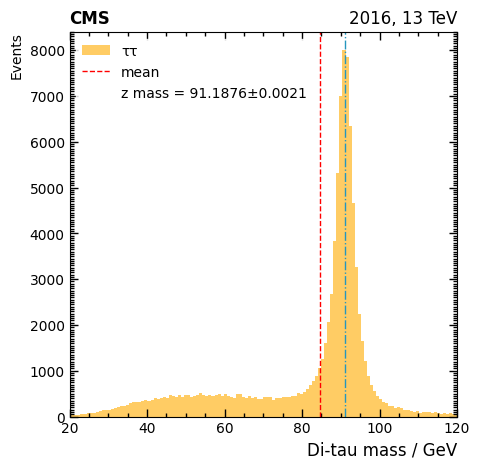

In [24]:
pts = []
etas = []
phis = []
massa = []

for i in range(len(df)):
    pts.append(df["Tau_pt"].iloc[i])
    etas.append(df["Tau_eta"].iloc[i])
    phis.append(df["Tau_phi"].iloc[i])
for i in range(len(pts)):
    try:
        massa.append((2 * pts[i][0] * pts[i][1] * (cosh(etas[i][0] - etas[i][1]) - cos(phis[i][0] - phis[i][1]))) ** (1/2))
    except:
        pass

z_mass = 91.1876#±0.0021

mean = np.mean(massa)
print(mean)
rms = np.sqrt(mean)

plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(massa, bins=1500, color="#ffcc64") #bins é 1500
plt.xlim(20, 120)
plt.xlabel("Di-tau mass / GeV", loc="right", fontsize='large')
plt.ylabel("Events", loc="top")
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch], edgecolor='white', title_fontsize='xx-small')
nova_legenda = plt.legend([patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                           plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1),
                           plt.axvline(z_mass, color='#2596be', linestyle='dashdot', linewidth=1)],
                            ['ττ','mean', 'z mass = 91.1876±0.0021'], edgecolor='white', title_fontsize= 'xx-small')
plt.title("CMS", loc="left", fontweight='bold')
plt.title("2016, 13 TeV", loc="right")

plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True,
                direction='in', length=6, width=1, colors='black')
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1, colors='black', top=True, right=True)
ax = plt.gca()
ax.set_adjustable('datalim')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(50))

plt.show()


In [28]:
print(len(df))

99350


90.65707424635286


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


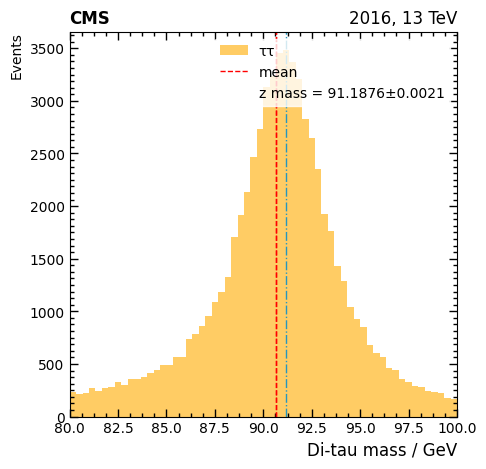

In [25]:
pts = []
etas = []
phis = []
massa2 = []

for i in range(len(df)):
    pts.append(df["Tau_pt"].iloc[i])
    etas.append(df["Tau_eta"].iloc[i])
    phis.append(df["Tau_phi"].iloc[i])
for i in range(len(pts)):
    try:
        massa2.append((2 * pts[i][0] * pts[i][1] * (cosh(etas[i][0] - etas[i][1]) - cos(phis[i][0] - phis[i][1]))) ** (1/2))
    except:
        pass

massa_corte = []
z_mass = 91.1876#±0.0021

for i in massa2:
  if i > 80.:
    if i < 100.:
      massa_corte.append(i)

mean = np.mean(massa_corte)
print(mean)
rms = np.sqrt(mean)


plt.figure(figsize=(5,5))
n, bins, patches = plt.hist(massa_corte, bins = 60, color = "#ffcc64")
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1)
#patches[48].set_fc('#2596be')
plt.xlim(80,100)
#plt.ylim(0,1900)
plt.xlabel("Di-tau mass / GeV", loc="right", fontsize='large')
plt.ylabel("Events", loc="top")
#blue_patch = mpatches.Patch(color='#2596be', label='Z→ττ')
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch], edgecolor='white', title_fontsize= 'xx-small')
legenda_existente = plt.legend()
nova_legenda = plt.legend([patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                           plt.axvline(rms, color='white', linestyle='dashdot', linewidth=1),
                           plt.axvline(z_mass, color='#2596be', linestyle='dashdot', linewidth=1)],
                            ['ττ','mean', 'z mass = 91.1876±0.0021'], edgecolor='white', title_fontsize= 'xx-small')
plt.title("CMS", loc="left", fontweight='bold')
plt.title("2016, 13 TeV", loc="right")

plt.tick_params(axis='both', bottom=True, top=True, left=True, right=True,
                direction='in', length=6, width=1, colors='black')
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1, colors='black', top=True, right=True)
ax = plt.gca()
ax.set_adjustable('datalim')
ax.xaxis.set_minor_locator(MultipleLocator(0.625))
ax.yaxis.set_minor_locator(MultipleLocator(62.50))

plt.show()

C:\Users\taisd\AppData\Local\Temp\ipykernel_19124\3535353700.py:36: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x000001A3DEF441C0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
C:\Users\taisd\AppData\Local\Temp\ipykernel_19124\3535353700.py:36: UserWarning: The label '_child61' of <matplotlib.lines.Line2D object at 0x000001A3C8751550> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),


<Figure size 640x480 with 0 Axes>

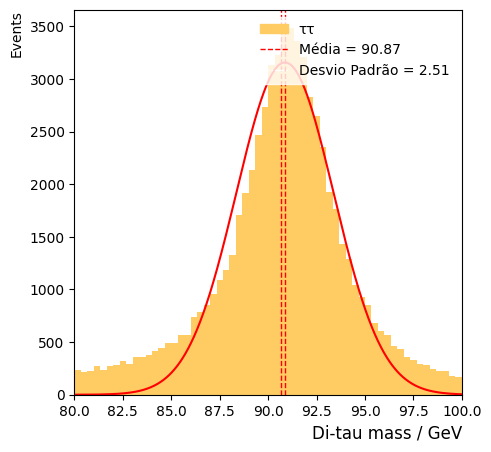

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches

# Função de ajuste gaussiano
def gaussiana(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Valores iniciais estimados para os parâmetros do ajuste
parametros_iniciais = [1000, np.mean(massa_corte), np.std(massa_corte)]

# Realize o ajuste usando curve_fit
parametros_otimizados, matriz_covariancia = curve_fit(gaussiana, bins[:-1], n, p0=parametros_iniciais)

# Extraia os parâmetros ajustados
A, mu, sigma = parametros_otimizados

# Crie um conjunto de pontos para plotar a curva ajustada
x_fit = np.linspace(min(bins), max(bins), 1000)
y_fit = gaussiana(x_fit, A, mu, sigma)

# Limpeza do gráfico para evitar que dois gráficos se sobreponham
plt.clf()

# histograma
plt.figure(figsize=(5, 5))
plt.hist(massa_corte, bins=60, color="#ffcc64")
plt.xlim(80, 100)
plt.xlabel("Di-tau mass / GeV", loc="right", fontsize='large')
plt.ylabel("Events", loc="top")

# Fit
plt.plot(x_fit, y_fit, 'r-', label=f'Ajuste Gaussiano\nMédia = {mu:.2f}, Desvio Padrão = {sigma:.2f}')
yellow_patch = mpatches.Patch(color='#ffcc64', label='ττ')
plt.legend(handles=[yellow_patch, patches[0], plt.axvline(mean, color='r', linestyle='dashed', linewidth=1),
                    plt.axvline(mu, color='r', linestyle='dashed', linewidth=1, label=f'Média = {mu:.2f}'),
                    plt.axvline(sigma, color='white', linestyle='dashdot', linewidth=1, label=f'Desvio Padrão = {sigma:.2f}')],
           edgecolor='white', title_fontsize='xx-small', loc='upper right')

plt.show()
desv_pad = sigma

# Encontrando as estatísticas 

In [27]:
mass = massa #massa invariante do sistema de dois taus
z_mass = 91.1876 #±0.0021    Helena pediu pra usar na verdade 90.7 +- 3.0 no olho msm
z_max = 93.7
z_min = 87.7
events = []
indices = []

for i in mass:
  if i > z_min and i < z_max:
    events.append(i)

for indice, valor in enumerate(mass):
    if valor in events:
        indices.append(indice)

#print("Índices dos eventos:", indices)
#print('eventos:', events)
print('quantidade de eventos na janela do z:', len(events))
print('quantidade total de eventos pós cortes:', len(mass))

ztau = 3.3662#±0.0066 %
ztau_max = ztau+0.0066
ztau_min = ztau-0.0066

peso_em_z = df.loc[indices]['genWeight'].sum()
peso_total = 11044.014  #SEMPRE substituir após rodar analysis_official com mais ou menos arquivos

print('quantidade total de eventos dentro da massa do Z (peso dos eventos):', peso_em_z)
print('quantidade total de eventos sem qualquer corte (peso dos eventos):', peso_total)

estatistica = peso_em_z/peso_total

erro_eventos_na_janela = np.sqrt(peso_em_z)
erro_eventos_gerados = np.sqrt(peso_total) 

erro_estatistico = np.sqrt(pow(erro_eventos_na_janela/peso_em_z, 2) + pow(erro_eventos_gerados/peso_total, 2))

print('porcentagem de ramificação do Z em dois taus na referência: (3.3662 ± 0.0066) %')
print('A estatística final é (',round(estatistica,10),'±', round(erro_estatistico,4),')%. ')
print('A discrepância é igual a:',abs(estatistica - 3.3662), ', onde 2sigma é igual a:', 2*erro_estatistico, 'ou seja, não é compatível.')

quantidade de eventos na janela do z: 44979
quantidade total de eventos pós cortes: 99350


KeyError: '[0, 2, 3, 4, 8, 10, 17, 22, 23, 24, 30, 33, 37, 38, 39, 41, 47, 50, 51, 53, 60, 62, 65, 66, 68, 69, 71, 72, 78, 82, 87, 92, 96, 101, 103, 106, 108, 109, 113, 116, 124, 128, 135, 143, 145, 146, 152, 153, 157, 159, 161, 162, 164, 165, 167, 172, 173, 175, 179, 180, 181, 184, 188, 191, 197, 199, 200, 208, 211, 214, 215, 216, 217, 220, 224, 225, 226, 228, 230, 233, 234, 235, 238, 243, 249, 250, 252, 255, 256, 257, 259, 262, 264, 268, 269, 277, 280, 283, 285, 288, 293, 294, 295, 296, 297, 299, 300, 304, 306, 324, 328, 332, 335, 338, 350, 351, 354, 357, 358, 362, 363, 376, 381, 384, 385, 388, 391, 392, 395, 397, 398, 399, 400, 401, 407, 409, 413, 417, 418, 419, 420, 423, 426, 430, 439, 442, 445, 456, 463, 464, 468, 469, 474, 484, 496, 499, 508, 509, 511, 513, 514, 522, 530, 533, 536, 537, 539, 545, 546, 551, 553, 554, 558, 562, 564, 565, 570, 573, 575, 577, 579, 583, 584, 585, 586, 591, 595, 599, 600, 603, 604, 606, 611, 613, 614, 617, 621, 623, 624, 633, 636, 638, 649, 650, 651, 652, 653, 659, 669, 671, 681, 703, 705, 707, 710, 720, 721, 726, 729, 735, 742, 749, 751, 755, 761, 763, 769, 773, 778, 779, 785, 787, 789, 790, 793, 799, 805, 811, 812, 820, 827, 834, 839, 841, 842, 843, 853, 857, 870, 873, 877, 881, 892, 899, 916, 925, 926, 927, 928, 932, 942, 947, 951, 952, 955, 957, 958, 960, 966, 969, 972, 977, 983, 984, 987, 993, 997, 1009, 1012, 1013, 1015, 1016, 1029, 1031, 1035, 1040, 1044, 1045, 1049, 1050, 1051, 1053, 1054, 1059, 1065, 1068, 1073, 1077, 1083, 1084, 1087, 1092, 1101, 1112, 1115, 1116, 1120, 1123, 1125, 1138, 1141, 1146, 1152, 1153, 1154, 1162, 1164, 1176, 1180, 1183, 1186, 1195, 1202, 1205, 1209, 1212, 1222, 1223, 1224, 1227, 1235, 1240, 1241, 1245, 1260, 1261, 1263, 1268, 1270, 1272, 1273, 1275, 1282, 1291, 1292, 1293, 1296, 1300, 1306, 1312, 1314, 1315, 1316, 1320, 1327, 1332, 1341, 1350, 1353, 1357, 1359, 1361, 1362, 1375, 1383, 1386, 1387, 1395, 1398, 1403, 1405, 1414, 1415, 1416, 1420, 1428, 1434, 1441, 1442, 1444, 1449, 1452, 1454, 1456, 1465, 1469, 1472, 1473, 1478, 1479, 1481, 1487, 1491, 1498, 1503, 1509, 1512, 1516, 1518, 1524, 1525, 1529, 1531, 1536, 1537, 1538, 1548, 1551, 1552, 1553, 1554, 1559, 1561, 1564, 1567, 1569, 1579, 1581, 1582, 1585, 1596, 1597, 1605, 1606, 1608, 1611, 1612, 1630, 1633, 1637, 1638, 1639, 1642, 1644, 1646, 1647, 1648, 1650, 1651, 1658, 1662, 1664, 1666, 1667, 1670, 1671, 1676, 1678, 1680, 1688, 1692, 1693, 1697, 1699, 1705, 1707, 1709, 1713, 1728, 1732, 1733, 1735, 1738, 1743, 1752, 1753, 1763, 1765, 1772, 1773, 1775, 1776, 1777, 1778, 1780, 1783, 1790, 1792, 1794, 1796, 1797, 1803, 1807, 1808, 1811, 1813, 1824, 1827, 1829, 1833, 1838, 1840, 1841, 1842, 1843, 1845, 1852, 1855, 1861, 1875, 1878, 1883, 1888, 1894, 1895, 1897, 1905, 1906, 1908, 1910, 1914, 1915, 1916, 1917, 1918, 1921, 1926, 1927, 1928, 1931, 1935, 1938, 1943, 1944, 1945, 1952, 1953, 1958, 1959, 1965, 1968, 1969, 1971, 1974, 1975, 1977, 1980, 1981, 1984, 1992, 1994, 1996, 2000, 2004, 2008, 2010, 2014, 2017, 2031, 2032, 2035, 2045, 2051, 2054, 2056, 2059, 2062, 2064, 2066, 2070, 2071, 2072, 2081, 2082, 2091, 2095, 2098, 2100, 2101, 2103, 2107, 2113, 2114, 2119, 2122, 2125, 2132, 2138, 2140, 2142, 2144, 2150, 2153, 2162, 2163, 2165, 2166, 2171, 2172, 2174, 2178, 2179, 2183, 2189, 2190, 2193, 2198, 2202, 2204, 2209, 2210, 2220, 2221, 2224, 2229, 2231, 2234, 2235, 2241, 2244, 2246, 2254, 2255, 2258, 2261, 2267, 2277, 2278, 2279, 2288, 2293, 2294, 2308, 2312, 2315, 2320, 2321, 2325, 2327, 2333, 2335, 2337, 2338, 2339, 2343, 2345, 2346, 2347, 2349, 2350, 2351, 2352, 2357, 2359, 2360, 2363, 2364, 2365, 2368, 2372, 2373, 2375, 2376, 2379, 2380, 2381, 2383, 2385, 2386, 2387, 2394, 2410, 2420, 2428, 2429, 2435, 2437, 2438, 2449, 2450, 2451, 2453, 2459, 2462, 2464, 2465, 2471, 2474, 2476, 2482, 2486, 2487, 2489, 2490, 2495, 2496, 2497, 2503, 2505, 2508, 2509, 2512, 2513, 2514, 2516, 2517, 2518, 2523, 2524, 2536, 2543, 2544, 2545, 2548, 2558, 2559, 2562, 2563, 2565, 2571, 2572, 2576, 2579, 2584, 2587, 2592, 2595, 2596, 2597, 2600, 2601, 2604, 2611, 2622, 2624, 2628, 2630, 2631, 2633, 2635, 2636, 2637, 2640, 2641, 2649, 2651, 2654, 2656, 2657, 2658, 2660, 2661, 2665, 2669, 2671, 2672, 2676, 2677, 2679, 2688, 2695, 2707, 2710, 2713, 2719, 2724, 2728, 2737, 2739, 2742, 2749, 2753, 2754, 2755, 2757, 2762, 2766, 2768, 2771, 2772, 2773, 2775, 2782, 2785, 2787, 2795, 2797, 2800, 2806, 2819, 2830, 2835, 2839, 2842, 2845, 2847, 2849, 2850, 2861, 2871, 2875, 2876, 2877, 2883, 2884, 2886, 2895, 2903, 2907, 2908, 2912, 2916, 2918, 2919, 2920, 2922, 2928, 2931, 2933, 2938, 2941, 2945, 2947, 2950, 2956, 2957, 2960, 2963, 2971, 2972, 2979, 2983, 2996, 2998, 3001, 3005, 3006, 3007, 3009, 3014, 3015, 3018, 3019, 3026, 3027, 3035, 3038, 3039, 3044, 3045, 3047, 3051, 3052, 3059, 3062, 3063, 3068, 3070, 3071, 3076, 3080, 3081, 3083, 3085, 3087, 3098, 3099, 3102, 3103, 3109, 3120, 3129, 3132, 3134, 3135, 3137, 3140, 3146, 3154, 3163, 3170, 3171, 3174, 3177, 3181, 3186, 3188, 3191, 3192, 3193, 3195, 3205, 3206, 3207, 3210, 3211, 3212, 3222, 3226, 3228, 3232, 3233, 3236, 3237, 3244, 3253, 3255, 3265, 3267, 3273, 3276, 3279, 3280, 3284, 3290, 3294, 3305, 3308, 3309, 3320, 3327, 3328, 3333, 3335, 3337, 3340, 3344, 3349, 3355, 3356, 3360, 3361, 3364, 3371, 3373, 3382, 3397, 3406, 3414, 3416, 3417, 3418, 3423, 3428, 3431, 3444, 3445, 3451, 3454, 3457, 3461, 3464, 3465, 3469, 3472, 3473, 3479, 3489, 3493, 3499, 3510, 3514, 3516, 3519, 3520, 3521, 3531, 3532, 3542, 3543, 3545, 3548, 3549, 3559, 3562, 3564, 3567, 3568, 3569, 3573, 3576, 3583, 3584, 3585, 3589, 3592, 3597, 3600, 3601, 3604, 3615, 3616, 3617, 3628, 3629, 3633, 3634, 3637, 3638, 3645, 3646, 3649, 3650, 3653, 3659, 3664, 3665, 3667, 3672, 3673, 3677, 3680, 3688, 3692, 3706, 3709, 3712, 3716, 3717, 3723, 3726, 3728, 3733, 3736, 3739, 3743, 3749, 3752, 3757, 3758, 3759, 3772, 3780, 3786, 3787, 3790, 3791, 3795, 3796, 3800, 3804, 3805, 3808, 3812, 3816, 3819, 3820, 3821, 3826, 3829, 3842, 3847, 3849, 3850, 3855, 3860, 3863, 3867, 3868, 3873, 3876, 3881, 3882, 3887, 3889, 3892, 3897, 3899, 3900, 3905, 3906, 3910, 3911, 3918, 3921, 3922, 3923, 3924, 3929, 3932, 3933, 3934, 3939, 3941, 3942, 3954, 3956, 3962, 3970, 3974, 3980, 3986, 3987, 3990, 3998, 4002, 4003, 4004, 4008, 4009, 4013, 4014, 4018, 4027, 4028, 4033, 4036, 4037, 4045, 4047, 4050, 4053, 4054, 4056, 4065, 4066, 4069, 4070, 4072, 4077, 4078, 4079, 4083, 4087, 4088, 4096, 4099, 4103, 4108, 4118, 4119, 4120, 4126, 4131, 4133, 4136, 4137, 4138, 4148, 4151, 4153, 4154, 4155, 4159, 4161, 4167, 4170, 4180, 4181, 4184, 4189, 4203, 4204, 4206, 4209, 4211, 4216, 4218, 4219, 4221, 4223, 4224, 4236, 4240, 4246, 4248, 4253, 4263, 4269, 4275, 4277, 4278, 4284, 4285, 4290, 4312, 4316, 4320, 4322, 4323, 4324, 4328, 4329, 4333, 4335, 4339, 4345, 4346, 4347, 4353, 4357, 4371, 4381, 4383, 4384, 4385, 4387, 4392, 4396, 4410, 4411, 4419, 4421, 4423, 4425, 4426, 4428, 4429, 4430, 4434, 4436, 4442, 4449, 4455, 4460, 4463, 4467, 4473, 4474, 4477, 4480, 4482, 4483, 4485, 4493, 4494, 4503, 4509, 4514, 4516, 4518, 4524, 4526, 4529, 4535, 4539, 4546, 4547, 4548, 4549, 4551, 4552, 4560, 4561, 4563, 4574, 4580, 4583, 4585, 4587, 4588, 4603, 4605, 4607, 4608, 4610, 4612, 4613, 4622, 4624, 4625, 4627, 4633, 4639, 4646, 4648, 4653, 4656, 4662, 4668, 4671, 4677, 4684, 4687, 4698, 4706, 4707, 4709, 4711, 4713, 4716, 4722, 4724, 4727, 4729, 4734, 4739, 4741, 4743, 4747, 4748, 4755, 4759, 4760, 4764, 4765, 4768, 4773, 4783, 4789, 4790, 4792, 4793, 4794, 4809, 4813, 4814, 4815, 4820, 4823, 4824, 4828, 4830, 4832, 4837, 4838, 4840, 4844, 4846, 4847, 4851, 4855, 4857, 4860, 4863, 4865, 4872, 4873, 4874, 4876, 4879, 4884, 4886, 4889, 4893, 4894, 4895, 4896, 4899, 4901, 4906, 4907, 4913, 4914, 4918, 4921, 4924, 4927, 4928, 4929, 4932, 4933, 4935, 4943, 4946, 4949, 4952, 4953, 4958, 4960, 4962, 4964, 4970, 4979, 4983, 4986, 5008, 5015, 5018, 5027, 5029, 5031, 5035, 5039, 5041, 5042, 5043, 5049, 5052, 5060, 5063, 5068, 5071, 5072, 5075, 5078, 5080, 5082, 5087, 5088, 5089, 5094, 5097, 5106, 5107, 5109, 5110, 5116, 5119, 5124, 5126, 5128, 5136, 5137, 5138, 5141, 5142, 5144, 5151, 5156, 5157, 5161, 5165, 5167, 5170, 5171, 5184, 5185, 5186, 5187, 5189, 5190, 5194, 5198, 5202, 5205, 5208, 5218, 5219, 5220, 5221, 5223, 5228, 5229, 5232, 5242, 5245, 5248, 5251, 5254, 5255, 5258, 5260, 5262, 5263, 5268, 5273, 5274, 5285, 5286, 5288, 5295, 5297, 5299, 5300, 5302, 5307, 5312, 5314, 5316, 5317, 5318, 5319, 5323, 5324, 5327, 5328, 5331, 5335, 5337, 5346, 5351, 5352, 5356, 5359, 5365, 5368, 5370, 5371, 5372, 5373, 5381, 5387, 5390, 5393, 5395, 5403, 5404, 5406, 5407, 5409, 5415, 5419, 5425, 5426, 5427, 5443, 5444, 5446, 5451, 5452, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5469, 5483, 5484, 5489, 5490, 5499, 5504, 5505, 5518, 5519, 5522, 5527, 5531, 5536, 5537, 5538, 5547, 5548, 5557, 5558, 5564, 5565, 5566, 5567, 5569, 5570, 5573, 5576, 5582, 5592, 5596, 5597, 5598, 5599, 5603, 5605, 5606, 5607, 5615, 5620, 5629, 5630, 5634, 5635, 5637, 5641, 5643, 5647, 5654, 5656, 5661, 5663, 5664, 5669, 5671, 5675, 5679, 5680, 5690, 5695, 5697, 5698, 5701, 5705, 5714, 5719, 5720, 5722, 5723, 5725, 5729, 5731, 5733, 5741, 5742, 5751, 5757, 5759, 5764, 5765, 5768, 5771, 5775, 5777, 5780, 5781, 5785, 5788, 5796, 5798, 5801, 5811, 5815, 5824, 5827, 5832, 5838, 5839, 5842, 5847, 5849, 5851, 5855, 5859, 5861, 5863, 5867, 5871, 5878, 5892, 5895, 5896, 5914, 5915, 5917, 5918, 5922, 5933, 5934, 5945, 5951, 5952, 5956, 5960, 5961, 5967, 5972, 5973, 5976, 5985, 5987, 5991, 5993, 5995, 5997, 6003, 6004, 6005, 6009, 6011, 6016, 6023, 6024, 6036, 6037, 6038, 6041, 6044, 6045, 6046, 6055, 6057, 6060, 6061, 6062, 6063, 6066, 6075, 6078, 6083, 6093, 6095, 6098, 6103, 6111, 6112, 6122, 6126, 6130, 6131, 6136, 6138, 6141, 6145, 6153, 6155, 6156, 6158, 6161, 6162, 6166, 6170, 6177, 6180, 6182, 6185, 6186, 6190, 6192, 6205, 6206, 6211, 6213, 6219, 6226, 6230, 6234, 6235, 6243, 6245, 6246, 6247, 6248, 6252, 6254, 6255, 6256, 6257, 6258, 6259, 6265, 6267, 6270, 6271, 6276, 6279, 6280, 6282, 6287, 6288, 6291, 6297, 6301, 6307, 6309, 6320, 6321, 6327, 6333, 6336, 6337, 6346, 6356, 6362, 6364, 6365, 6371, 6377, 6381, 6382, 6388, 6398, 6404, 6407, 6408, 6410, 6412, 6418, 6419, 6422, 6425, 6428, 6435, 6443, 6444, 6448, 6453, 6456, 6458, 6461, 6463, 6469, 6470, 6471, 6472, 6473, 6475, 6476, 6479, 6483, 6488, 6492, 6494, 6495, 6497, 6499, 6502, 6509, 6510, 6511, 6515, 6520, 6525, 6531, 6534, 6537, 6539, 6541, 6549, 6551, 6554, 6560, 6561, 6562, 6564, 6565, 6566, 6567, 6569, 6575, 6577, 6580, 6581, 6583, 6584, 6585, 6590, 6600, 6607, 6610, 6614, 6616, 6618, 6622, 6624, 6629, 6630, 6631, 6634, 6639, 6649, 6652, 6654, 6657, 6659, 6666, 6669, 6670, 6673, 6675, 6676, 6684, 6686, 6689, 6692, 6696, 6707, 6709, 6713, 6716, 6723, 6725, 6733, 6737, 6739, 6745, 6748, 6752, 6753, 6755, 6756, 6758, 6761, 6762, 6763, 6765, 6768, 6770, 6774, 6777, 6779, 6782, 6784, 6789, 6792, 6793, 6802, 6805, 6818, 6825, 6828, 6830, 6834, 6835, 6844, 6847, 6854, 6857, 6860, 6861, 6866, 6867, 6868, 6871, 6873, 6875, 6880, 6883, 6885, 6892, 6893, 6894, 6898, 6900, 6901, 6902, 6903, 6904, 6908, 6909, 6911, 6913, 6914, 6922, 6923, 6927, 6934, 6935, 6936, 6944, 6950, 6953, 6954, 6957, 6959, 6960, 6961, 6976, 6980, 6989, 6991, 6996, 7006, 7007, 7008, 7010, 7016, 7017, 7020, 7021, 7022, 7025, 7027, 7029, 7034, 7038, 7040, 7041, 7044, 7049, 7052, 7053, 7055, 7059, 7061, 7062, 7063, 7065, 7066, 7067, 7080, 7087, 7090, 7094, 7101, 7102, 7103, 7104, 7109, 7112, 7118, 7121, 7122, 7129, 7135, 7146, 7152, 7164, 7170, 7174, 7177, 7180, 7183, 7190, 7191, 7194, 7195, 7199, 7201, 7202, 7203, 7204, 7206, 7212, 7213, 7214, 7215, 7216, 7221, 7229, 7231, 7232, 7233, 7236, 7238, 7241, 7247, 7248, 7250, 7251, 7256, 7259, 7261, 7263, 7266, 7268, 7269, 7272, 7281, 7283, 7289, 7290, 7294, 7295, 7296, 7309, 7310, 7311, 7322, 7328, 7330, 7332, 7335, 7336, 7337, 7338, 7340, 7346, 7349, 7356, 7357, 7358, 7359, 7366, 7367, 7373, 7382, 7387, 7389, 7391, 7392, 7393, 7398, 7403, 7404, 7410, 7415, 7422, 7423, 7424, 7435, 7438, 7440, 7445, 7446, 7453, 7456, 7466, 7468, 7481, 7483, 7490, 7493, 7498, 7501, 7503, 7504, 7506, 7507, 7510, 7511, 7512, 7513, 7521, 7523, 7527, 7532, 7538, 7539, 7542, 7552, 7557, 7561, 7562, 7566, 7570, 7574, 7575, 7591, 7596, 7598, 7601, 7604, 7612, 7618, 7621, 7622, 7623, 7624, 7627, 7628, 7629, 7631, 7634, 7640, 7643, 7649, 7655, 7660, 7662, 7665, 7667, 7669, 7681, 7682, 7692, 7695, 7696, 7700, 7703, 7710, 7716, 7718, 7719, 7720, 7723, 7724, 7726, 7732, 7734, 7735, 7737, 7741, 7746, 7747, 7752, 7756, 7760, 7763, 7764, 7770, 7772, 7778, 7787, 7788, 7794, 7797, 7802, 7804, 7808, 7809, 7811, 7812, 7816, 7824, 7837, 7840, 7841, 7842, 7845, 7862, 7866, 7867, 7869, 7883, 7887, 7888, 7893, 7895, 7900, 7904, 7906, 7907, 7912, 7914, 7916, 7920, 7925, 7930, 7937, 7952, 7953, 7962, 7963, 7965, 7966, 7967, 7968, 7970, 7975, 7976, 7983, 7984, 7988, 7990, 7993, 7995, 8002, 8003, 8009, 8012, 8013, 8019, 8022, 8029, 8036, 8037, 8038, 8039, 8042, 8043, 8044, 8045, 8051, 8056, 8059, 8060, 8063, 8064, 8065, 8070, 8072, 8075, 8078, 8079, 8080, 8082, 8084, 8086, 8088, 8092, 8093, 8097, 8099, 8102, 8108, 8109, 8112, 8114, 8115, 8118, 8119, 8120, 8126, 8130, 8134, 8137, 8139, 8143, 8146, 8149, 8155, 8165, 8169, 8173, 8174, 8177, 8179, 8180, 8183, 8186, 8188, 8194, 8196, 8199, 8201, 8211, 8219, 8220, 8223, 8224, 8227, 8235, 8241, 8244, 8247, 8254, 8255, 8261, 8269, 8271, 8272, 8275, 8277, 8280, 8283, 8289, 8290, 8296, 8299, 8302, 8303, 8309, 8313, 8317, 8327, 8330, 8331, 8332, 8341, 8344, 8351, 8356, 8357, 8359, 8360, 8361, 8367, 8369, 8370, 8371, 8381, 8382, 8388, 8394, 8395, 8396, 8400, 8401, 8404, 8406, 8410, 8412, 8417, 8418, 8425, 8427, 8432, 8434, 8437, 8445, 8448, 8452, 8456, 8457, 8459, 8461, 8464, 8465, 8466, 8474, 8479, 8481, 8482, 8484, 8487, 8488, 8489, 8496, 8498, 8499, 8500, 8502, 8506, 8511, 8516, 8518, 8520, 8524, 8525, 8526, 8527, 8532, 8539, 8541, 8542, 8553, 8554, 8557, 8571, 8574, 8590, 8591, 8594, 8595, 8598, 8605, 8607, 8610, 8614, 8616, 8617, 8618, 8622, 8625, 8628, 8629, 8632, 8633, 8636, 8642, 8649, 8654, 8661, 8662, 8664, 8667, 8674, 8680, 8683, 8686, 8689, 8693, 8703, 8729, 8730, 8731, 8732, 8737, 8739, 8741, 8744, 8745, 8747, 8749, 8759, 8760, 8764, 8769, 8772, 8774, 8775, 8780, 8786, 8791, 8792, 8795, 8798, 8800, 8802, 8804, 8813, 8816, 8817, 8820, 8825, 8828, 8829, 8832, 8839, 8841, 8842, 8849, 8851, 8853, 8855, 8856, 8865, 8870, 8876, 8877, 8879, 8881, 8887, 8888, 8889, 8891, 8893, 8894, 8895, 8898, 8903, 8906, 8908, 8909, 8916, 8921, 8925, 8927, 8928, 8930, 8935, 8946, 8948, 8953, 8958, 8962, 8964, 8965, 8971, 8973, 8977, 8979, 8984, 8991, 8996, 9001, 9003, 9006, 9017, 9022, 9031, 9033, 9040, 9042, 9043, 9044, 9046, 9047, 9048, 9063, 9064, 9079, 9089, 9090, 9092, 9094, 9098, 9103, 9111, 9112, 9114, 9116, 9119, 9122, 9124, 9125, 9126, 9129, 9133, 9137, 9140, 9141, 9142, 9146, 9151, 9152, 9153, 9154, 9155, 9158, 9161, 9165, 9166, 9168, 9172, 9173, 9176, 9178, 9182, 9186, 9188, 9190, 9193, 9195, 9196, 9206, 9207, 9209, 9210, 9219, 9222, 9223, 9224, 9232, 9234, 9240, 9251, 9252, 9254, 9261, 9263, 9265, 9273, 9276, 9277, 9282, 9283, 9284, 9285, 9287, 9290, 9292, 9302, 9303, 9304, 9308, 9312, 9313, 9314, 9316, 9317, 9318, 9327, 9342, 9343, 9344, 9347, 9349, 9352, 9354, 9355, 9356, 9361, 9366, 9369, 9370, 9374, 9376, 9379, 9380, 9382, 9394, 9395, 9398, 9400, 9401, 9402, 9405, 9406, 9414, 9423, 9433, 9438, 9439, 9441, 9442, 9449, 9453, 9459, 9468, 9472, 9478, 9488, 9489, 9492, 9494, 9496, 9504, 9507, 9510, 9514, 9516, 9517, 9520, 9522, 9526, 9531, 9539, 9540, 9541, 9542, 9543, 9544, 9552, 9554, 9558, 9559, 9563, 9564, 9565, 9566, 9571, 9573, 9575, 9579, 9580, 9581, 9586, 9587, 9589, 9590, 9600, 9602, 9604, 9606, 9607, 9610, 9617, 9625, 9631, 9636, 9638, 9646, 9649, 9653, 9658, 9665, 9669, 9671, 9675, 9676, 9681, 9690, 9692, 9700, 9703, 9716, 9722, 9727, 9728, 9729, 9736, 9737, 9740, 9745, 9746, 9749, 9752, 9753, 9755, 9761, 9763, 9766, 9774, 9778, 9781, 9782, 9784, 9787, 9791, 9797, 9809, 9816, 9819, 9824, 9834, 9838, 9841, 9843, 9847, 9848, 9853, 9854, 9855, 9856, 9858, 9860, 9867, 9872, 9873, 9875, 9879, 9880, 9883, 9887, 9891, 9893, 9895, 9923, 9926, 9930, 9938, 9941, 9942, 9944, 9947, 9952, 9954, 9957, 9959, 9961, 9963, 9964, 9968, 9972, 9977, 9992, 9996, 10000, 10002, 10003, 10005, 10011, 10014, 10016, 10020, 10021, 10026, 10027, 10028, 10030, 10031, 10037, 10041, 10043, 10044, 10052, 10053, 10054, 10055, 10058, 10061, 10063, 10066, 10067, 10087, 10091, 10098, 10105, 10119, 10121, 10123, 10132, 10133, 10136, 10140, 10145, 10148, 10153, 10155, 10157, 10158, 10163, 10171, 10174, 10176, 10180, 10182, 10185, 10188, 10193, 10194, 10202, 10206, 10207, 10213, 10218, 10220, 10221, 10223, 10230, 10232, 10236, 10237, 10241, 10243, 10248, 10249, 10253, 10258, 10264, 10265, 10267, 10271, 10278, 10281, 10283, 10286, 10288, 10291, 10299, 10301, 10303, 10306, 10307, 10308, 10310, 10311, 10312, 10313, 10317, 10322, 10325, 10328, 10330, 10335, 10339, 10341, 10348, 10354, 10355, 10357, 10361, 10372, 10375, 10377, 10378, 10381, 10384, 10387, 10388, 10390, 10392, 10396, 10397, 10398, 10401, 10418, 10432, 10437, 10440, 10447, 10450, 10453, 10456, 10460, 10465, 10467, 10471, 10474, 10478, 10481, 10487, 10497, 10507, 10508, 10513, 10515, 10517, 10518, 10519, 10523, 10527, 10532, 10537, 10541, 10544, 10545, 10546, 10547, 10551, 10555, 10556, 10558, 10562, 10566, 10571, 10573, 10574, 10578, 10581, 10584, 10585, 10590, 10591, 10600, 10604, 10607, 10610, 10611, 10613, 10622, 10628, 10633, 10634, 10640, 10641, 10642, 10644, 10645, 10656, 10660, 10661, 10665, 10667, 10673, 10678, 10680, 10687, 10691, 10697, 10699, 10700, 10703, 10708, 10711, 10712, 10714, 10717, 10719, 10721, 10724, 10727, 10731, 10737, 10739, 10745, 10747, 10749, 10750, 10751, 10754, 10763, 10766, 10775, 10786, 10788, 10789, 10799, 10801, 10807, 10812, 10813, 10818, 10823, 10825, 10827, 10828, 10829, 10837, 10838, 10841, 10846, 10848, 10856, 10857, 10859, 10864, 10865, 10870, 10881, 10883, 10884, 10892, 10896, 10897, 10900, 10904, 10909, 10910, 10913, 10914, 10916, 10917, 10918, 10920, 10921, 10922, 10924, 10938, 10941, 10942, 10953, 10955, 10957, 10964, 10968, 10973, 10975, 10976, 10980, 10983, 10991, 11001, 11016, 11021, 11024, 11034, 11044, 11046, 11048, 11053, 11056, 11060, 11061, 11062, 11070, 11072, 11075, 11080, 11082, 11084, 11094, 11096, 11099, 11117, 11121, 11122, 11126, 11128, 11129, 11132, 11136, 11137, 11139, 11140, 11142, 11151, 11153, 11165, 11169, 11176, 11181, 11183, 11195, 11197, 11200, 11204, 11205, 11217, 11219, 11220, 11224, 11239, 11246, 11247, 11253, 11254, 11255, 11256, 11259, 11268, 11270, 11271, 11274, 11279, 11286, 11288, 11289, 11290, 11291, 11292, 11296, 11297, 11304, 11305, 11306, 11308, 11312, 11316, 11318, 11321, 11323, 11325, 11326, 11335, 11343, 11345, 11347, 11348, 11354, 11361, 11377, 11378, 11380, 11381, 11398, 11418, 11440, 11449, 11452, 11456, 11461, 11464, 11465, 11466, 11468, 11470, 11476, 11480, 11490, 11497, 11501, 11502, 11510, 11514, 11521, 11522, 11523, 11525, 11533, 11534, 11540, 11545, 11547, 11549, 11554, 11555, 11562, 11566, 11568, 11571, 11574, 11576, 11583, 11588, 11593, 11594, 11597, 11604, 11605, 11612, 11622, 11623, 11625, 11627, 11628, 11632, 11634, 11638, 11641, 11642, 11647, 11649, 11650, 11654, 11657, 11665, 11667, 11674, 11681, 11683, 11692, 11694, 11695, 11696, 11704, 11708, 11713, 11720, 11729, 11734, 11736, 11737, 11745, 11746, 11751, 11758, 11760, 11765, 11768, 11773, 11777, 11779, 11780, 11784, 11785, 11793, 11794, 11797, 11799, 11800, 11806, 11809, 11810, 11813, 11817, 11824, 11830, 11831, 11837, 11842, 11845, 11849, 11855, 11859, 11860, 11863, 11867, 11873, 11874, 11880, 11886, 11890, 11892, 11895, 11897, 11900, 11911, 11914, 11917, 11918, 11921, 11927, 11929, 11930, 11935, 11938, 11939, 11941, 11944, 11945, 11953, 11955, 11956, 11960, 11965, 11972, 11974, 11976, 11978, 11981, 11982, 11983, 11984, 11985, 11990, 11993, 12016, 12019, 12020, 12021, 12025, 12031, 12032, 12034, 12037, 12040, 12042, 12044, 12045, 12056, 12059, 12063, 12073, 12077, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12088, 12097, 12098, 12099, 12100, 12101, 12110, 12119, 12121, 12122, 12126, 12127, 12129, 12130, 12141, 12146, 12156, 12170, 12175, 12180, 12183, 12184, 12185, 12186, 12187, 12189, 12190, 12193, 12200, 12205, 12206, 12207, 12211, 12212, 12216, 12232, 12237, 12243, 12246, 12253, 12255, 12258, 12259, 12277, 12279, 12288, 12292, 12296, 12299, 12301, 12305, 12308, 12311, 12312, 12317, 12321, 12328, 12329, 12336, 12338, 12343, 12348, 12356, 12357, 12358, 12359, 12369, 12373, 12374, 12377, 12384, 12387, 12390, 12391, 12401, 12404, 12406, 12407, 12412, 12415, 12420, 12423, 12429, 12430, 12431, 12433, 12434, 12438, 12439, 12449, 12452, 12453, 12454, 12458, 12467, 12470, 12472, 12475, 12476, 12477, 12479, 12480, 12486, 12488, 12489, 12492, 12493, 12494, 12498, 12500, 12504, 12505, 12507, 12509, 12511, 12515, 12517, 12518, 12522, 12526, 12530, 12536, 12538, 12541, 12549, 12550, 12551, 12555, 12556, 12557, 12562, 12569, 12572, 12581, 12588, 12591, 12601, 12607, 12615, 12621, 12623, 12625, 12627, 12629, 12631, 12633, 12636, 12639, 12640, 12644, 12645, 12646, 12650, 12653, 12654, 12655, 12658, 12659, 12660, 12664, 12667, 12670, 12672, 12673, 12675, 12676, 12679, 12682, 12690, 12709, 12711, 12712, 12715, 12718, 12721, 12724, 12725, 12735, 12736, 12743, 12747, 12748, 12751, 12752, 12761, 12764, 12766, 12772, 12778, 12787, 12789, 12792, 12795, 12798, 12801, 12805, 12806, 12807, 12809, 12815, 12820, 12823, 12824, 12828, 12829, 12846, 12848, 12855, 12860, 12863, 12864, 12868, 12874, 12877, 12881, 12882, 12884, 12889, 12892, 12897, 12903, 12904, 12905, 12906, 12908, 12909, 12911, 12913, 12914, 12915, 12921, 12925, 12926, 12928, 12929, 12930, 12933, 12934, 12937, 12938, 12940, 12947, 12949, 12950, 12954, 12958, 12959, 12968, 12972, 12973, 12976, 12977, 12980, 12982, 12985, 12986, 12991, 12994, 12996, 13001, 13004, 13013, 13014, 13015, 13022, 13024, 13025, 13027, 13031, 13032, 13034, 13038, 13040, 13041, 13042, 13044, 13050, 13051, 13054, 13058, 13066, 13068, 13071, 13074, 13076, 13079, 13080, 13084, 13090, 13092, 13094, 13096, 13097, 13101, 13103, 13108, 13109, 13112, 13122, 13126, 13127, 13130, 13140, 13143, 13153, 13154, 13161, 13162, 13167, 13170, 13171, 13177, 13178, 13185, 13186, 13191, 13200, 13201, 13203, 13204, 13206, 13208, 13212, 13217, 13219, 13229, 13230, 13231, 13233, 13234, 13235, 13243, 13246, 13252, 13253, 13258, 13264, 13267, 13268, 13271, 13277, 13279, 13288, 13289, 13290, 13291, 13294, 13304, 13308, 13309, 13310, 13313, 13316, 13317, 13318, 13319, 13320, 13323, 13330, 13334, 13335, 13338, 13339, 13343, 13348, 13356, 13357, 13365, 13370, 13372, 13373, 13379, 13381, 13386, 13389, 13390, 13393, 13402, 13409, 13414, 13418, 13425, 13428, 13429, 13438, 13454, 13461, 13467, 13468, 13473, 13476, 13482, 13490, 13492, 13494, 13495, 13509, 13511, 13514, 13515, 13520, 13521, 13524, 13525, 13530, 13531, 13543, 13551, 13556, 13558, 13559, 13563, 13564, 13565, 13566, 13567, 13574, 13576, 13577, 13580, 13586, 13588, 13589, 13590, 13592, 13594, 13605, 13606, 13610, 13613, 13616, 13621, 13623, 13624, 13628, 13629, 13630, 13631, 13632, 13633, 13634, 13641, 13651, 13656, 13657, 13660, 13661, 13664, 13667, 13673, 13679, 13685, 13693, 13694, 13695, 13710, 13725, 13726, 13729, 13730, 13731, 13737, 13740, 13746, 13749, 13750, 13751, 13759, 13766, 13767, 13769, 13778, 13779, 13780, 13781, 13784, 13789, 13796, 13810, 13813, 13814, 13819, 13821, 13822, 13825, 13830, 13832, 13836, 13840, 13841, 13843, 13844, 13845, 13847, 13849, 13850, 13853, 13855, 13858, 13863, 13864, 13868, 13874, 13878, 13883, 13884, 13892, 13897, 13899, 13908, 13910, 13913, 13916, 13918, 13922, 13925, 13927, 13930, 13934, 13940, 13950, 13951, 13953, 13957, 13960, 13967, 13970, 13971, 13972, 13977, 13979, 13988, 13991, 13992, 13994, 14003, 14004, 14007, 14008, 14011, 14022, 14030, 14031, 14034, 14035, 14038, 14043, 14047, 14053, 14058, 14077, 14079, 14081, 14082, 14083, 14084, 14087, 14091, 14096, 14097, 14098, 14101, 14102, 14116, 14119, 14125, 14136, 14137, 14144, 14145, 14155, 14159, 14166, 14167, 14171, 14172, 14174, 14179, 14183, 14186, 14187, 14200, 14206, 14207, 14212, 14225, 14226, 14235, 14236, 14239, 14241, 14244, 14249, 14250, 14252, 14261, 14262, 14266, 14270, 14272, 14273, 14275, 14279, 14283, 14284, 14290, 14293, 14298, 14310, 14314, 14315, 14316, 14321, 14322, 14327, 14328, 14331, 14333, 14335, 14336, 14338, 14339, 14341, 14345, 14346, 14350, 14355, 14359, 14364, 14366, 14369, 14370, 14371, 14373, 14380, 14381, 14383, 14387, 14388, 14391, 14393, 14395, 14397, 14398, 14403, 14405, 14422, 14425, 14428, 14431, 14437, 14450, 14455, 14461, 14462, 14466, 14471, 14473, 14475, 14476, 14477, 14485, 14487, 14491, 14492, 14498, 14501, 14509, 14512, 14516, 14518, 14519, 14521, 14530, 14531, 14536, 14540, 14545, 14546, 14555, 14556, 14557, 14559, 14560, 14564, 14566, 14567, 14568, 14575, 14576, 14579, 14582, 14583, 14584, 14590, 14592, 14594, 14595, 14598, 14600, 14605, 14611, 14615, 14620, 14626, 14631, 14632, 14640, 14642, 14651, 14662, 14663, 14668, 14670, 14678, 14680, 14684, 14685, 14686, 14688, 14691, 14693, 14697, 14699, 14701, 14702, 14706, 14707, 14712, 14713, 14714, 14718, 14722, 14725, 14727, 14729, 14731, 14734, 14738, 14747, 14748, 14753, 14758, 14759, 14761, 14762, 14764, 14766, 14769, 14771, 14772, 14779, 14780, 14781, 14783, 14785, 14788, 14791, 14804, 14805, 14811, 14813, 14820, 14823, 14829, 14836, 14840, 14844, 14847, 14850, 14862, 14867, 14874, 14878, 14881, 14884, 14885, 14889, 14893, 14895, 14896, 14897, 14898, 14901, 14912, 14920, 14921, 14930, 14937, 14938, 14940, 14942, 14946, 14947, 14961, 14964, 14965, 14967, 14969, 14971, 14972, 14984, 14987, 14990, 14991, 14995, 14997, 14998, 15000, 15004, 15006, 15007, 15009, 15011, 15013, 15014, 15017, 15018, 15026, 15029, 15037, 15044, 15045, 15046, 15047, 15050, 15053, 15058, 15059, 15063, 15065, 15072, 15077, 15081, 15082, 15083, 15090, 15092, 15094, 15096, 15098, 15099, 15103, 15118, 15119, 15122, 15126, 15127, 15128, 15132, 15134, 15139, 15143, 15150, 15152, 15156, 15159, 15162, 15166, 15168, 15170, 15176, 15178, 15181, 15185, 15186, 15192, 15194, 15199, 15201, 15203, 15207, 15208, 15214, 15218, 15221, 15222, 15225, 15227, 15239, 15240, 15241, 15245, 15247, 15249, 15257, 15262, 15265, 15274, 15275, 15281, 15293, 15300, 15301, 15309, 15312, 15313, 15318, 15320, 15321, 15327, 15329, 15333, 15334, 15338, 15339, 15343, 15348, 15350, 15357, 15358, 15363, 15366, 15376, 15382, 15386, 15388, 15393, 15402, 15407, 15411, 15414, 15419, 15425, 15433, 15436, 15438, 15439, 15441, 15443, 15446, 15447, 15448, 15449, 15450, 15453, 15460, 15461, 15463, 15466, 15470, 15472, 15476, 15478, 15480, 15481, 15483, 15484, 15485, 15486, 15488, 15489, 15490, 15493, 15494, 15495, 15505, 15506, 15509, 15515, 15517, 15518, 15522, 15546, 15549, 15551, 15557, 15562, 15571, 15580, 15586, 15589, 15590, 15598, 15599, 15603, 15605, 15609, 15612, 15619, 15624, 15625, 15627, 15628, 15629, 15631, 15639, 15641, 15645, 15648, 15653, 15654, 15656, 15659, 15662, 15664, 15681, 15690, 15691, 15697, 15705, 15707, 15709, 15712, 15719, 15720, 15734, 15737, 15738, 15740, 15744, 15746, 15751, 15764, 15766, 15767, 15769, 15773, 15783, 15784, 15787, 15792, 15797, 15808, 15812, 15816, 15825, 15828, 15836, 15842, 15843, 15844, 15855, 15856, 15858, 15859, 15861, 15862, 15865, 15869, 15870, 15873, 15874, 15875, 15878, 15883, 15891, 15896, 15897, 15906, 15907, 15909, 15911, 15913, 15917, 15930, 15936, 15937, 15938, 15941, 15950, 15954, 15961, 15971, 15974, 15979, 15982, 15986, 15989, 15997, 16006, 16012, 16014, 16024, 16025, 16029, 16030, 16038, 16041, 16043, 16052, 16054, 16056, 16063, 16064, 16065, 16066, 16067, 16068, 16073, 16091, 16092, 16109, 16116, 16118, 16123, 16133, 16134, 16136, 16143, 16145, 16149, 16151, 16153, 16157, 16159, 16164, 16165, 16169, 16173, 16179, 16184, 16190, 16193, 16194, 16196, 16203, 16216, 16217, 16218, 16226, 16227, 16228, 16235, 16236, 16241, 16244, 16248, 16249, 16250, 16255, 16257, 16259, 16262, 16266, 16270, 16277, 16278, 16279, 16283, 16288, 16296, 16300, 16301, 16310, 16315, 16316, 16319, 16322, 16326, 16327, 16328, 16331, 16332, 16337, 16340, 16341, 16344, 16350, 16353, 16356, 16359, 16360, 16362, 16364, 16368, 16370, 16371, 16374, 16375, 16377, 16382, 16383, 16388, 16397, 16401, 16404, 16410, 16420, 16425, 16431, 16433, 16437, 16440, 16448, 16450, 16454, 16461, 16463, 16467, 16469, 16470, 16473, 16474, 16475, 16488, 16494, 16496, 16508, 16510, 16511, 16512, 16516, 16523, 16525, 16527, 16537, 16540, 16544, 16546, 16551, 16557, 16558, 16574, 16577, 16586, 16589, 16598, 16601, 16602, 16610, 16614, 16617, 16619, 16621, 16622, 16625, 16629, 16630, 16632, 16635, 16639, 16644, 16647, 16651, 16653, 16665, 16669, 16676, 16678, 16680, 16685, 16686, 16688, 16690, 16700, 16704, 16708, 16710, 16715, 16718, 16729, 16731, 16733, 16738, 16739, 16742, 16749, 16751, 16759, 16764, 16765, 16773, 16774, 16780, 16789, 16792, 16793, 16796, 16800, 16803, 16804, 16810, 16811, 16817, 16820, 16826, 16827, 16839, 16847, 16848, 16849, 16850, 16852, 16853, 16854, 16857, 16862, 16866, 16873, 16874, 16876, 16877, 16882, 16890, 16891, 16897, 16902, 16908, 16910, 16913, 16914, 16915, 16917, 16922, 16924, 16926, 16927, 16930, 16936, 16940, 16944, 16946, 16948, 16952, 16953, 16954, 16962, 16966, 16967, 16968, 16970, 16972, 16973, 16974, 16976, 16981, 16984, 16985, 16986, 16987, 16988, 16989, 16994, 17004, 17005, 17017, 17019, 17025, 17027, 17029, 17034, 17040, 17046, 17048, 17053, 17055, 17057, 17058, 17059, 17060, 17062, 17068, 17076, 17084, 17085, 17086, 17088, 17089, 17093, 17100, 17104, 17105, 17106, 17113, 17115, 17119, 17124, 17130, 17146, 17150, 17153, 17156, 17158, 17160, 17171, 17178, 17186, 17188, 17194, 17195, 17198, 17208, 17218, 17221, 17222, 17225, 17228, 17230, 17233, 17234, 17239, 17243, 17251, 17255, 17274, 17278, 17280, 17286, 17287, 17290, 17291, 17292, 17293, 17294, 17295, 17298, 17307, 17308, 17310, 17314, 17316, 17317, 17326, 17327, 17330, 17333, 17345, 17351, 17357, 17358, 17359, 17360, 17361, 17362, 17363, 17368, 17372, 17376, 17377, 17382, 17383, 17384, 17385, 17388, 17389, 17390, 17396, 17403, 17404, 17409, 17414, 17416, 17421, 17423, 17425, 17428, 17432, 17440, 17441, 17446, 17455, 17458, 17461, 17466, 17477, 17478, 17494, 17499, 17507, 17512, 17518, 17519, 17527, 17531, 17532, 17537, 17540, 17541, 17542, 17545, 17547, 17554, 17559, 17570, 17597, 17598, 17599, 17600, 17604, 17606, 17608, 17613, 17614, 17620, 17623, 17628, 17629, 17632, 17633, 17636, 17637, 17638, 17641, 17644, 17645, 17648, 17656, 17660, 17661, 17662, 17664, 17665, 17670, 17672, 17677, 17678, 17681, 17693, 17695, 17700, 17701, 17703, 17708, 17709, 17710, 17717, 17719, 17720, 17721, 17731, 17738, 17745, 17748, 17749, 17758, 17760, 17761, 17762, 17763, 17766, 17769, 17770, 17774, 17781, 17784, 17791, 17794, 17795, 17798, 17800, 17805, 17806, 17808, 17809, 17810, 17811, 17812, 17818, 17822, 17828, 17829, 17835, 17837, 17838, 17839, 17846, 17849, 17850, 17851, 17852, 17855, 17856, 17864, 17866, 17867, 17870, 17885, 17891, 17892, 17896, 17897, 17900, 17908, 17912, 17913, 17918, 17922, 17925, 17926, 17936, 17942, 17946, 17960, 17967, 17968, 17970, 17981, 17983, 17987, 17991, 17997, 17999, 18005, 18013, 18015, 18020, 18025, 18027, 18028, 18036, 18041, 18042, 18044, 18046, 18053, 18054, 18063, 18068, 18081, 18082, 18089, 18095, 18096, 18105, 18114, 18115, 18116, 18120, 18125, 18129, 18132, 18134, 18139, 18142, 18151, 18155, 18157, 18158, 18159, 18160, 18161, 18167, 18168, 18171, 18172, 18173, 18174, 18179, 18180, 18183, 18184, 18189, 18191, 18200, 18207, 18208, 18219, 18225, 18228, 18230, 18234, 18242, 18248, 18249, 18252, 18263, 18264, 18265, 18267, 18269, 18270, 18276, 18278, 18279, 18281, 18282, 18285, 18303, 18305, 18317, 18320, 18321, 18326, 18330, 18332, 18336, 18340, 18341, 18344, 18346, 18349, 18350, 18353, 18357, 18360, 18365, 18367, 18370, 18371, 18372, 18373, 18376, 18377, 18380, 18382, 18384, 18393, 18396, 18397, 18398, 18399, 18401, 18403, 18409, 18416, 18418, 18420, 18421, 18422, 18427, 18428, 18429, 18431, 18444, 18452, 18457, 18464, 18466, 18472, 18477, 18480, 18487, 18491, 18494, 18502, 18507, 18517, 18527, 18528, 18530, 18531, 18533, 18534, 18537, 18538, 18541, 18543, 18548, 18549, 18550, 18564, 18568, 18569, 18576, 18577, 18580, 18582, 18591, 18597, 18601, 18602, 18605, 18610, 18614, 18621, 18627, 18634, 18638, 18639, 18647, 18650, 18651, 18657, 18658, 18659, 18660, 18665, 18672, 18675, 18676, 18677, 18678, 18687, 18688, 18689, 18690, 18691, 18694, 18702, 18703, 18704, 18706, 18711, 18712, 18721, 18724, 18726, 18727, 18736, 18739, 18745, 18749, 18755, 18761, 18765, 18785, 18787, 18788, 18790, 18792, 18808, 18809, 18815, 18816, 18817, 18818, 18822, 18823, 18825, 18828, 18834, 18835, 18837, 18848, 18851, 18860, 18865, 18869, 18870, 18872, 18874, 18876, 18877, 18878, 18880, 18882, 18883, 18884, 18885, 18888, 18892, 18900, 18901, 18904, 18905, 18906, 18907, 18908, 18910, 18911, 18915, 18918, 18919, 18922, 18924, 18926, 18930, 18932, 18936, 18939, 18940, 18948, 18960, 18963, 18967, 18970, 18978, 18979, 18983, 18985, 18988, 18990, 18991, 18995, 18998, 19011, 19015, 19018, 19025, 19030, 19036, 19037, 19044, 19045, 19048, 19051, 19054, 19056, 19057, 19059, 19065, 19066, 19067, 19069, 19072, 19081, 19084, 19086, 19088, 19097, 19098, 19100, 19112, 19113, 19115, 19120, 19122, 19123, 19126, 19136, 19140, 19143, 19153, 19162, 19166, 19177, 19180, 19184, 19185, 19187, 19188, 19202, 19205, 19208, 19212, 19218, 19224, 19225, 19227, 19235, 19239, 19244, 19245, 19250, 19251, 19260, 19271, 19276, 19279, 19286, 19288, 19303, 19305, 19310, 19312, 19315, 19316, 19323, 19324, 19329, 19342, 19361, 19371, 19373, 19374, 19375, 19383, 19384, 19388, 19389, 19395, 19406, 19407, 19418, 19420, 19427, 19428, 19430, 19432, 19433, 19437, 19443, 19447, 19459, 19463, 19467, 19474, 19478, 19481, 19485, 19493, 19495, 19506, 19508, 19512, 19515, 19517, 19519, 19520, 19529, 19532, 19535, 19538, 19539, 19543, 19545, 19556, 19561, 19562, 19563, 19564, 19565, 19567, 19569, 19573, 19575, 19578, 19579, 19580, 19581, 19583, 19584, 19587, 19589, 19592, 19599, 19607, 19609, 19616, 19617, 19618, 19619, 19624, 19628, 19629, 19634, 19637, 19641, 19644, 19649, 19652, 19662, 19677, 19682, 19686, 19687, 19688, 19690, 19691, 19693, 19694, 19695, 19697, 19700, 19701, 19703, 19710, 19712, 19720, 19721, 19733, 19735, 19737, 19739, 19745, 19746, 19752, 19756, 19762, 19766, 19768, 19770, 19772, 19776, 19779, 19786, 19789, 19793, 19795, 19798, 19800, 19802, 19803, 19807, 19809, 19822, 19824, 19825, 19827, 19829, 19830, 19837, 19838, 19847, 19849, 19851, 19858, 19861, 19866, 19869, 19875, 19879, 19880, 19883, 19888, 19889, 19896, 19897, 19905, 19906, 19907, 19911, 19917, 19918, 19919, 19921, 19923, 19926, 19931, 19935, 19936, 19938, 19942, 19943, 19952, 19954, 19957, 19958, 19961, 19965, 19970, 19977, 19979, 19986, 19987, 19991, 19992, 19995, 19999, 20002, 20003, 20004, 20007, 20010, 20015, 20019, 20020, 20021, 20024, 20027, 20033, 20040, 20044, 20050, 20053, 20057, 20059, 20060, 20061, 20064, 20066, 20075, 20076, 20080, 20081, 20090, 20097, 20103, 20107, 20116, 20117, 20121, 20122, 20136, 20137, 20142, 20143, 20151, 20156, 20158, 20159, 20160, 20161, 20167, 20169, 20172, 20177, 20178, 20179, 20182, 20183, 20189, 20191, 20203, 20204, 20209, 20210, 20214, 20220, 20223, 20227, 20228, 20229, 20234, 20237, 20242, 20243, 20244, 20247, 20251, 20254, 20255, 20258, 20261, 20266, 20267, 20271, 20272, 20286, 20288, 20293, 20294, 20298, 20303, 20307, 20309, 20311, 20318, 20322, 20324, 20326, 20329, 20331, 20335, 20339, 20340, 20345, 20347, 20348, 20356, 20358, 20372, 20375, 20377, 20385, 20389, 20393, 20394, 20395, 20398, 20407, 20414, 20422, 20425, 20428, 20429, 20432, 20435, 20439, 20441, 20449, 20450, 20452, 20453, 20455, 20458, 20461, 20463, 20465, 20467, 20472, 20474, 20480, 20481, 20484, 20485, 20497, 20504, 20507, 20513, 20514, 20516, 20519, 20524, 20527, 20531, 20535, 20538, 20540, 20541, 20544, 20547, 20549, 20567, 20568, 20569, 20574, 20577, 20580, 20581, 20590, 20592, 20594, 20597, 20598, 20610, 20612, 20615, 20616, 20620, 20623, 20625, 20633, 20634, 20641, 20654, 20655, 20656, 20658, 20660, 20661, 20665, 20666, 20675, 20676, 20685, 20687, 20690, 20692, 20693, 20694, 20699, 20702, 20708, 20718, 20727, 20728, 20729, 20731, 20732, 20734, 20737, 20741, 20744, 20751, 20753, 20761, 20762, 20763, 20764, 20765, 20766, 20767, 20768, 20769, 20774, 20779, 20786, 20787, 20788, 20792, 20793, 20811, 20812, 20814, 20815, 20818, 20823, 20833, 20834, 20836, 20839, 20841, 20847, 20851, 20853, 20854, 20866, 20879, 20887, 20889, 20892, 20895, 20897, 20898, 20902, 20904, 20911, 20921, 20922, 20923, 20924, 20926, 20937, 20940, 20941, 20947, 20950, 20953, 20954, 20956, 20957, 20961, 20967, 20971, 20978, 20980, 20984, 20991, 20997, 21001, 21005, 21009, 21010, 21012, 21013, 21016, 21020, 21026, 21030, 21031, 21036, 21040, 21042, 21046, 21061, 21062, 21070, 21071, 21078, 21079, 21082, 21085, 21086, 21109, 21111, 21112, 21113, 21115, 21117, 21118, 21119, 21124, 21125, 21129, 21140, 21148, 21149, 21150, 21153, 21154, 21155, 21162, 21163, 21165, 21166, 21169, 21172, 21180, 21181, 21189, 21197, 21198, 21199, 21203, 21204, 21206, 21207, 21218, 21221, 21227, 21228, 21231, 21237, 21241, 21249, 21261, 21262, 21266, 21269, 21271, 21273, 21274, 21275, 21277, 21281, 21283, 21290, 21292, 21294, 21298, 21303, 21305, 21306, 21310, 21311, 21313, 21317, 21321, 21326, 21327, 21328, 21329, 21335, 21342, 21348, 21349, 21357, 21359, 21361, 21363, 21375, 21382, 21383, 21384, 21387, 21392, 21394, 21398, 21399, 21401, 21404, 21405, 21406, 21411, 21428, 21431, 21432, 21434, 21436, 21439, 21440, 21442, 21446, 21463, 21464, 21466, 21468, 21473, 21474, 21476, 21478, 21483, 21486, 21487, 21489, 21493, 21495, 21497, 21499, 21500, 21503, 21506, 21525, 21526, 21528, 21529, 21532, 21540, 21541, 21543, 21545, 21548, 21549, 21551, 21554, 21555, 21558, 21561, 21562, 21563, 21568, 21572, 21573, 21577, 21580, 21581, 21583, 21584, 21586, 21588, 21589, 21592, 21593, 21595, 21602, 21603, 21613, 21632, 21642, 21644, 21645, 21651, 21654, 21656, 21663, 21671, 21672, 21673, 21678, 21679, 21682, 21684, 21685, 21688, 21696, 21697, 21699, 21702, 21705, 21707, 21713, 21715, 21719, 21728, 21729, 21733, 21736, 21738, 21739, 21744, 21749, 21751, 21755, 21756, 21757, 21764, 21770, 21772, 21773, 21774, 21778, 21787, 21789, 21791, 21793, 21794, 21795, 21797, 21807, 21809, 21812, 21823, 21826, 21828, 21836, 21837, 21838, 21843, 21845, 21857, 21858, 21865, 21874, 21875, 21877, 21882, 21884, 21886, 21890, 21891, 21892, 21897, 21904, 21908, 21912, 21914, 21921, 21931, 21933, 21936, 21938, 21940, 21945, 21952, 21953, 21961, 21962, 21963, 21966, 21967, 21971, 21975, 21980, 21981, 21983, 21985, 21989, 22002, 22008, 22014, 22015, 22019, 22024, 22026, 22028, 22036, 22038, 22047, 22056, 22057, 22059, 22065, 22071, 22073, 22074, 22082, 22083, 22090, 22099, 22104, 22107, 22114, 22118, 22123, 22130, 22134, 22135, 22140, 22144, 22146, 22150, 22153, 22154, 22157, 22162, 22163, 22169, 22172, 22173, 22175, 22176, 22177, 22179, 22181, 22185, 22186, 22193, 22195, 22196, 22199, 22205, 22209, 22212, 22222, 22223, 22227, 22231, 22233, 22243, 22248, 22255, 22259, 22261, 22263, 22269, 22270, 22279, 22285, 22292, 22293, 22295, 22298, 22302, 22304, 22307, 22308, 22312, 22315, 22321, 22322, 22324, 22327, 22332, 22337, 22338, 22341, 22343, 22346, 22348, 22349, 22351, 22353, 22357, 22359, 22364, 22370, 22373, 22377, 22391, 22396, 22397, 22398, 22402, 22412, 22413, 22415, 22416, 22422, 22423, 22426, 22429, 22431, 22432, 22435, 22438, 22439, 22440, 22445, 22447, 22452, 22456, 22459, 22462, 22464, 22483, 22486, 22487, 22489, 22492, 22497, 22498, 22499, 22500, 22503, 22506, 22508, 22510, 22529, 22531, 22532, 22533, 22534, 22538, 22539, 22542, 22544, 22545, 22549, 22554, 22556, 22560, 22568, 22569, 22571, 22580, 22581, 22586, 22590, 22591, 22594, 22597, 22600, 22608, 22609, 22610, 22615, 22620, 22621, 22631, 22635, 22637, 22638, 22639, 22640, 22644, 22645, 22649, 22651, 22653, 22655, 22656, 22661, 22663, 22666, 22670, 22671, 22680, 22684, 22687, 22688, 22689, 22694, 22698, 22701, 22703, 22709, 22710, 22715, 22718, 22720, 22723, 22724, 22726, 22735, 22737, 22739, 22745, 22746, 22747, 22749, 22752, 22757, 22758, 22760, 22766, 22767, 22773, 22775, 22778, 22782, 22783, 22784, 22791, 22795, 22798, 22802, 22803, 22805, 22806, 22810, 22812, 22815, 22820, 22822, 22828, 22840, 22841, 22846, 22847, 22850, 22851, 22855, 22862, 22863, 22868, 22871, 22873, 22879, 22881, 22884, 22890, 22892, 22895, 22901, 22904, 22905, 22908, 22913, 22915, 22918, 22922, 22923, 22924, 22929, 22931, 22934, 22938, 22939, 22940, 22942, 22943, 22944, 22950, 22951, 22954, 22956, 22962, 22964, 22966, 22967, 22968, 22974, 22977, 22978, 22980, 22985, 22988, 22989, 22997, 23000, 23009, 23010, 23012, 23016, 23017, 23022, 23025, 23026, 23028, 23031, 23033, 23034, 23044, 23046, 23047, 23048, 23049, 23050, 23055, 23057, 23060, 23063, 23067, 23068, 23072, 23080, 23082, 23085, 23086, 23089, 23092, 23094, 23101, 23105, 23106, 23111, 23116, 23117, 23119, 23122, 23141, 23151, 23153, 23154, 23166, 23175, 23176, 23177, 23182, 23183, 23187, 23188, 23191, 23194, 23200, 23201, 23202, 23205, 23209, 23210, 23211, 23214, 23217, 23220, 23224, 23229, 23234, 23235, 23237, 23239, 23241, 23251, 23257, 23261, 23264, 23273, 23274, 23280, 23283, 23286, 23287, 23289, 23294, 23295, 23298, 23300, 23302, 23310, 23313, 23314, 23317, 23319, 23321, 23325, 23326, 23328, 23329, 23334, 23337, 23340, 23342, 23343, 23365, 23366, 23370, 23375, 23376, 23377, 23382, 23383, 23394, 23396, 23397, 23400, 23408, 23410, 23422, 23425, 23427, 23430, 23433, 23437, 23441, 23445, 23446, 23451, 23459, 23464, 23465, 23466, 23471, 23473, 23474, 23480, 23488, 23496, 23506, 23510, 23514, 23519, 23528, 23531, 23534, 23535, 23540, 23541, 23542, 23545, 23547, 23548, 23549, 23550, 23552, 23558, 23561, 23569, 23570, 23572, 23579, 23580, 23584, 23586, 23590, 23591, 23597, 23602, 23605, 23606, 23608, 23609, 23611, 23612, 23622, 23623, 23625, 23629, 23633, 23637, 23639, 23642, 23646, 23648, 23649, 23650, 23664, 23665, 23667, 23670, 23671, 23673, 23683, 23686, 23693, 23694, 23695, 23696, 23697, 23698, 23699, 23700, 23701, 23703, 23708, 23711, 23716, 23718, 23724, 23727, 23728, 23738, 23741, 23752, 23753, 23756, 23757, 23760, 23762, 23769, 23770, 23771, 23772, 23773, 23774, 23775, 23785, 23787, 23791, 23792, 23795, 23796, 23799, 23809, 23811, 23813, 23814, 23816, 23823, 23824, 23826, 23828, 23833, 23836, 23837, 23846, 23847, 23851, 23865, 23872, 23873, 23880, 23882, 23887, 23888, 23889, 23892, 23896, 23901, 23904, 23907, 23911, 23912, 23922, 23923, 23924, 23925, 23927, 23930, 23934, 23935, 23936, 23939, 23942, 23944, 23946, 23950, 23953, 23955, 23960, 23962, 23966, 23968, 23977, 23979, 23982, 23983, 23989, 23992, 24002, 24007, 24025, 24032, 24034, 24038, 24047, 24056, 24057, 24058, 24060, 24069, 24071, 24074, 24075, 24076, 24078, 24079, 24084, 24085, 24091, 24094, 24096, 24099, 24103, 24104, 24109, 24110, 24113, 24114, 24117, 24120, 24121, 24129, 24132, 24134, 24138, 24139, 24140, 24142, 24145, 24146, 24150, 24152, 24154, 24155, 24156, 24158, 24162, 24176, 24177, 24178, 24187, 24192, 24196, 24200, 24209, 24210, 24215, 24216, 24217, 24228, 24229, 24254, 24256, 24258, 24263, 24266, 24272, 24274, 24286, 24289, 24298, 24299, 24302, 24306, 24309, 24310, 24318, 24323, 24326, 24327, 24331, 24344, 24346, 24349, 24350, 24351, 24353, 24354, 24360, 24361, 24363, 24365, 24368, 24369, 24371, 24373, 24374, 24376, 24377, 24378, 24382, 24384, 24388, 24389, 24390, 24398, 24402, 24405, 24409, 24416, 24418, 24421, 24423, 24426, 24429, 24430, 24432, 24433, 24434, 24437, 24439, 24441, 24443, 24445, 24448, 24450, 24456, 24461, 24467, 24469, 24470, 24475, 24477, 24482, 24494, 24501, 24505, 24507, 24512, 24515, 24524, 24534, 24535, 24537, 24538, 24545, 24547, 24549, 24550, 24554, 24557, 24560, 24561, 24562, 24567, 24572, 24574, 24575, 24579, 24582, 24584, 24594, 24595, 24599, 24600, 24614, 24617, 24621, 24622, 24624, 24625, 24634, 24636, 24638, 24642, 24643, 24644, 24651, 24655, 24657, 24658, 24659, 24660, 24665, 24668, 24669, 24671, 24672, 24678, 24679, 24681, 24682, 24683, 24692, 24697, 24701, 24705, 24708, 24723, 24725, 24728, 24730, 24733, 24735, 24739, 24741, 24742, 24743, 24765, 24767, 24770, 24779, 24780, 24789, 24798, 24799, 24812, 24813, 24822, 24823, 24824, 24827, 24837, 24838, 24845, 24846, 24849, 24852, 24853, 24861, 24865, 24872, 24877, 24878, 24880, 24891, 24898, 24902, 24903, 24909, 24915, 24916, 24919, 24923, 24926, 24927, 24928, 24929, 24933, 24935, 24940, 24945, 24948, 24950, 24954, 24955, 24960, 24972, 24975, 24979, 24981, 24985, 24986, 24994, 24998, 25000, 25006, 25010, 25015, 25027, 25030, 25033, 25035, 25036, 25052, 25053, 25066, 25069, 25071, 25075, 25077, 25078, 25081, 25082, 25086, 25091, 25096, 25098, 25100, 25109, 25116, 25124, 25132, 25135, 25146, 25147, 25153, 25154, 25157, 25160, 25163, 25168, 25174, 25184, 25187, 25190, 25191, 25194, 25196, 25197, 25200, 25205, 25209, 25212, 25215, 25216, 25217, 25222, 25223, 25228, 25229, 25232, 25234, 25235, 25242, 25243, 25244, 25245, 25248, 25253, 25260, 25270, 25271, 25274, 25282, 25285, 25287, 25292, 25294, 25297, 25298, 25305, 25306, 25312, 25317, 25318, 25320, 25331, 25332, 25333, 25334, 25335, 25337, 25338, 25339, 25340, 25344, 25345, 25348, 25349, 25350, 25355, 25356, 25359, 25371, 25376, 25378, 25379, 25380, 25382, 25384, 25385, 25386, 25392, 25394, 25396, 25401, 25404, 25405, 25412, 25413, 25418, 25421, 25425, 25429, 25431, 25433, 25434, 25435, 25437, 25441, 25442, 25444, 25447, 25449, 25459, 25462, 25463, 25479, 25497, 25502, 25505, 25506, 25508, 25509, 25513, 25517, 25520, 25523, 25524, 25529, 25532, 25541, 25543, 25546, 25547, 25550, 25552, 25556, 25565, 25569, 25571, 25581, 25587, 25591, 25592, 25600, 25607, 25609, 25612, 25614, 25615, 25616, 25617, 25620, 25621, 25630, 25632, 25633, 25643, 25651, 25660, 25667, 25670, 25671, 25675, 25680, 25683, 25691, 25693, 25705, 25717, 25718, 25720, 25721, 25722, 25725, 25732, 25733, 25736, 25738, 25744, 25745, 25750, 25755, 25766, 25774, 25775, 25777, 25779, 25788, 25793, 25796, 25797, 25799, 25806, 25810, 25811, 25819, 25822, 25828, 25834, 25836, 25838, 25842, 25847, 25852, 25855, 25857, 25859, 25863, 25865, 25871, 25879, 25881, 25891, 25894, 25895, 25896, 25900, 25903, 25905, 25911, 25923, 25930, 25931, 25932, 25934, 25950, 25951, 25957, 25975, 25977, 25978, 25982, 25988, 25995, 25996, 26003, 26006, 26008, 26012, 26015, 26022, 26038, 26044, 26045, 26046, 26051, 26057, 26062, 26066, 26074, 26085, 26087, 26088, 26096, 26103, 26104, 26106, 26107, 26111, 26112, 26114, 26116, 26118, 26121, 26128, 26129, 26133, 26134, 26138, 26143, 26151, 26152, 26156, 26159, 26165, 26176, 26177, 26178, 26182, 26195, 26196, 26197, 26216, 26217, 26227, 26231, 26234, 26235, 26237, 26242, 26244, 26245, 26249, 26253, 26256, 26264, 26266, 26267, 26268, 26269, 26274, 26282, 26285, 26286, 26288, 26289, 26293, 26298, 26305, 26310, 26311, 26313, 26315, 26317, 26319, 26321, 26325, 26326, 26327, 26335, 26341, 26354, 26356, 26359, 26360, 26363, 26364, 26368, 26377, 26380, 26382, 26384, 26391, 26392, 26396, 26399, 26402, 26405, 26407, 26408, 26409, 26413, 26419, 26422, 26424, 26426, 26429, 26432, 26435, 26438, 26441, 26445, 26446, 26447, 26449, 26452, 26454, 26455, 26456, 26459, 26463, 26467, 26468, 26470, 26471, 26473, 26476, 26478, 26482, 26491, 26494, 26495, 26496, 26499, 26502, 26507, 26509, 26510, 26511, 26518, 26522, 26524, 26535, 26536, 26541, 26545, 26549, 26558, 26560, 26571, 26572, 26574, 26582, 26583, 26586, 26589, 26594, 26595, 26596, 26597, 26599, 26604, 26605, 26613, 26615, 26618, 26619, 26621, 26622, 26623, 26624, 26632, 26634, 26637, 26639, 26646, 26657, 26659, 26661, 26666, 26668, 26671, 26673, 26675, 26682, 26683, 26689, 26691, 26694, 26695, 26698, 26703, 26704, 26710, 26716, 26720, 26722, 26723, 26726, 26728, 26730, 26733, 26737, 26741, 26742, 26745, 26755, 26756, 26758, 26761, 26767, 26769, 26771, 26777, 26779, 26784, 26785, 26787, 26789, 26792, 26793, 26794, 26795, 26796, 26799, 26805, 26807, 26809, 26811, 26818, 26821, 26825, 26826, 26829, 26831, 26834, 26837, 26843, 26849, 26852, 26853, 26857, 26858, 26864, 26879, 26884, 26885, 26886, 26887, 26891, 26906, 26911, 26913, 26914, 26919, 26927, 26929, 26930, 26932, 26934, 26936, 26938, 26941, 26945, 26946, 26948, 26953, 26958, 26962, 26963, 26964, 26973, 26974, 26983, 26984, 26991, 26993, 26995, 27000, 27001, 27004, 27005, 27013, 27015, 27017, 27024, 27027, 27030, 27031, 27035, 27040, 27041, 27043, 27046, 27050, 27051, 27055, 27058, 27060, 27063, 27067, 27071, 27077, 27087, 27088, 27092, 27094, 27095, 27114, 27117, 27118, 27120, 27121, 27126, 27128, 27132, 27136, 27148, 27154, 27155, 27156, 27158, 27164, 27165, 27170, 27171, 27179, 27182, 27183, 27185, 27190, 27191, 27196, 27198, 27199, 27210, 27213, 27214, 27217, 27219, 27228, 27230, 27231, 27239, 27241, 27249, 27250, 27252, 27253, 27254, 27255, 27257, 27262, 27265, 27267, 27271, 27272, 27274, 27275, 27277, 27279, 27282, 27286, 27288, 27292, 27295, 27298, 27300, 27304, 27308, 27314, 27316, 27317, 27319, 27323, 27326, 27330, 27336, 27342, 27343, 27349, 27351, 27353, 27355, 27366, 27370, 27376, 27378, 27379, 27384, 27385, 27387, 27388, 27389, 27390, 27398, 27399, 27400, 27403, 27404, 27405, 27408, 27410, 27411, 27412, 27417, 27420, 27434, 27435, 27437, 27438, 27439, 27441, 27444, 27445, 27448, 27449, 27452, 27454, 27467, 27471, 27477, 27482, 27490, 27491, 27492, 27494, 27495, 27499, 27504, 27507, 27512, 27514, 27520, 27522, 27529, 27534, 27535, 27538, 27540, 27542, 27543, 27544, 27545, 27553, 27555, 27562, 27565, 27567, 27570, 27575, 27578, 27580, 27585, 27591, 27596, 27597, 27601, 27604, 27605, 27607, 27609, 27610, 27627, 27629, 27630, 27633, 27636, 27646, 27654, 27657, 27658, 27659, 27662, 27672, 27678, 27682, 27687, 27692, 27694, 27698, 27705, 27708, 27709, 27712, 27714, 27715, 27719, 27720, 27721, 27725, 27726, 27727, 27729, 27731, 27737, 27739, 27743, 27747, 27752, 27754, 27757, 27762, 27763, 27766, 27767, 27768, 27776, 27777, 27780, 27796, 27800, 27803, 27804, 27808, 27809, 27813, 27816, 27818, 27822, 27823, 27824, 27825, 27833, 27837, 27843, 27849, 27853, 27856, 27871, 27874, 27877, 27878, 27879, 27885, 27886, 27892, 27893, 27895, 27900, 27902, 27907, 27909, 27918, 27927, 27932, 27935, 27939, 27942, 27943, 27946, 27947, 27948, 27951, 27952, 27956, 27958, 27959, 27964, 27970, 27974, 27977, 27979, 27983, 27985, 27987, 27988, 27989, 27991, 27994, 27997, 27999, 28002, 28006, 28009, 28011, 28015, 28016, 28019, 28027, 28040, 28054, 28055, 28056, 28058, 28059, 28061, 28064, 28066, 28071, 28072, 28075, 28088, 28091, 28098, 28101, 28102, 28104, 28105, 28114, 28116, 28119, 28122, 28125, 28129, 28130, 28134, 28138, 28139, 28141, 28152, 28157, 28158, 28168, 28171, 28173, 28179, 28183, 28185, 28187, 28188, 28189, 28193, 28196, 28198, 28202, 28204, 28220, 28222, 28223, 28226, 28227, 28232, 28235, 28245, 28246, 28249, 28255, 28258, 28265, 28266, 28267, 28269, 28276, 28279, 28282, 28284, 28289, 28290, 28291, 28292, 28294, 28305, 28307, 28314, 28315, 28317, 28323, 28324, 28335, 28336, 28337, 28339, 28342, 28346, 28349, 28351, 28352, 28357, 28359, 28360, 28364, 28366, 28374, 28375, 28378, 28384, 28386, 28390, 28404, 28408, 28409, 28410, 28415, 28418, 28422, 28424, 28427, 28428, 28431, 28432, 28446, 28452, 28453, 28458, 28463, 28466, 28472, 28473, 28474, 28476, 28480, 28483, 28484, 28485, 28486, 28487, 28489, 28490, 28491, 28492, 28496, 28502, 28506, 28509, 28510, 28514, 28515, 28517, 28520, 28523, 28526, 28527, 28528, 28533, 28536, 28543, 28547, 28566, 28569, 28574, 28578, 28579, 28581, 28585, 28599, 28607, 28611, 28613, 28615, 28616, 28617, 28621, 28625, 28629, 28630, 28633, 28636, 28638, 28639, 28640, 28649, 28652, 28653, 28656, 28658, 28661, 28671, 28673, 28677, 28681, 28687, 28689, 28690, 28693, 28695, 28709, 28712, 28713, 28714, 28718, 28723, 28724, 28728, 28729, 28733, 28735, 28741, 28742, 28746, 28750, 28751, 28752, 28757, 28758, 28761, 28764, 28765, 28766, 28778, 28780, 28781, 28787, 28794, 28801, 28804, 28807, 28811, 28813, 28816, 28818, 28821, 28831, 28834, 28835, 28840, 28841, 28842, 28847, 28850, 28851, 28855, 28861, 28863, 28870, 28873, 28883, 28885, 28886, 28891, 28895, 28896, 28901, 28904, 28905, 28909, 28910, 28916, 28919, 28925, 28927, 28929, 28939, 28941, 28945, 28946, 28947, 28948, 28957, 28965, 28971, 28981, 28986, 28990, 28991, 28992, 28996, 28998, 29000, 29003, 29005, 29008, 29013, 29017, 29020, 29022, 29031, 29039, 29041, 29045, 29048, 29050, 29054, 29055, 29059, 29067, 29068, 29070, 29073, 29074, 29077, 29078, 29080, 29084, 29096, 29098, 29102, 29107, 29109, 29113, 29114, 29120, 29131, 29135, 29142, 29145, 29148, 29151, 29153, 29154, 29155, 29156, 29157, 29162, 29177, 29178, 29182, 29183, 29186, 29191, 29195, 29202, 29203, 29208, 29209, 29211, 29214, 29215, 29216, 29217, 29220, 29222, 29223, 29228, 29245, 29248, 29252, 29261, 29263, 29264, 29267, 29270, 29273, 29274, 29276, 29278, 29280, 29284, 29285, 29288, 29289, 29291, 29292, 29295, 29299, 29301, 29302, 29304, 29313, 29324, 29327, 29329, 29330, 29339, 29341, 29346, 29347, 29349, 29353, 29355, 29357, 29359, 29376, 29378, 29381, 29382, 29383, 29384, 29389, 29393, 29395, 29397, 29401, 29405, 29406, 29407, 29411, 29413, 29416, 29429, 29432, 29433, 29434, 29438, 29440, 29441, 29442, 29444, 29449, 29450, 29451, 29455, 29457, 29458, 29460, 29465, 29467, 29468, 29476, 29490, 29495, 29503, 29504, 29507, 29512, 29513, 29515, 29517, 29518, 29519, 29520, 29522, 29524, 29528, 29543, 29550, 29557, 29561, 29562, 29567, 29572, 29574, 29575, 29579, 29580, 29582, 29586, 29593, 29599, 29609, 29610, 29615, 29617, 29621, 29622, 29624, 29625, 29626, 29629, 29634, 29639, 29645, 29646, 29654, 29659, 29662, 29663, 29664, 29672, 29674, 29682, 29684, 29688, 29690, 29693, 29694, 29696, 29700, 29701, 29703, 29708, 29709, 29711, 29715, 29716, 29717, 29719, 29720, 29721, 29729, 29733, 29740, 29744, 29751, 29753, 29764, 29771, 29772, 29774, 29777, 29779, 29790, 29792, 29797, 29804, 29810, 29811, 29814, 29818, 29823, 29824, 29838, 29840, 29844, 29848, 29852, 29855, 29859, 29868, 29870, 29877, 29878, 29883, 29884, 29885, 29886, 29892, 29900, 29902, 29904, 29908, 29909, 29911, 29912, 29915, 29923, 29934, 29938, 29940, 29943, 29945, 29949, 29951, 29955, 29959, 29962, 29963, 29964, 29973, 29976, 29978, 29995, 29998, 30001, 30002, 30003, 30009, 30011, 30012, 30014, 30020, 30021, 30025, 30026, 30030, 30034, 30041, 30042, 30045, 30046, 30051, 30055, 30069, 30072, 30075, 30078, 30079, 30085, 30086, 30087, 30089, 30091, 30093, 30097, 30105, 30106, 30108, 30109, 30113, 30115, 30128, 30131, 30137, 30146, 30151, 30163, 30164, 30169, 30170, 30172, 30173, 30177, 30185, 30186, 30189, 30191, 30194, 30195, 30202, 30204, 30206, 30207, 30216, 30224, 30227, 30228, 30230, 30240, 30243, 30250, 30251, 30255, 30258, 30263, 30267, 30271, 30274, 30281, 30290, 30291, 30306, 30309, 30310, 30313, 30314, 30320, 30329, 30332, 30333, 30336, 30338, 30340, 30342, 30343, 30344, 30346, 30347, 30352, 30354, 30358, 30360, 30361, 30374, 30375, 30382, 30386, 30387, 30389, 30390, 30391, 30394, 30413, 30414, 30420, 30421, 30429, 30432, 30436, 30438, 30439, 30443, 30444, 30445, 30447, 30461, 30468, 30469, 30473, 30479, 30484, 30487, 30494, 30496, 30503, 30509, 30519, 30525, 30526, 30531, 30533, 30534, 30537, 30538, 30540, 30545, 30549, 30550, 30553, 30556, 30557, 30558, 30559, 30563, 30568, 30572, 30573, 30575, 30576, 30577, 30579, 30584, 30585, 30587, 30598, 30599, 30604, 30609, 30615, 30620, 30623, 30626, 30633, 30635, 30636, 30638, 30639, 30641, 30642, 30646, 30647, 30648, 30650, 30653, 30656, 30667, 30668, 30669, 30676, 30677, 30685, 30688, 30691, 30696, 30698, 30700, 30701, 30707, 30712, 30714, 30717, 30718, 30723, 30727, 30729, 30730, 30731, 30749, 30750, 30754, 30760, 30762, 30763, 30764, 30765, 30767, 30776, 30779, 30782, 30786, 30803, 30815, 30816, 30818, 30820, 30823, 30824, 30835, 30838, 30850, 30851, 30853, 30854, 30855, 30856, 30863, 30864, 30870, 30871, 30877, 30880, 30882, 30883, 30895, 30898, 30908, 30911, 30917, 30930, 30931, 30933, 30938, 30940, 30942, 30945, 30947, 30948, 30949, 30951, 30953, 30956, 30957, 30958, 30968, 30977, 30978, 30983, 30987, 30988, 30991, 30996, 30997, 31004, 31011, 31017, 31020, 31021, 31031, 31032, 31038, 31044, 31051, 31052, 31054, 31065, 31067, 31071, 31082, 31092, 31099, 31102, 31107, 31108, 31109, 31123, 31127, 31130, 31134, 31135, 31140, 31144, 31147, 31150, 31155, 31161, 31162, 31174, 31177, 31183, 31184, 31188, 31192, 31196, 31199, 31200, 31209, 31210, 31216, 31221, 31222, 31225, 31229, 31236, 31238, 31244, 31249, 31252, 31254, 31257, 31262, 31263, 31266, 31271, 31276, 31277, 31285, 31290, 31291, 31293, 31294, 31295, 31298, 31300, 31301, 31305, 31316, 31318, 31321, 31323, 31327, 31330, 31336, 31337, 31343, 31345, 31347, 31348, 31351, 31353, 31355, 31357, 31358, 31359, 31363, 31365, 31366, 31370, 31374, 31378, 31391, 31403, 31408, 31412, 31418, 31421, 31424, 31425, 31430, 31431, 31434, 31435, 31437, 31442, 31443, 31446, 31447, 31449, 31461, 31462, 31479, 31480, 31488, 31493, 31496, 31503, 31506, 31508, 31513, 31514, 31515, 31516, 31526, 31527, 31528, 31529, 31530, 31537, 31546, 31547, 31550, 31553, 31558, 31559, 31560, 31561, 31566, 31567, 31569, 31571, 31574, 31576, 31578, 31579, 31583, 31594, 31595, 31597, 31599, 31610, 31613, 31617, 31623, 31624, 31627, 31630, 31631, 31635, 31637, 31638, 31639, 31641, 31644, 31645, 31646, 31647, 31660, 31676, 31679, 31680, 31682, 31683, 31684, 31688, 31694, 31695, 31702, 31708, 31711, 31715, 31716, 31721, 31725, 31728, 31731, 31735, 31739, 31745, 31750, 31754, 31755, 31762, 31765, 31770, 31777, 31780, 31782, 31796, 31800, 31803, 31804, 31805, 31806, 31813, 31820, 31827, 31833, 31834, 31842, 31846, 31849, 31854, 31857, 31858, 31860, 31863, 31864, 31868, 31872, 31873, 31875, 31880, 31881, 31885, 31889, 31890, 31893, 31898, 31901, 31903, 31906, 31912, 31918, 31933, 31940, 31944, 31945, 31946, 31948, 31949, 31954, 31960, 31966, 31968, 31973, 31974, 31980, 31989, 31990, 31994, 31997, 31998, 32005, 32012, 32017, 32037, 32043, 32044, 32045, 32051, 32053, 32054, 32055, 32056, 32057, 32071, 32074, 32078, 32080, 32081, 32083, 32091, 32097, 32100, 32104, 32105, 32106, 32110, 32116, 32117, 32118, 32119, 32120, 32124, 32135, 32138, 32139, 32143, 32147, 32148, 32149, 32150, 32154, 32161, 32162, 32173, 32174, 32181, 32183, 32184, 32185, 32188, 32192, 32201, 32203, 32207, 32208, 32209, 32210, 32217, 32219, 32222, 32224, 32225, 32228, 32231, 32235, 32238, 32239, 32247, 32249, 32253, 32258, 32259, 32266, 32270, 32274, 32275, 32277, 32280, 32285, 32289, 32290, 32291, 32293, 32294, 32295, 32297, 32298, 32301, 32302, 32305, 32307, 32310, 32312, 32315, 32320, 32321, 32323, 32333, 32335, 32341, 32355, 32356, 32358, 32359, 32363, 32370, 32371, 32372, 32374, 32376, 32379, 32380, 32381, 32393, 32395, 32396, 32397, 32399, 32400, 32403, 32404, 32413, 32415, 32418, 32420, 32429, 32433, 32435, 32439, 32440, 32451, 32452, 32455, 32456, 32460, 32464, 32466, 32468, 32469, 32474, 32477, 32479, 32482, 32483, 32484, 32485, 32486, 32487, 32497, 32500, 32502, 32505, 32513, 32514, 32515, 32525, 32531, 32535, 32536, 32537, 32541, 32544, 32550, 32555, 32558, 32566, 32570, 32573, 32576, 32579, 32580, 32582, 32583, 32585, 32586, 32588, 32597, 32606, 32607, 32609, 32613, 32618, 32620, 32627, 32636, 32638, 32641, 32642, 32644, 32648, 32650, 32651, 32653, 32654, 32656, 32658, 32659, 32660, 32667, 32668, 32669, 32670, 32671, 32672, 32674, 32677, 32690, 32693, 32694, 32701, 32703, 32707, 32716, 32720, 32730, 32736, 32739, 32740, 32743, 32754, 32755, 32763, 32766, 32776, 32777, 32778, 32780, 32783, 32785, 32787, 32798, 32800, 32803, 32804, 32805, 32812, 32813, 32814, 32816, 32818, 32820, 32821, 32823, 32839, 32841, 32843, 32844, 32845, 32846, 32848, 32850, 32853, 32856, 32857, 32860, 32863, 32867, 32875, 32876, 32882, 32886, 32889, 32890, 32899, 32907, 32908, 32912, 32913, 32923, 32924, 32927, 32928, 32931, 32935, 32939, 32945, 32948, 32950, 32952, 32953, 32965, 32967, 32972, 32974, 32985, 32986, 32988, 32989, 32991, 32992, 32997, 32998, 33000, 33002, 33003, 33004, 33005, 33018, 33019, 33028, 33043, 33049, 33053, 33054, 33062, 33063, 33065, 33067, 33073, 33075, 33076, 33079, 33082, 33084, 33087, 33091, 33097, 33098, 33099, 33104, 33105, 33106, 33108, 33110, 33115, 33120, 33128, 33129, 33131, 33135, 33139, 33141, 33145, 33146, 33151, 33152, 33153, 33154, 33160, 33162, 33164, 33166, 33168, 33173, 33175, 33181, 33186, 33192, 33194, 33203, 33209, 33215, 33218, 33222, 33231, 33237, 33239, 33248, 33251, 33254, 33256, 33257, 33259, 33262, 33268, 33273, 33274, 33277, 33278, 33280, 33281, 33289, 33295, 33297, 33306, 33307, 33308, 33309, 33311, 33315, 33320, 33323, 33343, 33346, 33350, 33356, 33358, 33359, 33366, 33369, 33374, 33376, 33377, 33380, 33383, 33384, 33388, 33396, 33397, 33399, 33400, 33403, 33409, 33411, 33414, 33417, 33418, 33419, 33420, 33422, 33427, 33429, 33430, 33431, 33432, 33437, 33438, 33442, 33444, 33446, 33451, 33452, 33456, 33467, 33471, 33479, 33480, 33481, 33482, 33484, 33489, 33502, 33510, 33514, 33522, 33526, 33529, 33532, 33535, 33536, 33537, 33541, 33542, 33543, 33549, 33551, 33552, 33556, 33559, 33560, 33561, 33563, 33565, 33567, 33570, 33573, 33576, 33577, 33582, 33587, 33593, 33594, 33595, 33599, 33600, 33607, 33611, 33616, 33624, 33630, 33642, 33651, 33655, 33656, 33662, 33666, 33667, 33674, 33677, 33679, 33685, 33688, 33694, 33695, 33697, 33698, 33700, 33701, 33704, 33707, 33708, 33713, 33716, 33731, 33740, 33742, 33747, 33748, 33751, 33753, 33755, 33756, 33761, 33764, 33774, 33781, 33785, 33789, 33791, 33802, 33811, 33814, 33817, 33822, 33824, 33826, 33829, 33830, 33833, 33835, 33837, 33838, 33841, 33844, 33849, 33851, 33858, 33861, 33862, 33865, 33866, 33868, 33871, 33872, 33878, 33879, 33886, 33892, 33895, 33897, 33899, 33910, 33917, 33920, 33922, 33923, 33934, 33935, 33938, 33941, 33943, 33944, 33949, 33950, 33951, 33959, 33964, 33965, 33966, 33971, 33979, 33980, 33981, 33984, 33989, 33990, 34000, 34002, 34005, 34012, 34017, 34020, 34022, 34023, 34024, 34025, 34027, 34033, 34034, 34035, 34036, 34037, 34041, 34043, 34044, 34045, 34051, 34052, 34053, 34058, 34060, 34074, 34076, 34079, 34082, 34083, 34088, 34091, 34092, 34093, 34103, 34111, 34112, 34121, 34123, 34129, 34132, 34142, 34152, 34154, 34161, 34162, 34165, 34177, 34180, 34181, 34184, 34189, 34195, 34197, 34199, 34200, 34209, 34214, 34223, 34225, 34229, 34232, 34239, 34240, 34243, 34245, 34248, 34249, 34254, 34260, 34261, 34262, 34263, 34268, 34271, 34274, 34277, 34278, 34280, 34281, 34284, 34288, 34289, 34290, 34300, 34306, 34308, 34309, 34310, 34314, 34323, 34327, 34329, 34331, 34333, 34335, 34348, 34354, 34358, 34363, 34368, 34379, 34394, 34395, 34401, 34418, 34424, 34440, 34441, 34444, 34445, 34446, 34447, 34450, 34452, 34458, 34461, 34466, 34467, 34469, 34477, 34484, 34489, 34495, 34496, 34497, 34501, 34502, 34509, 34514, 34519, 34529, 34530, 34531, 34533, 34536, 34537, 34538, 34543, 34544, 34547, 34551, 34554, 34562, 34564, 34565, 34573, 34575, 34584, 34585, 34589, 34590, 34591, 34593, 34602, 34605, 34607, 34611, 34616, 34619, 34620, 34622, 34628, 34629, 34634, 34636, 34638, 34641, 34643, 34648, 34660, 34661, 34665, 34670, 34671, 34673, 34678, 34684, 34692, 34693, 34699, 34703, 34705, 34707, 34708, 34711, 34713, 34715, 34717, 34720, 34724, 34726, 34733, 34736, 34737, 34738, 34740, 34741, 34749, 34753, 34755, 34758, 34759, 34765, 34775, 34779, 34783, 34794, 34796, 34804, 34806, 34809, 34814, 34818, 34820, 34830, 34834, 34835, 34837, 34842, 34843, 34845, 34852, 34853, 34857, 34860, 34865, 34868, 34870, 34872, 34875, 34882, 34883, 34885, 34886, 34892, 34893, 34898, 34901, 34902, 34905, 34909, 34910, 34911, 34914, 34917, 34923, 34926, 34928, 34930, 34933, 34946, 34965, 34967, 34971, 34973, 34974, 34980, 34991, 34994, 34996, 35001, 35008, 35015, 35020, 35022, 35024, 35027, 35029, 35030, 35033, 35039, 35046, 35053, 35062, 35064, 35069, 35070, 35071, 35072, 35073, 35084, 35086, 35090, 35093, 35100, 35105, 35106, 35111, 35112, 35114, 35119, 35122, 35127, 35130, 35134, 35138, 35139, 35140, 35143, 35144, 35147, 35150, 35152, 35153, 35159, 35161, 35163, 35167, 35168, 35171, 35172, 35182, 35185, 35189, 35193, 35194, 35202, 35204, 35205, 35211, 35212, 35215, 35220, 35221, 35228, 35231, 35236, 35239, 35241, 35244, 35248, 35249, 35256, 35258, 35261, 35262, 35263, 35264, 35272, 35274, 35281, 35283, 35286, 35287, 35288, 35295, 35299, 35300, 35303, 35305, 35309, 35312, 35317, 35318, 35320, 35323, 35328, 35329, 35330, 35331, 35333, 35336, 35337, 35342, 35348, 35351, 35352, 35355, 35357, 35359, 35363, 35365, 35366, 35368, 35369, 35370, 35374, 35378, 35379, 35381, 35382, 35384, 35391, 35392, 35397, 35398, 35399, 35403, 35404, 35411, 35417, 35421, 35422, 35426, 35427, 35430, 35431, 35432, 35433, 35439, 35443, 35444, 35447, 35451, 35452, 35456, 35463, 35464, 35471, 35472, 35473, 35475, 35477, 35489, 35490, 35495, 35497, 35498, 35502, 35503, 35507, 35516, 35525, 35528, 35530, 35533, 35539, 35540, 35542, 35543, 35545, 35546, 35548, 35552, 35553, 35558, 35565, 35580, 35581, 35582, 35584, 35585, 35587, 35591, 35595, 35597, 35600, 35604, 35605, 35609, 35610, 35611, 35613, 35614, 35615, 35619, 35620, 35621, 35623, 35624, 35625, 35631, 35633, 35636, 35637, 35638, 35639, 35644, 35646, 35648, 35650, 35652, 35661, 35664, 35665, 35667, 35675, 35676, 35680, 35683, 35698, 35699, 35700, 35702, 35708, 35717, 35721, 35722, 35723, 35724, 35739, 35740, 35743, 35744, 35754, 35768, 35776, 35778, 35780, 35789, 35794, 35795, 35797, 35798, 35799, 35804, 35806, 35807, 35808, 35810, 35812, 35818, 35822, 35826, 35828, 35829, 35832, 35834, 35839, 35841, 35847, 35851, 35853, 35865, 35866, 35875, 35884, 35887, 35889, 35891, 35895, 35898, 35903, 35906, 35910, 35917, 35920, 35922, 35927, 35929, 35932, 35934, 35935, 35941, 35944, 35945, 35950, 35951, 35953, 35957, 35958, 35963, 35967, 35968, 35970, 35971, 35980, 35981, 35984, 35987, 35993, 35997, 36001, 36002, 36005, 36006, 36008, 36011, 36013, 36014, 36015, 36018, 36022, 36025, 36032, 36038, 36040, 36053, 36054, 36056, 36059, 36062, 36070, 36073, 36074, 36078, 36081, 36084, 36086, 36095, 36096, 36098, 36099, 36100, 36104, 36105, 36106, 36112, 36116, 36120, 36128, 36129, 36131, 36135, 36137, 36138, 36142, 36144, 36150, 36156, 36167, 36171, 36173, 36187, 36189, 36193, 36199, 36200, 36202, 36204, 36212, 36227, 36228, 36232, 36233, 36239, 36244, 36245, 36249, 36255, 36259, 36263, 36266, 36269, 36271, 36277, 36281, 36283, 36284, 36286, 36294, 36298, 36302, 36306, 36307, 36309, 36321, 36328, 36339, 36351, 36354, 36355, 36360, 36367, 36370, 36371, 36374, 36376, 36378, 36381, 36383, 36387, 36388, 36393, 36400, 36401, 36404, 36405, 36406, 36411, 36413, 36417, 36419, 36427, 36437, 36441, 36442, 36445, 36450, 36451, 36452, 36471, 36473, 36475, 36477, 36481, 36492, 36493, 36499, 36501, 36512, 36516, 36518, 36526, 36528, 36531, 36533, 36537, 36539, 36541, 36542, 36546, 36548, 36549, 36552, 36553, 36566, 36568, 36571, 36574, 36576, 36578, 36588, 36589, 36591, 36594, 36599, 36601, 36610, 36617, 36622, 36632, 36641, 36642, 36644, 36646, 36650, 36652, 36655, 36658, 36661, 36668, 36669, 36670, 36677, 36679, 36683, 36691, 36694, 36700, 36702, 36704, 36710, 36732, 36738, 36742, 36748, 36752, 36753, 36756, 36759, 36761, 36764, 36765, 36774, 36781, 36783, 36792, 36793, 36798, 36804, 36807, 36814, 36816, 36817, 36827, 36830, 36838, 36840, 36843, 36847, 36848, 36849, 36850, 36851, 36857, 36863, 36864, 36865, 36866, 36883, 36887, 36892, 36893, 36906, 36914, 36918, 36920, 36921, 36931, 36933, 36938, 36941, 36943, 36950, 36952, 36953, 36973, 36976, 36977, 36979, 36983, 36984, 36991, 36993, 36995, 36997, 36998, 37000, 37004, 37009, 37014, 37015, 37021, 37028, 37029, 37030, 37032, 37042, 37043, 37044, 37046, 37052, 37053, 37055, 37057, 37063, 37070, 37074, 37079, 37081, 37083, 37084, 37087, 37089, 37090, 37099, 37100, 37105, 37106, 37113, 37117, 37122, 37127, 37130, 37131, 37142, 37146, 37147, 37153, 37155, 37160, 37162, 37166, 37168, 37170, 37173, 37175, 37178, 37179, 37180, 37187, 37203, 37204, 37205, 37209, 37212, 37214, 37219, 37220, 37224, 37227, 37229, 37231, 37232, 37238, 37241, 37246, 37247, 37248, 37251, 37256, 37260, 37261, 37265, 37270, 37271, 37274, 37276, 37281, 37285, 37288, 37290, 37299, 37300, 37301, 37302, 37304, 37305, 37306, 37312, 37314, 37316, 37318, 37319, 37322, 37325, 37326, 37338, 37340, 37346, 37347, 37360, 37362, 37364, 37369, 37381, 37382, 37396, 37398, 37400, 37408, 37411, 37416, 37418, 37424, 37425, 37444, 37449, 37450, 37452, 37453, 37461, 37464, 37465, 37485, 37492, 37498, 37499, 37502, 37511, 37514, 37515, 37519, 37522, 37524, 37526, 37527, 37534, 37535, 37541, 37547, 37551, 37553, 37556, 37557, 37559, 37560, 37562, 37564, 37568, 37570, 37572, 37578, 37583, 37586, 37600, 37602, 37608, 37610, 37613, 37615, 37616, 37629, 37633, 37634, 37637, 37639, 37644, 37648, 37658, 37665, 37674, 37677, 37682, 37688, 37690, 37699, 37700, 37709, 37710, 37713, 37714, 37721, 37724, 37727, 37729, 37734, 37735, 37737, 37740, 37742, 37743, 37744, 37745, 37750, 37767, 37769, 37770, 37783, 37787, 37788, 37790, 37792, 37793, 37796, 37802, 37814, 37820, 37826, 37828, 37835, 37837, 37844, 37846, 37849, 37850, 37857, 37858, 37860, 37861, 37863, 37865, 37866, 37872, 37878, 37879, 37883, 37884, 37892, 37893, 37900, 37902, 37903, 37905, 37909, 37916, 37920, 37926, 37927, 37931, 37932, 37937, 37939, 37943, 37953, 37954, 37960, 37966, 37979, 37986, 37987, 37991, 37994, 37995, 37999, 38001, 38004, 38009, 38010, 38014, 38019, 38021, 38023, 38024, 38025, 38031, 38033, 38035, 38043, 38046, 38050, 38058, 38060, 38064, 38067, 38068, 38072, 38073, 38074, 38077, 38082, 38088, 38100, 38101, 38104, 38114, 38115, 38118, 38121, 38124, 38127, 38133, 38134, 38137, 38138, 38139, 38141, 38143, 38146, 38149, 38152, 38160, 38164, 38166, 38167, 38168, 38172, 38174, 38177, 38179, 38181, 38184, 38187, 38190, 38195, 38196, 38197, 38199, 38201, 38209, 38210, 38211, 38213, 38214, 38217, 38222, 38225, 38231, 38232, 38233, 38234, 38235, 38249, 38255, 38257, 38260, 38261, 38263, 38265, 38267, 38269, 38274, 38275, 38279, 38281, 38290, 38293, 38297, 38303, 38314, 38317, 38320, 38323, 38330, 38331, 38333, 38337, 38338, 38339, 38340, 38344, 38345, 38356, 38359, 38367, 38368, 38369, 38375, 38379, 38381, 38384, 38389, 38391, 38399, 38403, 38407, 38408, 38409, 38411, 38414, 38417, 38418, 38420, 38423, 38429, 38431, 38432, 38449, 38451, 38452, 38453, 38456, 38459, 38460, 38463, 38465, 38471, 38480, 38485, 38487, 38488, 38492, 38494, 38495, 38496, 38499, 38500, 38507, 38511, 38512, 38513, 38514, 38516, 38519, 38520, 38524, 38527, 38536, 38539, 38541, 38542, 38549, 38551, 38552, 38561, 38562, 38566, 38571, 38574, 38575, 38578, 38581, 38582, 38585, 38586, 38591, 38596, 38609, 38613, 38614, 38617, 38618, 38621, 38625, 38626, 38632, 38636, 38638, 38647, 38648, 38651, 38656, 38657, 38662, 38664, 38665, 38667, 38668, 38675, 38677, 38696, 38700, 38701, 38703, 38704, 38710, 38714, 38715, 38716, 38723, 38727, 38731, 38733, 38734, 38737, 38747, 38749, 38750, 38755, 38770, 38773, 38775, 38776, 38789, 38790, 38797, 38799, 38800, 38802, 38808, 38810, 38812, 38818, 38824, 38832, 38839, 38840, 38841, 38845, 38847, 38852, 38856, 38858, 38863, 38867, 38870, 38882, 38884, 38886, 38888, 38891, 38896, 38898, 38899, 38904, 38905, 38906, 38910, 38919, 38920, 38923, 38925, 38929, 38933, 38938, 38940, 38948, 38950, 38962, 38963, 38964, 38967, 38976, 38979, 38982, 38989, 38998, 38999, 39000, 39001, 39007, 39008, 39013, 39017, 39020, 39022, 39023, 39024, 39031, 39033, 39036, 39042, 39044, 39045, 39046, 39048, 39061, 39063, 39070, 39071, 39077, 39078, 39080, 39081, 39082, 39087, 39092, 39096, 39097, 39100, 39104, 39106, 39109, 39110, 39113, 39116, 39118, 39119, 39124, 39131, 39133, 39138, 39147, 39151, 39152, 39154, 39158, 39160, 39165, 39167, 39170, 39180, 39182, 39183, 39185, 39187, 39188, 39189, 39190, 39197, 39202, 39203, 39208, 39209, 39212, 39215, 39216, 39223, 39224, 39229, 39233, 39235, 39236, 39238, 39244, 39247, 39250, 39252, 39262, 39263, 39265, 39268, 39269, 39271, 39272, 39277, 39278, 39287, 39288, 39289, 39296, 39298, 39301, 39306, 39308, 39309, 39311, 39316, 39317, 39318, 39322, 39323, 39324, 39327, 39333, 39334, 39335, 39336, 39337, 39339, 39342, 39344, 39345, 39346, 39351, 39357, 39359, 39360, 39362, 39370, 39376, 39378, 39379, 39380, 39381, 39383, 39407, 39408, 39409, 39417, 39427, 39428, 39431, 39432, 39434, 39442, 39445, 39449, 39455, 39456, 39460, 39461, 39462, 39463, 39464, 39468, 39471, 39474, 39478, 39482, 39487, 39488, 39492, 39504, 39505, 39512, 39515, 39517, 39523, 39525, 39533, 39537, 39539, 39541, 39547, 39548, 39551, 39555, 39559, 39562, 39572, 39575, 39585, 39589, 39590, 39600, 39602, 39604, 39605, 39613, 39615, 39616, 39624, 39629, 39632, 39634, 39641, 39644, 39647, 39649, 39654, 39655, 39659, 39661, 39663, 39665, 39672, 39675, 39677, 39679, 39684, 39688, 39696, 39700, 39701, 39704, 39705, 39707, 39710, 39712, 39713, 39720, 39721, 39730, 39731, 39740, 39752, 39756, 39761, 39762, 39766, 39767, 39770, 39771, 39774, 39777, 39778, 39784, 39789, 39792, 39796, 39797, 39800, 39801, 39802, 39808, 39827, 39832, 39834, 39838, 39841, 39842, 39846, 39853, 39858, 39864, 39865, 39871, 39872, 39876, 39878, 39881, 39886, 39887, 39891, 39897, 39899, 39900, 39907, 39908, 39909, 39910, 39912, 39920, 39921, 39924, 39926, 39935, 39941, 39943, 39944, 39946, 39948, 39949, 39952, 39955, 39961, 39962, 39963, 39964, 39965, 39966, 39967, 39968, 39970, 39971, 39978, 39981, 39984, 39988, 39989, 39990, 39992, 39993, 39994, 39995, 40002, 40004, 40007, 40014, 40019, 40020, 40024, 40028, 40036, 40038, 40040, 40041, 40046, 40048, 40049, 40050, 40051, 40052, 40059, 40063, 40065, 40070, 40071, 40073, 40074, 40075, 40077, 40081, 40083, 40086, 40087, 40088, 40106, 40110, 40111, 40120, 40124, 40125, 40136, 40140, 40142, 40148, 40149, 40151, 40153, 40158, 40163, 40165, 40166, 40167, 40171, 40177, 40181, 40186, 40197, 40198, 40202, 40208, 40209, 40237, 40241, 40246, 40254, 40256, 40263, 40264, 40266, 40270, 40274, 40280, 40284, 40285, 40289, 40290, 40293, 40296, 40303, 40305, 40312, 40313, 40324, 40331, 40333, 40336, 40337, 40338, 40339, 40344, 40347, 40348, 40352, 40353, 40357, 40366, 40367, 40369, 40370, 40371, 40380, 40381, 40388, 40391, 40392, 40406, 40408, 40412, 40413, 40416, 40418, 40426, 40429, 40430, 40438, 40439, 40441, 40442, 40446, 40453, 40454, 40457, 40458, 40459, 40461, 40464, 40466, 40467, 40468, 40471, 40473, 40480, 40487, 40489, 40491, 40495, 40499, 40514, 40517, 40519, 40526, 40528, 40530, 40538, 40539, 40541, 40542, 40550, 40551, 40554, 40557, 40566, 40570, 40572, 40575, 40581, 40582, 40584, 40588, 40590, 40594, 40595, 40596, 40606, 40608, 40622, 40626, 40638, 40640, 40641, 40642, 40651, 40654, 40660, 40672, 40676, 40680, 40688, 40691, 40692, 40696, 40698, 40701, 40707, 40708, 40709, 40710, 40714, 40720, 40738, 40741, 40747, 40751, 40754, 40757, 40760, 40765, 40766, 40770, 40771, 40773, 40788, 40801, 40806, 40810, 40811, 40816, 40817, 40822, 40824, 40825, 40828, 40829, 40830, 40836, 40840, 40842, 40847, 40849, 40854, 40857, 40867, 40874, 40875, 40893, 40894, 40896, 40899, 40902, 40903, 40904, 40914, 40917, 40920, 40921, 40922, 40924, 40928, 40936, 40938, 40945, 40955, 40958, 40960, 40964, 40965, 40967, 40974, 40976, 40980, 40986, 40987, 40992, 40995, 40996, 41005, 41006, 41014, 41015, 41020, 41022, 41023, 41030, 41031, 41033, 41035, 41036, 41038, 41040, 41042, 41048, 41051, 41053, 41064, 41066, 41079, 41080, 41083, 41084, 41089, 41090, 41091, 41094, 41104, 41105, 41118, 41120, 41127, 41129, 41131, 41137, 41139, 41140, 41141, 41150, 41153, 41155, 41156, 41157, 41159, 41164, 41168, 41173, 41176, 41177, 41180, 41181, 41188, 41191, 41193, 41194, 41201, 41205, 41208, 41209, 41210, 41212, 41219, 41230, 41231, 41232, 41234, 41237, 41246, 41247, 41249, 41252, 41253, 41262, 41270, 41285, 41286, 41287, 41289, 41297, 41299, 41300, 41305, 41307, 41309, 41316, 41317, 41323, 41325, 41327, 41333, 41335, 41339, 41342, 41345, 41347, 41356, 41357, 41358, 41360, 41361, 41371, 41372, 41373, 41376, 41378, 41381, 41384, 41385, 41393, 41394, 41401, 41403, 41404, 41408, 41409, 41411, 41412, 41413, 41414, 41418, 41421, 41424, 41428, 41430, 41434, 41436, 41438, 41441, 41446, 41449, 41450, 41466, 41468, 41475, 41476, 41483, 41484, 41488, 41501, 41515, 41516, 41518, 41523, 41524, 41527, 41530, 41532, 41535, 41538, 41539, 41540, 41546, 41547, 41548, 41553, 41568, 41570, 41571, 41577, 41580, 41581, 41583, 41597, 41604, 41605, 41606, 41611, 41613, 41615, 41620, 41625, 41636, 41637, 41644, 41653, 41654, 41655, 41660, 41664, 41668, 41670, 41671, 41672, 41675, 41676, 41683, 41684, 41686, 41687, 41688, 41689, 41690, 41694, 41701, 41703, 41708, 41709, 41711, 41712, 41714, 41720, 41725, 41733, 41734, 41735, 41737, 41738, 41740, 41742, 41744, 41751, 41753, 41754, 41756, 41766, 41770, 41772, 41774, 41775, 41777, 41785, 41788, 41791, 41795, 41796, 41800, 41801, 41809, 41813, 41818, 41819, 41820, 41823, 41824, 41827, 41830, 41831, 41833, 41837, 41841, 41845, 41847, 41850, 41851, 41856, 41858, 41870, 41874, 41881, 41890, 41895, 41898, 41900, 41903, 41904, 41909, 41911, 41915, 41920, 41923, 41924, 41929, 41936, 41938, 41945, 41952, 41954, 41956, 41962, 41968, 41971, 41975, 41976, 41978, 41980, 41982, 41984, 41985, 41988, 41992, 41996, 42001, 42010, 42011, 42012, 42018, 42019, 42022, 42025, 42032, 42040, 42041, 42046, 42048, 42054, 42056, 42057, 42058, 42061, 42064, 42067, 42073, 42075, 42076, 42077, 42078, 42089, 42090, 42099, 42103, 42109, 42119, 42121, 42122, 42128, 42129, 42134, 42146, 42153, 42158, 42162, 42163, 42175, 42181, 42190, 42191, 42194, 42195, 42197, 42200, 42204, 42213, 42218, 42219, 42221, 42224, 42225, 42231, 42232, 42233, 42234, 42238, 42244, 42249, 42253, 42258, 42259, 42263, 42264, 42268, 42273, 42275, 42277, 42285, 42288, 42293, 42303, 42304, 42318, 42320, 42321, 42323, 42330, 42337, 42338, 42339, 42340, 42341, 42342, 42348, 42349, 42353, 42354, 42364, 42366, 42373, 42374, 42376, 42383, 42386, 42394, 42397, 42398, 42399, 42400, 42402, 42405, 42412, 42413, 42414, 42419, 42420, 42429, 42435, 42443, 42444, 42446, 42467, 42475, 42477, 42479, 42483, 42486, 42488, 42489, 42491, 42493, 42496, 42508, 42509, 42512, 42519, 42523, 42525, 42526, 42530, 42531, 42533, 42542, 42552, 42553, 42556, 42557, 42558, 42560, 42561, 42565, 42575, 42576, 42584, 42586, 42587, 42595, 42602, 42603, 42606, 42609, 42611, 42613, 42614, 42615, 42617, 42621, 42626, 42627, 42629, 42630, 42633, 42634, 42640, 42643, 42644, 42645, 42648, 42653, 42663, 42665, 42669, 42671, 42674, 42678, 42679, 42685, 42687, 42688, 42694, 42696, 42697, 42699, 42709, 42710, 42715, 42727, 42734, 42736, 42737, 42740, 42742, 42744, 42748, 42749, 42754, 42755, 42759, 42765, 42780, 42781, 42784, 42789, 42793, 42794, 42801, 42803, 42805, 42810, 42815, 42817, 42819, 42820, 42821, 42823, 42826, 42827, 42828, 42829, 42831, 42835, 42836, 42850, 42855, 42856, 42857, 42864, 42865, 42866, 42867, 42879, 42887, 42888, 42889, 42896, 42897, 42900, 42904, 42909, 42911, 42916, 42918, 42920, 42921, 42923, 42924, 42925, 42928, 42935, 42940, 42941, 42942, 42948, 42950, 42952, 42954, 42958, 42963, 42966, 42970, 42973, 42974, 42976, 42977, 42982, 42986, 42993, 42997, 43002, 43005, 43008, 43010, 43011, 43012, 43015, 43016, 43017, 43018, 43020, 43021, 43024, 43030, 43040, 43049, 43050, 43051, 43052, 43053, 43058, 43063, 43065, 43067, 43068, 43069, 43077, 43084, 43088, 43090, 43092, 43093, 43095, 43097, 43099, 43100, 43103, 43106, 43107, 43109, 43110, 43114, 43119, 43121, 43129, 43134, 43140, 43141, 43145, 43146, 43147, 43152, 43154, 43155, 43157, 43159, 43161, 43165, 43170, 43171, 43174, 43177, 43179, 43186, 43187, 43189, 43190, 43205, 43206, 43207, 43212, 43223, 43230, 43238, 43239, 43241, 43245, 43253, 43254, 43256, 43258, 43263, 43264, 43266, 43268, 43271, 43282, 43285, 43293, 43299, 43302, 43311, 43313, 43316, 43320, 43325, 43341, 43342, 43345, 43348, 43356, 43358, 43368, 43376, 43380, 43384, 43389, 43390, 43402, 43404, 43410, 43411, 43412, 43414, 43416, 43417, 43419, 43424, 43427, 43428, 43429, 43433, 43435, 43436, 43437, 43439, 43440, 43448, 43452, 43453, 43454, 43457, 43461, 43463, 43467, 43472, 43480, 43487, 43489, 43490, 43495, 43514, 43516, 43526, 43527, 43529, 43531, 43544, 43545, 43546, 43549, 43551, 43553, 43554, 43555, 43557, 43559, 43561, 43563, 43569, 43572, 43575, 43578, 43585, 43592, 43604, 43606, 43608, 43612, 43614, 43616, 43625, 43628, 43642, 43643, 43648, 43651, 43658, 43661, 43662, 43664, 43665, 43667, 43675, 43679, 43683, 43687, 43696, 43703, 43704, 43707, 43708, 43718, 43722, 43723, 43726, 43727, 43728, 43729, 43732, 43737, 43738, 43743, 43749, 43753, 43756, 43757, 43764, 43765, 43768, 43772, 43781, 43782, 43783, 43784, 43788, 43799, 43803, 43814, 43815, 43824, 43828, 43835, 43842, 43843, 43849, 43850, 43851, 43858, 43859, 43863, 43865, 43867, 43868, 43869, 43872, 43886, 43891, 43895, 43896, 43898, 43901, 43902, 43903, 43904, 43907, 43910, 43913, 43924, 43927, 43928, 43929, 43930, 43932, 43935, 43936, 43938, 43949, 43953, 43956, 43957, 43958, 43967, 43971, 43974, 43979, 43980, 43983, 43987, 43994, 43995, 44000, 44003, 44013, 44017, 44018, 44019, 44023, 44032, 44034, 44036, 44037, 44038, 44039, 44044, 44054, 44060, 44072, 44073, 44074, 44076, 44080, 44082, 44092, 44095, 44110, 44112, 44114, 44116, 44122, 44128, 44129, 44131, 44132, 44141, 44151, 44153, 44154, 44167, 44169, 44171, 44172, 44174, 44177, 44178, 44179, 44181, 44184, 44188, 44193, 44201, 44203, 44216, 44219, 44223, 44224, 44225, 44229, 44233, 44235, 44238, 44241, 44245, 44248, 44249, 44257, 44265, 44266, 44271, 44272, 44273, 44286, 44289, 44295, 44296, 44305, 44310, 44318, 44322, 44324, 44326, 44329, 44332, 44334, 44336, 44339, 44345, 44347, 44350, 44354, 44358, 44360, 44361, 44364, 44366, 44370, 44375, 44381, 44382, 44389, 44392, 44395, 44396, 44402, 44410, 44411, 44414, 44421, 44423, 44427, 44433, 44440, 44445, 44448, 44459, 44460, 44462, 44467, 44481, 44490, 44494, 44495, 44496, 44505, 44511, 44515, 44518, 44522, 44525, 44529, 44542, 44543, 44544, 44545, 44547, 44550, 44551, 44552, 44553, 44557, 44560, 44562, 44566, 44571, 44576, 44578, 44587, 44588, 44591, 44593, 44594, 44596, 44597, 44604, 44605, 44610, 44611, 44616, 44617, 44619, 44621, 44622, 44626, 44627, 44632, 44633, 44634, 44635, 44643, 44646, 44648, 44650, 44652, 44656, 44661, 44662, 44664, 44668, 44673, 44674, 44681, 44683, 44684, 44686, 44689, 44691, 44693, 44694, 44695, 44700, 44709, 44731, 44734, 44735, 44737, 44738, 44741, 44745, 44746, 44747, 44748, 44751, 44752, 44754, 44759, 44761, 44766, 44769, 44780, 44788, 44789, 44797, 44799, 44805, 44806, 44809, 44813, 44814, 44816, 44817, 44823, 44828, 44831, 44832, 44846, 44847, 44848, 44856, 44860, 44871, 44879, 44886, 44888, 44892, 44893, 44895, 44899, 44900, 44908, 44909, 44912, 44920, 44922, 44923, 44929, 44930, 44933, 44934, 44944, 44951, 44958, 44962, 44966, 44967, 44969, 44970, 44973, 44978, 44980, 44983, 44993, 44994, 45004, 45005, 45008, 45013, 45015, 45020, 45023, 45024, 45027, 45031, 45038, 45039, 45041, 45049, 45050, 45056, 45061, 45062, 45065, 45068, 45070, 45073, 45085, 45088, 45089, 45093, 45098, 45099, 45102, 45103, 45115, 45116, 45123, 45128, 45129, 45130, 45134, 45136, 45146, 45150, 45151, 45152, 45158, 45164, 45174, 45175, 45177, 45181, 45184, 45186, 45196, 45203, 45223, 45228, 45233, 45244, 45263, 45264, 45267, 45271, 45274, 45278, 45281, 45286, 45298, 45300, 45305, 45306, 45308, 45311, 45313, 45316, 45321, 45327, 45328, 45329, 45330, 45333, 45341, 45345, 45346, 45351, 45352, 45359, 45360, 45365, 45369, 45371, 45372, 45375, 45378, 45380, 45381, 45382, 45386, 45387, 45389, 45390, 45392, 45393, 45400, 45402, 45403, 45404, 45406, 45407, 45408, 45411, 45412, 45416, 45419, 45420, 45426, 45427, 45431, 45433, 45435, 45438, 45439, 45440, 45441, 45443, 45453, 45461, 45477, 45479, 45480, 45483, 45484, 45485, 45490, 45493, 45498, 45502, 45504, 45507, 45513, 45514, 45519, 45525, 45526, 45530, 45536, 45538, 45540, 45541, 45543, 45544, 45549, 45551, 45559, 45560, 45562, 45565, 45567, 45572, 45582, 45585, 45588, 45593, 45599, 45601, 45606, 45608, 45613, 45616, 45619, 45621, 45623, 45626, 45631, 45632, 45635, 45637, 45638, 45640, 45647, 45652, 45653, 45663, 45671, 45672, 45675, 45676, 45677, 45684, 45688, 45702, 45706, 45710, 45715, 45716, 45719, 45725, 45727, 45732, 45739, 45740, 45743, 45747, 45750, 45756, 45758, 45763, 45764, 45766, 45769, 45770, 45777, 45778, 45783, 45785, 45788, 45790, 45791, 45793, 45797, 45798, 45799, 45801, 45804, 45819, 45829, 45838, 45841, 45844, 45845, 45848, 45849, 45850, 45852, 45855, 45862, 45870, 45873, 45874, 45876, 45878, 45879, 45882, 45889, 45896, 45900, 45901, 45902, 45906, 45911, 45913, 45914, 45920, 45923, 45924, 45926, 45928, 45930, 45931, 45939, 45941, 45946, 45956, 45957, 45958, 45960, 45965, 45967, 45969, 45971, 45978, 45979, 45981, 45982, 45984, 45988, 45989, 45991, 45997, 46000, 46001, 46007, 46010, 46011, 46015, 46018, 46022, 46024, 46026, 46028, 46029, 46031, 46032, 46037, 46040, 46041, 46044, 46045, 46048, 46055, 46056, 46061, 46068, 46071, 46072, 46080, 46081, 46082, 46083, 46085, 46089, 46092, 46096, 46097, 46100, 46103, 46104, 46107, 46109, 46115, 46119, 46123, 46127, 46128, 46129, 46133, 46138, 46141, 46142, 46146, 46148, 46150, 46152, 46154, 46155, 46157, 46160, 46162, 46166, 46171, 46173, 46178, 46186, 46188, 46193, 46209, 46213, 46216, 46220, 46235, 46240, 46241, 46246, 46257, 46258, 46260, 46263, 46264, 46265, 46268, 46269, 46274, 46279, 46282, 46286, 46287, 46294, 46296, 46299, 46308, 46310, 46313, 46317, 46318, 46322, 46326, 46334, 46337, 46352, 46354, 46360, 46361, 46365, 46367, 46372, 46373, 46376, 46378, 46383, 46384, 46387, 46391, 46392, 46396, 46400, 46401, 46402, 46407, 46411, 46415, 46416, 46417, 46419, 46427, 46429, 46430, 46432, 46434, 46448, 46460, 46461, 46462, 46467, 46468, 46470, 46476, 46478, 46479, 46481, 46485, 46489, 46492, 46495, 46496, 46497, 46498, 46501, 46509, 46513, 46518, 46529, 46536, 46540, 46546, 46548, 46554, 46555, 46557, 46560, 46562, 46569, 46573, 46574, 46575, 46576, 46588, 46591, 46592, 46594, 46595, 46599, 46606, 46614, 46615, 46625, 46635, 46641, 46647, 46653, 46664, 46666, 46673, 46680, 46687, 46690, 46691, 46697, 46701, 46702, 46707, 46708, 46710, 46712, 46713, 46714, 46715, 46720, 46721, 46722, 46725, 46728, 46729, 46730, 46732, 46734, 46743, 46745, 46752, 46754, 46762, 46763, 46766, 46768, 46769, 46776, 46784, 46785, 46789, 46790, 46793, 46794, 46795, 46802, 46805, 46816, 46820, 46824, 46827, 46830, 46834, 46841, 46844, 46845, 46848, 46850, 46853, 46859, 46867, 46868, 46871, 46874, 46877, 46884, 46886, 46887, 46890, 46891, 46892, 46893, 46896, 46899, 46900, 46901, 46907, 46908, 46913, 46915, 46916, 46919, 46920, 46929, 46931, 46932, 46933, 46944, 46946, 46949, 46957, 46960, 46962, 46965, 46967, 46969, 46970, 46975, 46979, 46983, 46989, 46990, 46992, 46993, 46998, 47000, 47001, 47002, 47004, 47008, 47019, 47021, 47022, 47029, 47035, 47037, 47039, 47043, 47051, 47061, 47063, 47066, 47074, 47082, 47083, 47085, 47087, 47090, 47101, 47102, 47103, 47106, 47107, 47117, 47118, 47122, 47125, 47129, 47132, 47137, 47138, 47142, 47143, 47146, 47147, 47155, 47163, 47165, 47171, 47176, 47180, 47185, 47189, 47195, 47201, 47205, 47209, 47211, 47219, 47228, 47229, 47236, 47238, 47241, 47242, 47243, 47244, 47248, 47251, 47252, 47268, 47269, 47271, 47272, 47281, 47288, 47289, 47294, 47297, 47298, 47302, 47309, 47311, 47314, 47316, 47324, 47329, 47333, 47334, 47349, 47352, 47369, 47377, 47379, 47386, 47389, 47390, 47391, 47394, 47398, 47402, 47403, 47405, 47408, 47413, 47414, 47425, 47428, 47431, 47432, 47436, 47438, 47440, 47441, 47442, 47445, 47457, 47466, 47467, 47471, 47472, 47477, 47482, 47484, 47486, 47489, 47491, 47500, 47503, 47508, 47509, 47510, 47512, 47513, 47515, 47522, 47528, 47536, 47539, 47545, 47554, 47555, 47560, 47561, 47562, 47573, 47587, 47589, 47593, 47595, 47597, 47599, 47604, 47606, 47611, 47612, 47615, 47617, 47620, 47621, 47625, 47630, 47633, 47634, 47635, 47643, 47650, 47656, 47660, 47662, 47664, 47668, 47669, 47677, 47679, 47690, 47691, 47697, 47707, 47709, 47712, 47714, 47715, 47717, 47719, 47729, 47734, 47735, 47738, 47741, 47743, 47744, 47747, 47749, 47752, 47753, 47756, 47758, 47767, 47777, 47794, 47798, 47804, 47809, 47812, 47813, 47814, 47823, 47826, 47831, 47833, 47841, 47847, 47848, 47850, 47855, 47857, 47863, 47869, 47870, 47877, 47887, 47888, 47889, 47894, 47895, 47898, 47900, 47902, 47904, 47907, 47908, 47911, 47917, 47918, 47921, 47937, 47939, 47941, 47942, 47947, 47949, 47950, 47952, 47966, 47968, 47969, 47970, 47980, 47983, 47984, 47988, 47992, 47999, 48002, 48009, 48012, 48013, 48015, 48020, 48021, 48031, 48036, 48038, 48062, 48063, 48071, 48073, 48076, 48078, 48081, 48082, 48083, 48084, 48085, 48091, 48093, 48096, 48100, 48101, 48104, 48109, 48112, 48114, 48120, 48121, 48122, 48127, 48128, 48130, 48136, 48143, 48147, 48148, 48158, 48159, 48160, 48163, 48166, 48169, 48173, 48175, 48181, 48189, 48192, 48202, 48212, 48217, 48218, 48223, 48224, 48231, 48234, 48244, 48247, 48249, 48251, 48257, 48258, 48260, 48261, 48268, 48269, 48270, 48276, 48277, 48278, 48286, 48294, 48305, 48307, 48308, 48310, 48314, 48318, 48320, 48323, 48329, 48331, 48335, 48340, 48350, 48352, 48355, 48356, 48357, 48360, 48361, 48362, 48363, 48364, 48382, 48387, 48389, 48394, 48395, 48406, 48407, 48415, 48417, 48419, 48424, 48427, 48428, 48429, 48433, 48437, 48443, 48444, 48447, 48453, 48454, 48459, 48461, 48465, 48471, 48476, 48477, 48479, 48486, 48490, 48494, 48500, 48509, 48511, 48512, 48518, 48532, 48533, 48534, 48541, 48548, 48553, 48554, 48555, 48556, 48560, 48568, 48570, 48571, 48576, 48582, 48590, 48592, 48595, 48597, 48604, 48610, 48612, 48613, 48614, 48617, 48619, 48620, 48623, 48629, 48630, 48634, 48635, 48636, 48639, 48640, 48645, 48647, 48650, 48651, 48660, 48663, 48665, 48667, 48670, 48677, 48678, 48679, 48684, 48688, 48689, 48699, 48705, 48710, 48712, 48715, 48716, 48720, 48733, 48737, 48738, 48740, 48745, 48749, 48750, 48754, 48757, 48760, 48762, 48764, 48767, 48768, 48772, 48777, 48780, 48783, 48784, 48792, 48793, 48800, 48801, 48803, 48804, 48808, 48810, 48815, 48816, 48817, 48822, 48824, 48827, 48828, 48841, 48842, 48845, 48848, 48853, 48856, 48858, 48859, 48866, 48872, 48873, 48880, 48883, 48885, 48888, 48889, 48891, 48894, 48902, 48905, 48908, 48909, 48910, 48919, 48925, 48926, 48927, 48939, 48940, 48946, 48948, 48951, 48955, 48965, 48973, 48978, 48982, 48984, 48985, 48998, 49010, 49016, 49018, 49020, 49021, 49022, 49025, 49029, 49031, 49042, 49043, 49048, 49050, 49053, 49054, 49055, 49059, 49062, 49065, 49067, 49071, 49087, 49088, 49089, 49091, 49094, 49098, 49102, 49107, 49112, 49113, 49117, 49120, 49132, 49138, 49142, 49146, 49151, 49153, 49154, 49156, 49157, 49158, 49172, 49174, 49175, 49177, 49181, 49185, 49191, 49193, 49194, 49195, 49202, 49213, 49216, 49217, 49218, 49220, 49222, 49224, 49225, 49226, 49227, 49232, 49237, 49248, 49255, 49256, 49262, 49265, 49266, 49274, 49275, 49276, 49281, 49282, 49287, 49288, 49291, 49297, 49299, 49303, 49304, 49312, 49323, 49326, 49327, 49329, 49333, 49335, 49338, 49339, 49359, 49361, 49363, 49364, 49367, 49375, 49382, 49385, 49386, 49387, 49389, 49395, 49398, 49400, 49409, 49411, 49415, 49417, 49418, 49419, 49427, 49430, 49433, 49442, 49446, 49448, 49451, 49453, 49455, 49457, 49458, 49460, 49461, 49462, 49470, 49472, 49475, 49476, 49480, 49491, 49494, 49495, 49499, 49501, 49502, 49512, 49515, 49516, 49519, 49524, 49526, 49530, 49532, 49543, 49544, 49548, 49549, 49551, 49553, 49554, 49558, 49560, 49562, 49563, 49579, 49593, 49595, 49598, 49599, 49602, 49609, 49612, 49615, 49620, 49630, 49631, 49633, 49637, 49650, 49655, 49659, 49664, 49667, 49668, 49669, 49671, 49674, 49677, 49679, 49680, 49681, 49683, 49685, 49686, 49692, 49694, 49695, 49706, 49709, 49710, 49712, 49715, 49721, 49726, 49728, 49732, 49734, 49739, 49740, 49755, 49758, 49767, 49783, 49785, 49788, 49792, 49793, 49794, 49804, 49806, 49817, 49818, 49823, 49825, 49829, 49832, 49834, 49837, 49839, 49842, 49845, 49846, 49847, 49849, 49857, 49859, 49861, 49871, 49872, 49874, 49875, 49876, 49880, 49883, 49884, 49885, 49895, 49905, 49907, 49908, 49912, 49916, 49918, 49922, 49925, 49933, 49940, 49942, 49954, 49958, 49963, 49964, 49967, 49968, 49972, 49973, 49986, 49988, 49999, 50000, 50001, 50002, 50004, 50008, 50010, 50017, 50022, 50025, 50039, 50043, 50046, 50054, 50055, 50056, 50064, 50066, 50074, 50081, 50082, 50085, 50088, 50089, 50091, 50098, 50100, 50106, 50116, 50123, 50124, 50128, 50131, 50133, 50139, 50145, 50153, 50156, 50157, 50158, 50159, 50166, 50173, 50176, 50180, 50188, 50203, 50204, 50205, 50210, 50211, 50212, 50213, 50222, 50229, 50233, 50234, 50240, 50241, 50267, 50273, 50279, 50281, 50283, 50286, 50294, 50297, 50298, 50305, 50306, 50308, 50310, 50312, 50315, 50316, 50317, 50326, 50333, 50336, 50337, 50338, 50343, 50351, 50353, 50361, 50362, 50365, 50367, 50374, 50381, 50383, 50392, 50393, 50394, 50398, 50403, 50404, 50410, 50412, 50413, 50414, 50416, 50424, 50425, 50433, 50438, 50440, 50442, 50443, 50444, 50452, 50456, 50461, 50465, 50477, 50481, 50483, 50491, 50494, 50504, 50508, 50509, 50518, 50521, 50527, 50529, 50530, 50533, 50540, 50542, 50543, 50553, 50554, 50561, 50562, 50565, 50570, 50572, 50573, 50578, 50581, 50582, 50599, 50602, 50605, 50606, 50612, 50616, 50618, 50620, 50621, 50622, 50625, 50628, 50630, 50632, 50633, 50642, 50645, 50647, 50648, 50651, 50652, 50657, 50693, 50699, 50700, 50708, 50712, 50717, 50720, 50722, 50724, 50725, 50730, 50736, 50741, 50748, 50749, 50751, 50754, 50755, 50756, 50760, 50764, 50769, 50773, 50778, 50785, 50788, 50794, 50798, 50804, 50810, 50812, 50814, 50816, 50818, 50820, 50825, 50828, 50832, 50835, 50844, 50852, 50857, 50858, 50870, 50871, 50874, 50889, 50892, 50897, 50901, 50907, 50914, 50918, 50923, 50933, 50934, 50937, 50938, 50939, 50941, 50946, 50947, 50948, 50949, 50950, 50952, 50955, 50956, 50961, 50962, 50964, 50967, 50968, 50973, 50979, 50986, 50990, 50995, 50996, 50998, 50999, 51001, 51011, 51015, 51016, 51018, 51022, 51024, 51028, 51033, 51034, 51036, 51043, 51045, 51052, 51062, 51065, 51069, 51071, 51072, 51074, 51076, 51078, 51080, 51085, 51087, 51090, 51106, 51107, 51109, 51112, 51123, 51124, 51127, 51128, 51129, 51132, 51138, 51141, 51142, 51145, 51146, 51156, 51166, 51167, 51170, 51174, 51175, 51180, 51184, 51185, 51187, 51193, 51199, 51203, 51204, 51207, 51210, 51212, 51215, 51220, 51221, 51227, 51231, 51237, 51238, 51239, 51242, 51245, 51252, 51254, 51255, 51256, 51257, 51264, 51265, 51267, 51268, 51270, 51271, 51274, 51283, 51289, 51291, 51297, 51299, 51301, 51307, 51317, 51321, 51327, 51332, 51335, 51337, 51341, 51345, 51349, 51351, 51352, 51359, 51365, 51369, 51373, 51379, 51393, 51398, 51401, 51402, 51403, 51405, 51407, 51413, 51417, 51425, 51427, 51433, 51439, 51443, 51444, 51445, 51462, 51463, 51465, 51467, 51468, 51469, 51483, 51484, 51487, 51488, 51494, 51500, 51504, 51506, 51517, 51521, 51523, 51525, 51528, 51529, 51534, 51542, 51546, 51547, 51549, 51553, 51565, 51567, 51570, 51575, 51577, 51583, 51587, 51598, 51599, 51604, 51605, 51611, 51616, 51619, 51623, 51627, 51628, 51633, 51637, 51638, 51639, 51640, 51651, 51652, 51653, 51665, 51667, 51669, 51672, 51674, 51681, 51685, 51686, 51690, 51691, 51695, 51696, 51697, 51698, 51702, 51708, 51710, 51718, 51723, 51726, 51729, 51733, 51735, 51736, 51740, 51743, 51744, 51748, 51751, 51755, 51760, 51765, 51766, 51771, 51773, 51774, 51775, 51781, 51782, 51789, 51793, 51794, 51795, 51796, 51804, 51827, 51831, 51834, 51835, 51843, 51844, 51845, 51855, 51858, 51861, 51862, 51869, 51870, 51873, 51876, 51877, 51882, 51884, 51887, 51894, 51895, 51898, 51900, 51901, 51905, 51916, 51920, 51926, 51930, 51931, 51932, 51944, 51948, 51956, 51963, 51965, 51970, 51976, 51980, 51983, 51989, 51990, 51994, 51997, 52000, 52002, 52004, 52007, 52008, 52010, 52019, 52022, 52029, 52042, 52048, 52063, 52067, 52072, 52075, 52080, 52081, 52083, 52085, 52086, 52089, 52094, 52099, 52102, 52109, 52113, 52115, 52124, 52125, 52126, 52127, 52128, 52135, 52140, 52142, 52143, 52149, 52150, 52161, 52172, 52186, 52187, 52191, 52194, 52198, 52201, 52202, 52205, 52206, 52207, 52214, 52216, 52225, 52226, 52230, 52234, 52235, 52237, 52240, 52246, 52249, 52268, 52272, 52275, 52278, 52290, 52295, 52299, 52302, 52306, 52307, 52308, 52318, 52321, 52325, 52339, 52340, 52341, 52342, 52350, 52357, 52359, 52373, 52380, 52384, 52385, 52387, 52393, 52396, 52400, 52403, 52406, 52407, 52410, 52421, 52427, 52428, 52430, 52432, 52442, 52444, 52453, 52454, 52463, 52469, 52475, 52480, 52482, 52484, 52488, 52497, 52500, 52506, 52511, 52513, 52516, 52518, 52519, 52527, 52529, 52534, 52535, 52545, 52548, 52549, 52550, 52551, 52554, 52555, 52558, 52559, 52561, 52564, 52565, 52567, 52570, 52573, 52574, 52575, 52578, 52579, 52586, 52596, 52605, 52606, 52610, 52617, 52618, 52622, 52625, 52628, 52630, 52631, 52633, 52637, 52642, 52644, 52646, 52649, 52657, 52658, 52660, 52669, 52676, 52685, 52688, 52689, 52693, 52695, 52702, 52707, 52710, 52711, 52712, 52719, 52722, 52723, 52727, 52731, 52733, 52735, 52736, 52737, 52738, 52746, 52747, 52751, 52753, 52756, 52762, 52764, 52767, 52775, 52780, 52781, 52784, 52785, 52791, 52797, 52799, 52801, 52802, 52803, 52810, 52813, 52818, 52820, 52822, 52823, 52828, 52829, 52830, 52831, 52833, 52838, 52843, 52851, 52852, 52856, 52858, 52859, 52865, 52866, 52867, 52868, 52869, 52872, 52874, 52880, 52881, 52887, 52891, 52894, 52907, 52908, 52910, 52914, 52919, 52920, 52922, 52926, 52927, 52934, 52935, 52942, 52943, 52947, 52948, 52954, 52955, 52957, 52966, 52967, 52971, 52973, 52977, 52983, 52988, 52992, 52993, 53000, 53003, 53005, 53007, 53008, 53010, 53013, 53022, 53023, 53025, 53026, 53027, 53030, 53031, 53037, 53040, 53045, 53054, 53059, 53060, 53062, 53064, 53065, 53068, 53075, 53078, 53082, 53085, 53087, 53088, 53091, 53093, 53100, 53103, 53104, 53108, 53112, 53113, 53123, 53125, 53128, 53129, 53133, 53135, 53142, 53153, 53154, 53160, 53162, 53164, 53173, 53174, 53175, 53179, 53181, 53184, 53186, 53189, 53191, 53197, 53200, 53203, 53205, 53207, 53211, 53213, 53214, 53216, 53218, 53227, 53231, 53232, 53234, 53236, 53238, 53241, 53253, 53254, 53255, 53262, 53267, 53276, 53282, 53284, 53285, 53291, 53293, 53301, 53307, 53308, 53311, 53314, 53320, 53324, 53335, 53336, 53337, 53338, 53345, 53347, 53355, 53356, 53365, 53377, 53379, 53381, 53383, 53389, 53392, 53393, 53400, 53401, 53402, 53406, 53408, 53420, 53422, 53424, 53425, 53430, 53431, 53432, 53433, 53447, 53452, 53455, 53459, 53461, 53463, 53464, 53467, 53468, 53471, 53474, 53475, 53476, 53478, 53485, 53487, 53490, 53503, 53505, 53506, 53509, 53510, 53513, 53517, 53530, 53532, 53534, 53536, 53537, 53538, 53542, 53543, 53548, 53549, 53553, 53554, 53556, 53561, 53565, 53568, 53569, 53571, 53574, 53576, 53579, 53585, 53588, 53589, 53591, 53594, 53597, 53598, 53602, 53610, 53611, 53612, 53614, 53617, 53618, 53627, 53632, 53642, 53648, 53650, 53655, 53668, 53674, 53677, 53679, 53681, 53694, 53695, 53698, 53699, 53704, 53705, 53709, 53710, 53711, 53715, 53721, 53729, 53736, 53737, 53743, 53744, 53745, 53751, 53774, 53778, 53779, 53786, 53790, 53795, 53798, 53803, 53804, 53806, 53810, 53824, 53827, 53836, 53839, 53844, 53852, 53854, 53855, 53857, 53858, 53859, 53869, 53870, 53875, 53876, 53881, 53885, 53892, 53895, 53897, 53899, 53906, 53907, 53908, 53913, 53916, 53918, 53919, 53921, 53932, 53933, 53940, 53948, 53952, 53954, 53955, 53956, 53958, 53960, 53962, 53968, 53981, 53982, 53986, 53987, 53993, 54001, 54004, 54008, 54010, 54012, 54016, 54017, 54018, 54023, 54025, 54026, 54027, 54028, 54036, 54037, 54053, 54063, 54064, 54065, 54068, 54072, 54073, 54076, 54078, 54079, 54080, 54092, 54097, 54106, 54109, 54112, 54118, 54123, 54125, 54126, 54130, 54131, 54133, 54136, 54139, 54147, 54149, 54151, 54153, 54156, 54166, 54171, 54174, 54181, 54183, 54191, 54192, 54198, 54204, 54208, 54221, 54223, 54226, 54236, 54238, 54241, 54243, 54245, 54246, 54250, 54252, 54254, 54256, 54260, 54264, 54267, 54269, 54276, 54280, 54282, 54287, 54296, 54298, 54299, 54302, 54303, 54308, 54311, 54312, 54313, 54314, 54315, 54324, 54325, 54327, 54331, 54332, 54334, 54335, 54341, 54345, 54346, 54352, 54355, 54356, 54359, 54362, 54371, 54379, 54395, 54400, 54406, 54408, 54416, 54421, 54422, 54424, 54429, 54430, 54432, 54433, 54436, 54439, 54440, 54442, 54444, 54449, 54450, 54452, 54453, 54454, 54457, 54472, 54475, 54478, 54490, 54502, 54503, 54512, 54513, 54514, 54515, 54517, 54520, 54521, 54522, 54524, 54528, 54531, 54534, 54537, 54548, 54549, 54551, 54553, 54554, 54555, 54557, 54564, 54567, 54571, 54572, 54575, 54584, 54589, 54598, 54606, 54608, 54609, 54611, 54612, 54614, 54618, 54636, 54639, 54641, 54646, 54653, 54654, 54657, 54658, 54665, 54671, 54673, 54674, 54676, 54678, 54679, 54684, 54688, 54689, 54690, 54696, 54702, 54703, 54704, 54708, 54709, 54716, 54732, 54733, 54742, 54743, 54744, 54747, 54750, 54751, 54754, 54757, 54758, 54759, 54760, 54762, 54771, 54772, 54773, 54774, 54776, 54777, 54779, 54782, 54791, 54792, 54799, 54801, 54802, 54809, 54810, 54811, 54815, 54816, 54820, 54822, 54823, 54824, 54826, 54827, 54829, 54831, 54833, 54839, 54843, 54850, 54851, 54865, 54872, 54875, 54877, 54880, 54881, 54883, 54885, 54889, 54892, 54893, 54895, 54900, 54904, 54909, 54910, 54920, 54921, 54924, 54932, 54937, 54939, 54940, 54942, 54954, 54961, 54962, 54965, 54968, 54972, 54974, 54975, 54980, 54982, 54985, 54987, 54992, 54994, 54996, 54997, 55000, 55003, 55004, 55009, 55013, 55017, 55018, 55024, 55032, 55034, 55036, 55044, 55051, 55052, 55055, 55060, 55066, 55067, 55073, 55075, 55079, 55080, 55082, 55087, 55088, 55089, 55112, 55113, 55116, 55117, 55127, 55132, 55135, 55137, 55145, 55148, 55149, 55160, 55163, 55168, 55169, 55178, 55182, 55189, 55194, 55196, 55203, 55206, 55217, 55218, 55220, 55229, 55231, 55234, 55246, 55252, 55258, 55261, 55263, 55266, 55267, 55270, 55274, 55279, 55291, 55294, 55296, 55300, 55301, 55302, 55314, 55319, 55321, 55322, 55325, 55326, 55327, 55331, 55334, 55336, 55343, 55347, 55357, 55362, 55364, 55366, 55368, 55370, 55377, 55378, 55379, 55384, 55393, 55394, 55397, 55403, 55405, 55411, 55412, 55415, 55417, 55425, 55427, 55429, 55432, 55433, 55442, 55447, 55450, 55456, 55464, 55467, 55472, 55478, 55482, 55485, 55487, 55493, 55498, 55502, 55508, 55510, 55515, 55516, 55517, 55520, 55525, 55526, 55528, 55529, 55530, 55538, 55541, 55544, 55550, 55551, 55552, 55557, 55562, 55565, 55567, 55569, 55573, 55574, 55579, 55592, 55595, 55601, 55606, 55615, 55618, 55620, 55621, 55628, 55629, 55630, 55632, 55633, 55637, 55653, 55655, 55656, 55661, 55664, 55668, 55670, 55673, 55674, 55678, 55679, 55687, 55694, 55695, 55696, 55697, 55703, 55704, 55705, 55706, 55711, 55712, 55717, 55720, 55724, 55727, 55728, 55730, 55732, 55738, 55741, 55743, 55744, 55745, 55746, 55749, 55752, 55758, 55759, 55761, 55766, 55771, 55772, 55775, 55777, 55790, 55791, 55792, 55801, 55807, 55810, 55814, 55819, 55821, 55824, 55825, 55827, 55829, 55831, 55834, 55837, 55843, 55851, 55856, 55858, 55860, 55871, 55877, 55879, 55891, 55896, 55902, 55906, 55908, 55909, 55910, 55911, 55912, 55913, 55916, 55919, 55920, 55921, 55923, 55925, 55929, 55931, 55934, 55936, 55939, 55942, 55947, 55951, 55952, 55956, 55961, 55963, 55966, 55969, 55970, 55974, 55975, 55977, 55980, 55983, 55984, 55989, 55994, 55996, 56000, 56002, 56007, 56015, 56019, 56024, 56029, 56035, 56037, 56038, 56048, 56049, 56056, 56061, 56062, 56063, 56064, 56066, 56067, 56069, 56070, 56079, 56082, 56084, 56087, 56090, 56093, 56103, 56109, 56110, 56118, 56134, 56135, 56138, 56146, 56149, 56154, 56160, 56161, 56166, 56179, 56180, 56183, 56184, 56185, 56189, 56198, 56202, 56203, 56207, 56210, 56213, 56220, 56222, 56224, 56226, 56237, 56238, 56239, 56241, 56243, 56245, 56247, 56248, 56249, 56250, 56252, 56255, 56257, 56258, 56259, 56267, 56269, 56273, 56277, 56278, 56283, 56284, 56289, 56294, 56312, 56315, 56326, 56329, 56330, 56340, 56342, 56345, 56346, 56348, 56353, 56361, 56362, 56366, 56367, 56374, 56378, 56380, 56384, 56387, 56397, 56398, 56402, 56405, 56406, 56408, 56412, 56415, 56417, 56418, 56419, 56427, 56435, 56439, 56440, 56442, 56454, 56455, 56456, 56463, 56464, 56467, 56471, 56472, 56476, 56481, 56489, 56490, 56493, 56494, 56497, 56498, 56499, 56502, 56506, 56507, 56508, 56512, 56513, 56521, 56522, 56525, 56528, 56529, 56532, 56535, 56539, 56541, 56542, 56546, 56548, 56556, 56562, 56564, 56566, 56574, 56581, 56582, 56585, 56589, 56592, 56596, 56602, 56603, 56604, 56613, 56616, 56620, 56624, 56625, 56627, 56629, 56635, 56637, 56647, 56648, 56652, 56660, 56664, 56666, 56674, 56681, 56693, 56696, 56698, 56707, 56712, 56715, 56720, 56725, 56736, 56737, 56745, 56747, 56748, 56749, 56750, 56754, 56759, 56760, 56762, 56770, 56774, 56776, 56779, 56784, 56786, 56791, 56795, 56797, 56800, 56801, 56806, 56813, 56814, 56817, 56822, 56824, 56825, 56826, 56846, 56849, 56850, 56852, 56858, 56863, 56865, 56872, 56874, 56879, 56885, 56888, 56889, 56894, 56905, 56906, 56909, 56913, 56915, 56916, 56917, 56918, 56919, 56920, 56928, 56931, 56939, 56942, 56943, 56945, 56946, 56953, 56957, 56963, 56964, 56968, 56981, 56983, 56984, 56986, 56994, 56997, 56998, 57001, 57003, 57010, 57012, 57013, 57014, 57015, 57016, 57019, 57020, 57023, 57029, 57030, 57040, 57041, 57043, 57045, 57046, 57052, 57056, 57068, 57071, 57074, 57078, 57087, 57090, 57091, 57094, 57097, 57104, 57107, 57109, 57112, 57121, 57127, 57130, 57132, 57134, 57142, 57143, 57144, 57146, 57149, 57150, 57151, 57158, 57160, 57163, 57164, 57165, 57167, 57168, 57170, 57172, 57183, 57184, 57188, 57190, 57191, 57192, 57194, 57199, 57201, 57204, 57205, 57207, 57209, 57213, 57216, 57221, 57234, 57240, 57242, 57243, 57246, 57248, 57249, 57252, 57256, 57260, 57262, 57263, 57266, 57275, 57278, 57279, 57280, 57287, 57290, 57297, 57299, 57301, 57313, 57322, 57324, 57334, 57335, 57337, 57345, 57352, 57353, 57358, 57363, 57368, 57375, 57386, 57387, 57394, 57395, 57396, 57397, 57398, 57400, 57403, 57427, 57430, 57434, 57438, 57440, 57447, 57449, 57450, 57460, 57461, 57467, 57476, 57478, 57481, 57485, 57493, 57500, 57504, 57506, 57507, 57511, 57521, 57525, 57526, 57529, 57532, 57541, 57542, 57547, 57548, 57549, 57557, 57566, 57568, 57580, 57583, 57587, 57590, 57592, 57594, 57595, 57596, 57597, 57598, 57599, 57601, 57609, 57614, 57616, 57625, 57627, 57630, 57633, 57639, 57648, 57655, 57656, 57664, 57667, 57668, 57671, 57673, 57676, 57681, 57690, 57694, 57697, 57698, 57704, 57705, 57708, 57710, 57711, 57716, 57724, 57728, 57730, 57736, 57741, 57742, 57743, 57744, 57746, 57751, 57759, 57760, 57763, 57767, 57771, 57774, 57778, 57785, 57787, 57789, 57794, 57799, 57801, 57817, 57820, 57822, 57828, 57832, 57836, 57837, 57838, 57844, 57846, 57851, 57853, 57855, 57865, 57868, 57872, 57873, 57876, 57877, 57884, 57887, 57892, 57893, 57894, 57896, 57897, 57900, 57902, 57903, 57904, 57905, 57906, 57911, 57912, 57921, 57922, 57923, 57924, 57928, 57929, 57930, 57937, 57939, 57945, 57948, 57949, 57952, 57953, 57955, 57956, 57957, 57961, 57963, 57967, 57969, 57970, 57985, 57986, 57989, 57994, 57996, 57997, 58010, 58012, 58016, 58018, 58019, 58023, 58032, 58035, 58036, 58037, 58038, 58042, 58045, 58049, 58051, 58053, 58054, 58057, 58063, 58064, 58065, 58066, 58073, 58074, 58076, 58080, 58083, 58088, 58091, 58093, 58097, 58105, 58108, 58110, 58111, 58114, 58120, 58122, 58123, 58127, 58128, 58129, 58131, 58137, 58149, 58150, 58156, 58157, 58159, 58165, 58166, 58167, 58168, 58169, 58173, 58175, 58176, 58177, 58180, 58182, 58184, 58185, 58186, 58189, 58192, 58194, 58197, 58209, 58215, 58221, 58227, 58232, 58233, 58242, 58244, 58245, 58253, 58255, 58256, 58257, 58260, 58263, 58264, 58267, 58272, 58291, 58303, 58309, 58310, 58313, 58314, 58315, 58319, 58326, 58327, 58328, 58332, 58335, 58336, 58341, 58349, 58352, 58363, 58365, 58369, 58376, 58377, 58380, 58381, 58386, 58391, 58393, 58408, 58410, 58411, 58412, 58414, 58418, 58423, 58425, 58426, 58427, 58430, 58431, 58443, 58444, 58452, 58453, 58457, 58461, 58467, 58468, 58470, 58473, 58482, 58483, 58486, 58488, 58490, 58494, 58497, 58509, 58517, 58518, 58519, 58528, 58531, 58532, 58549, 58551, 58555, 58558, 58566, 58570, 58572, 58579, 58582, 58583, 58586, 58587, 58589, 58592, 58594, 58598, 58599, 58603, 58608, 58609, 58613, 58614, 58617, 58620, 58625, 58633, 58638, 58639, 58642, 58650, 58651, 58658, 58662, 58665, 58667, 58669, 58670, 58671, 58672, 58676, 58678, 58679, 58683, 58684, 58685, 58693, 58694, 58695, 58697, 58698, 58699, 58701, 58709, 58712, 58714, 58717, 58719, 58722, 58725, 58727, 58731, 58734, 58742, 58743, 58744, 58750, 58756, 58757, 58765, 58766, 58773, 58778, 58782, 58786, 58787, 58789, 58790, 58794, 58800, 58804, 58808, 58810, 58813, 58821, 58826, 58828, 58833, 58836, 58837, 58844, 58846, 58849, 58852, 58853, 58854, 58862, 58868, 58870, 58872, 58875, 58883, 58884, 58885, 58887, 58890, 58891, 58894, 58895, 58896, 58901, 58904, 58912, 58913, 58915, 58916, 58917, 58920, 58921, 58929, 58931, 58937, 58944, 58945, 58946, 58947, 58951, 58956, 58960, 58961, 58963, 58964, 58968, 58974, 58976, 58978, 58984, 58986, 58987, 58989, 58991, 58996, 59005, 59006, 59009, 59018, 59019, 59025, 59026, 59035, 59042, 59045, 59047, 59049, 59059, 59065, 59068, 59073, 59074, 59075, 59076, 59077, 59080, 59085, 59089, 59091, 59092, 59103, 59108, 59111, 59117, 59123, 59125, 59128, 59129, 59135, 59136, 59140, 59150, 59151, 59162, 59175, 59177, 59179, 59182, 59189, 59191, 59193, 59194, 59195, 59206, 59212, 59214, 59217, 59232, 59236, 59237, 59249, 59251, 59259, 59266, 59270, 59271, 59273, 59275, 59277, 59283, 59287, 59288, 59291, 59293, 59299, 59304, 59311, 59313, 59320, 59322, 59324, 59325, 59326, 59328, 59331, 59335, 59337, 59341, 59342, 59345, 59347, 59348, 59356, 59358, 59360, 59370, 59371, 59374, 59377, 59381, 59388, 59389, 59392, 59394, 59398, 59402, 59415, 59416, 59417, 59421, 59427, 59433, 59437, 59439, 59443, 59445, 59448, 59450, 59464, 59484, 59486, 59488, 59490, 59493, 59496, 59498, 59503, 59505, 59506, 59510, 59514, 59515, 59517, 59519, 59523, 59524, 59526, 59528, 59531, 59537, 59538, 59539, 59540, 59544, 59549, 59550, 59558, 59564, 59573, 59577, 59579, 59580, 59582, 59585, 59599, 59600, 59609, 59611, 59615, 59617, 59619, 59621, 59624, 59625, 59627, 59633, 59637, 59640, 59661, 59667, 59673, 59674, 59676, 59681, 59687, 59690, 59698, 59699, 59701, 59705, 59712, 59714, 59715, 59717, 59722, 59723, 59724, 59730, 59731, 59735, 59743, 59745, 59747, 59750, 59752, 59755, 59762, 59765, 59767, 59768, 59775, 59782, 59783, 59786, 59788, 59789, 59794, 59796, 59798, 59804, 59806, 59808, 59819, 59820, 59826, 59827, 59833, 59840, 59847, 59850, 59857, 59860, 59863, 59866, 59867, 59883, 59884, 59885, 59889, 59894, 59898, 59899, 59900, 59904, 59906, 59910, 59919, 59924, 59931, 59935, 59937, 59938, 59941, 59946, 59947, 59953, 59967, 59972, 59973, 59974, 59981, 59982, 59986, 59987, 59993, 59994, 59997, 59998, 59999, 60004, 60005, 60009, 60012, 60018, 60021, 60022, 60026, 60027, 60029, 60031, 60033, 60045, 60047, 60053, 60061, 60062, 60065, 60072, 60074, 60076, 60077, 60082, 60087, 60089, 60094, 60096, 60097, 60099, 60101, 60105, 60108, 60118, 60126, 60127, 60132, 60136, 60137, 60147, 60149, 60157, 60158, 60165, 60166, 60167, 60169, 60171, 60174, 60181, 60187, 60188, 60193, 60194, 60195, 60198, 60206, 60208, 60211, 60222, 60223, 60233, 60234, 60235, 60238, 60246, 60252, 60256, 60267, 60270, 60275, 60277, 60284, 60286, 60287, 60289, 60290, 60293, 60297, 60306, 60311, 60312, 60326, 60327, 60330, 60331, 60335, 60336, 60338, 60339, 60341, 60347, 60348, 60353, 60357, 60361, 60363, 60364, 60368, 60374, 60376, 60377, 60380, 60385, 60388, 60391, 60393, 60394, 60396, 60402, 60403, 60404, 60408, 60416, 60421, 60431, 60432, 60434, 60436, 60440, 60445, 60448, 60450, 60454, 60458, 60461, 60464, 60465, 60467, 60469, 60471, 60480, 60481, 60485, 60486, 60493, 60499, 60501, 60504, 60507, 60512, 60513, 60517, 60518, 60519, 60522, 60524, 60527, 60528, 60532, 60536, 60543, 60547, 60550, 60551, 60568, 60573, 60577, 60578, 60582, 60583, 60586, 60589, 60591, 60595, 60599, 60600, 60602, 60606, 60608, 60612, 60619, 60624, 60626, 60627, 60628, 60638, 60652, 60657, 60658, 60661, 60663, 60664, 60666, 60667, 60668, 60671, 60673, 60676, 60688, 60702, 60713, 60714, 60719, 60722, 60725, 60729, 60737, 60738, 60741, 60742, 60744, 60750, 60761, 60763, 60768, 60772, 60777, 60781, 60782, 60783, 60784, 60787, 60789, 60792, 60793, 60799, 60803, 60807, 60810, 60813, 60817, 60819, 60823, 60824, 60835, 60838, 60839, 60847, 60849, 60852, 60853, 60854, 60857, 60860, 60862, 60863, 60870, 60874, 60876, 60880, 60883, 60887, 60892, 60893, 60894, 60902, 60907, 60908, 60911, 60913, 60917, 60918, 60920, 60923, 60926, 60930, 60937, 60940, 60941, 60943, 60947, 60949, 60956, 60960, 60962, 60963, 60966, 60971, 60977, 60978, 60979, 60985, 60987, 60989, 60991, 60992, 60999, 61000, 61011, 61031, 61039, 61040, 61042, 61043, 61052, 61053, 61058, 61063, 61068, 61071, 61072, 61078, 61085, 61088, 61089, 61090, 61092, 61093, 61094, 61096, 61097, 61099, 61100, 61102, 61103, 61114, 61116, 61121, 61127, 61130, 61134, 61136, 61140, 61142, 61143, 61145, 61151, 61157, 61159, 61160, 61161, 61164, 61169, 61175, 61179, 61182, 61186, 61187, 61190, 61209, 61210, 61221, 61222, 61230, 61234, 61236, 61238, 61239, 61240, 61241, 61243, 61246, 61247, 61251, 61253, 61255, 61257, 61259, 61263, 61264, 61268, 61271, 61272, 61273, 61275, 61279, 61283, 61288, 61296, 61297, 61298, 61301, 61306, 61312, 61314, 61317, 61318, 61332, 61334, 61342, 61344, 61346, 61348, 61352, 61355, 61358, 61359, 61362, 61365, 61369, 61374, 61375, 61376, 61381, 61382, 61390, 61391, 61393, 61396, 61397, 61402, 61406, 61412, 61413, 61417, 61421, 61422, 61428, 61431, 61434, 61436, 61438, 61439, 61440, 61442, 61446, 61447, 61448, 61466, 61468, 61473, 61476, 61477, 61492, 61495, 61498, 61504, 61507, 61508, 61509, 61510, 61511, 61515, 61520, 61525, 61535, 61536, 61537, 61541, 61542, 61545, 61552, 61569, 61571, 61573, 61574, 61576, 61578, 61579, 61580, 61582, 61589, 61591, 61593, 61597, 61606, 61609, 61612, 61618, 61622, 61625, 61629, 61633, 61638, 61640, 61644, 61650, 61654, 61664, 61666, 61667, 61668, 61670, 61671, 61675, 61682, 61691, 61695, 61697, 61699, 61700, 61701, 61707, 61714, 61715, 61716, 61718, 61721, 61725, 61731, 61733, 61734, 61735, 61737, 61743, 61744, 61755, 61764, 61765, 61771, 61782, 61784, 61791, 61793, 61798, 61804, 61805, 61806, 61812, 61815, 61819, 61820, 61825, 61831, 61834, 61835, 61838, 61840, 61842, 61843, 61844, 61847, 61849, 61850, 61852, 61853, 61854, 61856, 61858, 61863, 61866, 61868, 61873, 61876, 61878, 61879, 61882, 61884, 61886, 61892, 61894, 61899, 61901, 61905, 61910, 61917, 61924, 61925, 61929, 61931, 61933, 61935, 61936, 61939, 61944, 61951, 61954, 61955, 61961, 61978, 61983, 61986, 61998, 61999, 62001, 62002, 62005, 62009, 62011, 62012, 62013, 62020, 62024, 62026, 62027, 62030, 62038, 62051, 62052, 62056, 62057, 62060, 62064, 62072, 62080, 62085, 62086, 62088, 62091, 62101, 62102, 62104, 62107, 62110, 62111, 62117, 62121, 62127, 62133, 62134, 62135, 62139, 62145, 62150, 62153, 62160, 62165, 62167, 62168, 62169, 62173, 62175, 62177, 62178, 62180, 62185, 62187, 62190, 62200, 62204, 62206, 62210, 62215, 62219, 62221, 62227, 62228, 62234, 62237, 62238, 62242, 62246, 62247, 62254, 62256, 62260, 62261, 62266, 62267, 62270, 62274, 62275, 62276, 62278, 62281, 62282, 62283, 62284, 62291, 62292, 62293, 62300, 62308, 62313, 62316, 62317, 62318, 62320, 62322, 62323, 62324, 62329, 62336, 62338, 62341, 62344, 62346, 62347, 62350, 62353, 62354, 62356, 62359, 62360, 62361, 62366, 62369, 62374, 62383, 62385, 62387, 62388, 62390, 62411, 62413, 62417, 62422, 62426, 62437, 62443, 62447, 62451, 62453, 62455, 62466, 62469, 62483, 62488, 62491, 62492, 62493, 62497, 62500, 62502, 62511, 62512, 62519, 62520, 62521, 62524, 62525, 62529, 62533, 62534, 62538, 62539, 62540, 62541, 62543, 62549, 62551, 62553, 62560, 62562, 62563, 62572, 62573, 62577, 62579, 62582, 62583, 62585, 62589, 62597, 62601, 62602, 62607, 62610, 62612, 62617, 62618, 62619, 62620, 62623, 62624, 62625, 62630, 62632, 62635, 62640, 62651, 62654, 62655, 62656, 62658, 62659, 62660, 62662, 62668, 62671, 62674, 62677, 62682, 62686, 62688, 62692, 62694, 62697, 62701, 62705, 62707, 62708, 62710, 62723, 62724, 62725, 62726, 62732, 62733, 62735, 62738, 62745, 62746, 62748, 62749, 62750, 62751, 62756, 62758, 62759, 62762, 62769, 62770, 62774, 62781, 62783, 62785, 62788, 62789, 62793, 62798, 62802, 62803, 62806, 62807, 62812, 62814, 62821, 62823, 62833, 62835, 62840, 62841, 62842, 62848, 62858, 62863, 62869, 62870, 62872, 62874, 62877, 62878, 62884, 62891, 62892, 62894, 62899, 62905, 62906, 62908, 62910, 62911, 62912, 62915, 62916, 62918, 62930, 62932, 62933, 62936, 62938, 62940, 62952, 62953, 62957, 62961, 62965, 62966, 62967, 62971, 62972, 62973, 62974, 62976, 62980, 62981, 62986, 62993, 62994, 62996, 63004, 63014, 63018, 63022, 63031, 63034, 63037, 63041, 63043, 63052, 63055, 63056, 63061, 63063, 63064, 63067, 63070, 63072, 63081, 63083, 63084, 63087, 63088, 63089, 63090, 63091, 63096, 63101, 63108, 63113, 63114, 63117, 63119, 63134, 63136, 63138, 63146, 63150, 63154, 63160, 63165, 63168, 63169, 63172, 63176, 63177, 63179, 63181, 63186, 63187, 63188, 63191, 63196, 63198, 63205, 63206, 63211, 63214, 63215, 63217, 63221, 63222, 63225, 63232, 63238, 63245, 63250, 63253, 63256, 63272, 63280, 63290, 63293, 63297, 63302, 63309, 63311, 63312, 63314, 63315, 63316, 63317, 63319, 63321, 63324, 63325, 63326, 63327, 63330, 63331, 63336, 63337, 63338, 63341, 63344, 63347, 63352, 63361, 63362, 63366, 63368, 63375, 63381, 63384, 63386, 63387, 63391, 63395, 63396, 63402, 63409, 63411, 63413, 63424, 63429, 63434, 63438, 63448, 63449, 63450, 63451, 63457, 63459, 63465, 63469, 63470, 63471, 63472, 63475, 63478, 63479, 63480, 63481, 63485, 63486, 63488, 63495, 63496, 63497, 63501, 63503, 63513, 63519, 63521, 63528, 63534, 63537, 63541, 63542, 63545, 63551, 63554, 63557, 63564, 63573, 63575, 63576, 63578, 63579, 63580, 63581, 63590, 63593, 63596, 63602, 63604, 63607, 63614, 63615, 63617, 63621, 63624, 63626, 63628, 63631, 63637, 63649, 63650, 63660, 63661, 63666, 63672, 63673, 63675, 63676, 63682, 63693, 63694, 63696, 63699, 63700, 63704, 63705, 63714, 63717, 63720, 63731, 63733, 63735, 63743, 63746, 63749, 63753, 63754, 63765, 63766, 63769, 63775, 63781, 63795, 63798, 63812, 63813, 63817, 63835, 63836, 63837, 63838, 63841, 63842, 63846, 63856, 63858, 63861, 63862, 63865, 63868, 63869, 63870, 63877, 63882, 63887, 63891, 63892, 63896, 63898, 63900, 63902, 63906, 63910, 63912, 63915, 63919, 63921, 63924, 63932, 63933, 63935, 63941, 63943, 63945, 63948, 63980, 63983, 63984, 63985, 63986, 63992, 63993, 63995, 63997, 64000, 64006, 64008, 64009, 64011, 64012, 64014, 64016, 64018, 64020, 64025, 64028, 64029, 64030, 64035, 64039, 64040, 64041, 64044, 64047, 64054, 64057, 64058, 64074, 64075, 64081, 64083, 64086, 64089, 64093, 64097, 64103, 64105, 64106, 64113, 64117, 64118, 64121, 64122, 64127, 64137, 64143, 64146, 64150, 64152, 64157, 64162, 64166, 64177, 64182, 64183, 64188, 64189, 64190, 64194, 64197, 64198, 64200, 64201, 64205, 64207, 64209, 64210, 64212, 64217, 64218, 64221, 64228, 64232, 64234, 64237, 64238, 64240, 64243, 64249, 64250, 64253, 64258, 64259, 64260, 64266, 64268, 64269, 64275, 64276, 64277, 64280, 64282, 64283, 64291, 64296, 64299, 64300, 64302, 64305, 64306, 64308, 64310, 64315, 64316, 64318, 64320, 64321, 64334, 64335, 64338, 64340, 64341, 64344, 64345, 64346, 64352, 64366, 64367, 64373, 64375, 64376, 64377, 64381, 64383, 64384, 64386, 64387, 64389, 64390, 64394, 64398, 64401, 64409, 64419, 64423, 64425, 64430, 64433, 64434, 64438, 64439, 64446, 64448, 64454, 64459, 64460, 64462, 64487, 64492, 64493, 64494, 64496, 64497, 64500, 64501, 64502, 64506, 64514, 64516, 64519, 64530, 64534, 64543, 64551, 64555, 64565, 64574, 64579, 64584, 64586, 64591, 64592, 64593, 64594, 64616, 64617, 64621, 64622, 64625, 64626, 64629, 64630, 64633, 64634, 64636, 64637, 64643, 64644, 64649, 64654, 64656, 64662, 64666, 64668, 64670, 64671, 64680, 64681, 64690, 64691, 64697, 64699, 64700, 64703, 64706, 64707, 64714, 64715, 64716, 64720, 64721, 64723, 64725, 64727, 64733, 64754, 64758, 64763, 64770, 64775, 64784, 64789, 64794, 64795, 64802, 64806, 64814, 64817, 64818, 64821, 64828, 64829, 64833, 64837, 64839, 64842, 64844, 64852, 64858, 64860, 64861, 64866, 64868, 64870, 64873, 64876, 64877, 64885, 64888, 64897, 64900, 64904, 64905, 64906, 64908, 64923, 64927, 64931, 64936, 64938, 64939, 64940, 64941, 64943, 64944, 64945, 64951, 64955, 64960, 64968, 64973, 64975, 64978, 64981, 64983, 64988, 64989, 64995, 65005, 65009, 65010, 65011, 65022, 65026, 65029, 65032, 65036, 65037, 65038, 65039, 65041, 65049, 65051, 65052, 65056, 65071, 65072, 65086, 65088, 65092, 65095, 65098, 65102, 65104, 65107, 65117, 65120, 65122, 65123, 65131, 65135, 65138, 65146, 65151, 65153, 65154, 65155, 65164, 65172, 65173, 65179, 65186, 65190, 65191, 65194, 65200, 65204, 65207, 65214, 65225, 65234, 65235, 65240, 65254, 65264, 65266, 65269, 65271, 65273, 65274, 65288, 65292, 65293, 65297, 65301, 65303, 65314, 65325, 65328, 65329, 65331, 65333, 65338, 65339, 65345, 65347, 65352, 65353, 65354, 65356, 65360, 65363, 65364, 65369, 65371, 65385, 65386, 65391, 65393, 65397, 65405, 65406, 65408, 65409, 65410, 65411, 65419, 65422, 65435, 65436, 65438, 65451, 65452, 65458, 65460, 65462, 65466, 65472, 65477, 65480, 65481, 65484, 65499, 65508, 65519, 65521, 65522, 65530, 65536, 65542, 65548, 65550, 65551, 65553, 65561, 65564, 65565, 65567, 65568, 65574, 65580, 65585, 65591, 65594, 65601, 65612, 65614, 65618, 65619, 65624, 65631, 65635, 65647, 65656, 65657, 65658, 65662, 65665, 65672, 65676, 65678, 65679, 65687, 65695, 65699, 65700, 65706, 65707, 65708, 65712, 65723, 65737, 65739, 65743, 65745, 65749, 65754, 65756, 65759, 65766, 65770, 65772, 65776, 65778, 65780, 65781, 65793, 65794, 65795, 65796, 65797, 65799, 65800, 65801, 65812, 65816, 65819, 65821, 65824, 65827, 65829, 65842, 65844, 65847, 65849, 65850, 65854, 65855, 65856, 65860, 65861, 65867, 65875, 65876, 65880, 65884, 65887, 65888, 65891, 65892, 65894, 65895, 65896, 65897, 65900, 65908, 65910, 65913, 65915, 65920, 65923, 65924, 65925, 65926, 65929, 65934, 65939, 65943, 65944, 65948, 65955, 65960, 65961, 65963, 65964, 65967, 65970, 65971, 65974, 65975, 65976, 65978, 65979, 65980, 65984, 65985, 65993, 65995, 65997, 66002, 66005, 66006, 66015, 66016, 66017, 66019, 66021, 66022, 66028, 66047, 66048, 66050, 66054, 66055, 66059, 66062, 66066, 66073, 66076, 66078, 66079, 66096, 66107, 66112, 66114, 66115, 66123, 66124, 66130, 66132, 66134, 66143, 66145, 66147, 66156, 66162, 66172, 66175, 66178, 66180, 66182, 66184, 66197, 66204, 66205, 66208, 66212, 66214, 66220, 66223, 66227, 66229, 66233, 66234, 66235, 66243, 66244, 66245, 66246, 66247, 66250, 66254, 66255, 66256, 66259, 66262, 66265, 66266, 66269, 66275, 66283, 66288, 66289, 66291, 66293, 66296, 66305, 66309, 66311, 66315, 66316, 66320, 66328, 66330, 66333, 66336, 66338, 66340, 66346, 66347, 66349, 66354, 66358, 66361, 66364, 66369, 66370, 66373, 66374, 66375, 66378, 66380, 66381, 66382, 66392, 66395, 66396, 66397, 66400, 66401, 66407, 66410, 66413, 66416, 66421, 66423, 66430, 66441, 66446, 66456, 66458, 66469, 66473, 66474, 66476, 66478, 66480, 66484, 66486, 66489, 66490, 66495, 66499, 66502, 66503, 66506, 66512, 66515, 66516, 66525, 66526, 66531, 66535, 66537, 66542, 66546, 66549, 66550, 66551, 66555, 66560, 66569, 66571, 66573, 66578, 66579, 66580, 66584, 66588, 66590, 66592, 66593, 66595, 66596, 66598, 66600, 66602, 66606, 66615, 66616, 66617, 66619, 66620, 66621, 66624, 66626, 66629, 66632, 66634, 66636, 66637, 66648, 66654, 66657, 66664, 66666, 66667, 66669, 66670, 66673, 66675, 66677, 66682, 66693, 66701, 66702, 66705, 66707, 66709, 66715, 66724, 66727, 66728, 66729, 66732, 66737, 66739, 66742, 66743, 66747, 66748, 66754, 66760, 66767, 66770, 66772, 66774, 66777, 66779, 66790, 66797, 66809, 66811, 66818, 66819, 66821, 66822, 66826, 66829, 66832, 66833, 66834, 66837, 66840, 66843, 66847, 66848, 66851, 66857, 66859, 66864, 66865, 66870, 66872, 66874, 66879, 66880, 66882, 66884, 66897, 66901, 66904, 66905, 66908, 66911, 66918, 66927, 66930, 66933, 66935, 66937, 66938, 66940, 66941, 66944, 66950, 66959, 66961, 66964, 66968, 66969, 66971, 66981, 66990, 66994, 66999, 67007, 67010, 67014, 67017, 67018, 67027, 67035, 67044, 67046, 67050, 67051, 67058, 67068, 67069, 67072, 67073, 67074, 67084, 67085, 67092, 67093, 67103, 67107, 67110, 67112, 67114, 67122, 67123, 67127, 67128, 67134, 67138, 67142, 67153, 67158, 67163, 67171, 67172, 67177, 67183, 67186, 67194, 67195, 67199, 67204, 67212, 67219, 67223, 67224, 67228, 67233, 67237, 67239, 67242, 67243, 67250, 67251, 67252, 67255, 67257, 67260, 67261, 67268, 67270, 67271, 67273, 67278, 67279, 67281, 67282, 67283, 67284, 67285, 67286, 67287, 67290, 67302, 67303, 67313, 67314, 67317, 67323, 67324, 67341, 67342, 67343, 67344, 67345, 67352, 67354, 67362, 67365, 67367, 67373, 67374, 67380, 67384, 67385, 67391, 67394, 67396, 67400, 67401, 67411, 67412, 67413, 67416, 67417, 67419, 67422, 67425, 67426, 67428, 67429, 67440, 67441, 67445, 67449, 67451, 67458, 67461, 67472, 67474, 67477, 67479, 67485, 67491, 67497, 67500, 67504, 67507, 67509, 67510, 67511, 67513, 67516, 67518, 67528, 67532, 67536, 67537, 67539, 67543, 67550, 67551, 67557, 67563, 67564, 67570, 67571, 67573, 67576, 67578, 67579, 67583, 67585, 67587, 67593, 67598, 67600, 67603, 67607, 67609, 67612, 67613, 67622, 67625, 67626, 67627, 67628, 67630, 67631, 67632, 67641, 67643, 67645, 67648, 67649, 67655, 67658, 67659, 67660, 67663, 67666, 67670, 67671, 67672, 67680, 67681, 67692, 67701, 67706, 67707, 67714, 67722, 67725, 67726, 67728, 67729, 67733, 67736, 67742, 67745, 67746, 67749, 67753, 67759, 67761, 67776, 67782, 67783, 67787, 67788, 67791, 67794, 67804, 67805, 67806, 67808, 67812, 67814, 67815, 67819, 67827, 67831, 67833, 67838, 67841, 67843, 67846, 67850, 67854, 67855, 67856, 67858, 67860, 67863, 67865, 67868, 67871, 67872, 67876, 67879, 67882, 67888, 67891, 67900, 67904, 67905, 67910, 67914, 67915, 67916, 67917, 67920, 67921, 67922, 67926, 67927, 67931, 67934, 67940, 67941, 67947, 67964, 67965, 67968, 67969, 67970, 67971, 67974, 67977, 67984, 67985, 67993, 67994, 67995, 67998, 67999, 68004, 68012, 68016, 68018, 68019, 68021, 68023, 68024, 68027, 68028, 68029, 68032, 68033, 68037, 68038, 68040, 68042, 68053, 68054, 68058, 68061, 68063, 68067, 68068, 68070, 68073, 68085, 68086, 68093, 68095, 68099, 68103, 68113, 68118, 68119, 68121, 68122, 68124, 68129, 68131, 68133, 68134, 68137, 68138, 68139, 68142, 68146, 68152, 68155, 68165, 68169, 68170, 68171, 68188, 68189, 68199, 68200, 68204, 68205, 68217, 68219, 68222, 68224, 68226, 68231, 68232, 68239, 68240, 68243, 68245, 68246, 68253, 68254, 68257, 68268, 68270, 68275, 68276, 68281, 68286, 68293, 68296, 68300, 68302, 68303, 68305, 68311, 68312, 68316, 68324, 68325, 68328, 68329, 68330, 68337, 68338, 68341, 68342, 68343, 68346, 68349, 68351, 68353, 68357, 68374, 68376, 68378, 68395, 68400, 68401, 68404, 68405, 68409, 68414, 68421, 68426, 68430, 68431, 68432, 68435, 68436, 68440, 68445, 68451, 68452, 68456, 68457, 68460, 68461, 68464, 68467, 68468, 68472, 68474, 68475, 68478, 68479, 68480, 68485, 68488, 68489, 68490, 68492, 68498, 68499, 68503, 68520, 68525, 68528, 68530, 68532, 68542, 68543, 68548, 68558, 68561, 68567, 68569, 68575, 68581, 68582, 68583, 68584, 68586, 68590, 68592, 68593, 68595, 68597, 68600, 68607, 68610, 68614, 68616, 68624, 68626, 68627, 68628, 68629, 68633, 68641, 68642, 68643, 68645, 68646, 68650, 68651, 68654, 68655, 68661, 68667, 68668, 68682, 68683, 68684, 68687, 68689, 68692, 68693, 68694, 68696, 68698, 68699, 68702, 68710, 68711, 68715, 68717, 68718, 68721, 68726, 68729, 68730, 68738, 68749, 68753, 68755, 68757, 68758, 68769, 68771, 68781, 68786, 68788, 68789, 68796, 68800, 68803, 68808, 68819, 68831, 68839, 68847, 68874, 68876, 68877, 68878, 68883, 68888, 68889, 68900, 68902, 68905, 68907, 68912, 68914, 68922, 68924, 68932, 68934, 68936, 68939, 68941, 68945, 68951, 68952, 68955, 68959, 68976, 68977, 68985, 68987, 68989, 69005, 69006, 69009, 69012, 69014, 69019, 69022, 69029, 69039, 69041, 69042, 69044, 69045, 69057, 69060, 69062, 69064, 69069, 69077, 69079, 69085, 69086, 69091, 69094, 69095, 69097, 69100, 69101, 69102, 69105, 69106, 69107, 69109, 69110, 69117, 69121, 69123, 69125, 69126, 69130, 69131, 69134, 69141, 69144, 69145, 69146, 69148, 69151, 69168, 69169, 69172, 69175, 69177, 69178, 69183, 69188, 69189, 69191, 69200, 69201, 69202, 69204, 69206, 69211, 69214, 69219, 69230, 69235, 69236, 69237, 69241, 69242, 69244, 69245, 69246, 69248, 69249, 69251, 69252, 69257, 69258, 69259, 69260, 69263, 69264, 69267, 69272, 69279, 69281, 69283, 69284, 69286, 69289, 69290, 69295, 69297, 69299, 69306, 69312, 69320, 69325, 69336, 69337, 69341, 69343, 69351, 69356, 69363, 69367, 69368, 69376, 69377, 69383, 69385, 69386, 69392, 69393, 69394, 69395, 69397, 69400, 69404, 69407, 69408, 69413, 69423, 69426, 69427, 69429, 69430, 69432, 69437, 69445, 69456, 69460, 69468, 69471, 69473, 69474, 69476, 69477, 69481, 69482, 69484, 69485, 69486, 69488, 69494, 69501, 69503, 69508, 69509, 69515, 69519, 69521, 69523, 69524, 69528, 69529, 69538, 69540, 69542, 69544, 69547, 69549, 69550, 69551, 69558, 69571, 69579, 69580, 69584, 69585, 69588, 69589, 69596, 69602, 69606, 69608, 69609, 69610, 69618, 69619, 69620, 69628, 69637, 69648, 69650, 69653, 69661, 69668, 69674, 69678, 69682, 69689, 69694, 69702, 69704, 69707, 69712, 69714, 69717, 69718, 69723, 69724, 69725, 69726, 69728, 69732, 69735, 69737, 69738, 69739, 69744, 69745, 69756, 69762, 69765, 69769, 69776, 69778, 69780, 69787, 69791, 69792, 69794, 69795, 69796, 69801, 69804, 69805, 69807, 69809, 69816, 69823, 69824, 69829, 69834, 69839, 69840, 69844, 69855, 69860, 69869, 69871, 69875, 69877, 69879, 69882, 69883, 69885, 69886, 69891, 69896, 69898, 69899, 69902, 69903, 69906, 69919, 69925, 69931, 69944, 69947, 69948, 69954, 69956, 69958, 69965, 69978, 69979, 69987, 69988, 69993, 69995, 69996, 69999, 70000, 70003, 70007, 70011, 70012, 70015, 70016, 70020, 70021, 70022, 70025, 70029, 70031, 70037, 70050, 70051, 70053, 70058, 70059, 70064, 70066, 70079, 70080, 70083, 70085, 70087, 70121, 70123, 70126, 70131, 70133, 70134, 70137, 70151, 70153, 70161, 70163, 70169, 70171, 70177, 70179, 70183, 70193, 70203, 70204, 70211, 70212, 70215, 70216, 70219, 70220, 70243, 70246, 70249, 70268, 70270, 70274, 70276, 70279, 70281, 70282, 70286, 70297, 70300, 70303, 70318, 70323, 70327, 70333, 70337, 70338, 70345, 70347, 70353, 70364, 70370, 70375, 70376, 70381, 70386, 70389, 70390, 70405, 70409, 70426, 70429, 70431, 70432, 70433, 70436, 70437, 70439, 70441, 70443, 70445, 70446, 70447, 70452, 70457, 70459, 70460, 70463, 70464, 70467, 70469, 70470, 70471, 70475, 70480, 70482, 70484, 70485, 70496, 70508, 70510, 70512, 70517, 70519, 70521, 70523, 70524, 70530, 70534, 70544, 70545, 70546, 70548, 70550, 70551, 70556, 70557, 70560, 70567, 70568, 70577, 70580, 70584, 70585, 70588, 70589, 70598, 70605, 70611, 70615, 70622, 70629, 70630, 70635, 70637, 70639, 70640, 70641, 70642, 70649, 70652, 70656, 70657, 70668, 70670, 70671, 70676, 70681, 70683, 70685, 70686, 70687, 70699, 70706, 70707, 70710, 70721, 70722, 70723, 70728, 70730, 70735, 70740, 70743, 70748, 70750, 70751, 70752, 70756, 70760, 70761, 70770, 70771, 70772, 70774, 70784, 70790, 70791, 70792, 70796, 70797, 70799, 70802, 70807, 70810, 70821, 70823, 70827, 70847, 70852, 70854, 70856, 70858, 70862, 70864, 70872, 70876, 70877, 70887, 70888, 70892, 70901, 70909, 70910, 70916, 70918, 70921, 70925, 70926, 70930, 70937, 70942, 70947, 70951, 70955, 70956, 70958, 70960, 70962, 70971, 70972, 70975, 70985, 70986, 70990, 70992, 71004, 71006, 71009, 71013, 71016, 71024, 71025, 71027, 71035, 71037, 71046, 71047, 71050, 71053, 71056, 71057, 71058, 71065, 71074, 71075, 71082, 71083, 71091, 71097, 71098, 71103, 71105, 71106, 71108, 71109, 71112, 71113, 71114, 71115, 71116, 71119, 71123, 71135, 71144, 71145, 71146, 71152, 71158, 71165, 71166, 71174, 71177, 71181, 71186, 71192, 71194, 71196, 71199, 71214, 71217, 71220, 71225, 71226, 71230, 71231, 71237, 71239, 71240, 71247, 71248, 71254, 71261, 71271, 71276, 71295, 71298, 71300, 71305, 71306, 71308, 71309, 71314, 71316, 71318, 71322, 71324, 71326, 71332, 71333, 71334, 71335, 71342, 71347, 71355, 71357, 71361, 71367, 71369, 71376, 71380, 71382, 71385, 71387, 71395, 71396, 71397, 71399, 71407, 71411, 71417, 71421, 71424, 71429, 71431, 71433, 71434, 71440, 71442, 71448, 71449, 71453, 71458, 71460, 71466, 71467, 71468, 71471, 71484, 71487, 71500, 71512, 71518, 71522, 71527, 71528, 71529, 71533, 71541, 71544, 71545, 71548, 71551, 71558, 71560, 71569, 71588, 71591, 71592, 71596, 71601, 71602, 71614, 71617, 71619, 71621, 71628, 71636, 71638, 71646, 71647, 71650, 71651, 71666, 71668, 71678, 71680, 71681, 71686, 71692, 71693, 71694, 71697, 71703, 71705, 71710, 71714, 71721, 71723, 71724, 71729, 71730, 71732, 71733, 71736, 71747, 71751, 71752, 71754, 71760, 71776, 71781, 71785, 71787, 71794, 71797, 71802, 71813, 71815, 71816, 71822, 71825, 71828, 71831, 71832, 71833, 71834, 71835, 71836, 71849, 71853, 71854, 71855, 71872, 71884, 71888, 71891, 71902, 71907, 71909, 71913, 71914, 71919, 71924, 71929, 71933, 71938, 71940, 71941, 71949, 71960, 71962, 71964, 71965, 71970, 71971, 71972, 71974, 71976, 71980, 71982, 71986, 71990, 71992, 71994, 71998, 71999, 72000, 72004, 72005, 72007, 72008, 72013, 72014, 72017, 72018, 72019, 72020, 72024, 72031, 72038, 72041, 72045, 72047, 72048, 72049, 72051, 72054, 72064, 72065, 72084, 72085, 72096, 72097, 72102, 72103, 72104, 72106, 72107, 72108, 72110, 72113, 72114, 72116, 72118, 72119, 72121, 72126, 72134, 72135, 72141, 72150, 72151, 72153, 72156, 72160, 72163, 72165, 72168, 72178, 72182, 72192, 72193, 72194, 72197, 72199, 72201, 72207, 72209, 72210, 72213, 72217, 72220, 72223, 72224, 72226, 72227, 72229, 72234, 72239, 72240, 72244, 72246, 72248, 72251, 72253, 72256, 72257, 72258, 72260, 72263, 72266, 72271, 72272, 72273, 72275, 72279, 72281, 72286, 72287, 72298, 72300, 72307, 72308, 72311, 72313, 72316, 72320, 72325, 72327, 72333, 72334, 72337, 72339, 72340, 72344, 72345, 72346, 72350, 72351, 72354, 72358, 72361, 72365, 72367, 72369, 72379, 72380, 72389, 72391, 72403, 72406, 72415, 72417, 72420, 72427, 72431, 72435, 72440, 72442, 72450, 72457, 72460, 72462, 72465, 72472, 72477, 72480, 72485, 72489, 72492, 72495, 72497, 72498, 72499, 72505, 72509, 72510, 72513, 72516, 72517, 72520, 72521, 72522, 72523, 72526, 72532, 72533, 72535, 72537, 72539, 72548, 72550, 72562, 72564, 72571, 72575, 72583, 72585, 72586, 72587, 72588, 72590, 72598, 72602, 72606, 72611, 72613, 72614, 72622, 72629, 72633, 72641, 72649, 72657, 72659, 72660, 72668, 72676, 72678, 72680, 72681, 72685, 72690, 72691, 72692, 72698, 72700, 72707, 72712, 72715, 72720, 72722, 72727, 72728, 72729, 72730, 72740, 72742, 72747, 72749, 72750, 72751, 72755, 72757, 72763, 72767, 72769, 72772, 72778, 72781, 72783, 72789, 72791, 72797, 72805, 72806, 72808, 72809, 72811, 72814, 72817, 72819, 72820, 72822, 72826, 72828, 72831, 72834, 72836, 72837, 72847, 72849, 72854, 72860, 72866, 72867, 72868, 72871, 72887, 72889, 72891, 72892, 72894, 72896, 72897, 72900, 72904, 72907, 72909, 72913, 72914, 72916, 72920, 72922, 72925, 72936, 72938, 72945, 72948, 72949, 72952, 72953, 72958, 72959, 72963, 72964, 72965, 72974, 72977, 72980, 72983, 72989, 72996, 72997, 72998, 72999, 73000, 73003, 73005, 73017, 73019, 73025, 73026, 73028, 73029, 73035, 73039, 73041, 73042, 73044, 73048, 73050, 73055, 73061, 73066, 73067, 73068, 73072, 73081, 73084, 73085, 73086, 73089, 73092, 73094, 73095, 73108, 73117, 73122, 73129, 73131, 73132, 73138, 73144, 73145, 73150, 73153, 73166, 73171, 73172, 73174, 73178, 73183, 73186, 73188, 73192, 73199, 73202, 73204, 73206, 73215, 73221, 73222, 73231, 73235, 73237, 73238, 73244, 73254, 73257, 73261, 73266, 73268, 73275, 73286, 73288, 73289, 73290, 73293, 73294, 73298, 73309, 73310, 73313, 73314, 73327, 73335, 73340, 73342, 73357, 73358, 73363, 73365, 73367, 73369, 73380, 73385, 73389, 73397, 73403, 73406, 73409, 73410, 73411, 73414, 73418, 73420, 73424, 73425, 73434, 73435, 73436, 73438, 73444, 73445, 73455, 73456, 73459, 73460, 73461, 73465, 73466, 73470, 73474, 73495, 73498, 73510, 73520, 73523, 73530, 73534, 73536, 73540, 73545, 73546, 73548, 73550, 73551, 73553, 73556, 73557, 73560, 73561, 73562, 73563, 73564, 73567, 73569, 73571, 73578, 73586, 73588, 73589, 73590, 73594, 73598, 73602, 73604, 73606, 73610, 73614, 73615, 73616, 73622, 73623, 73626, 73629, 73632, 73637, 73640, 73642, 73647, 73648, 73650, 73657, 73662, 73664, 73668, 73676, 73678, 73689, 73692, 73693, 73696, 73697, 73698, 73701, 73709, 73720, 73724, 73726, 73729, 73734, 73736, 73738, 73742, 73743, 73745, 73749, 73768, 73771, 73774, 73776, 73779, 73780, 73781, 73782, 73784, 73786, 73787, 73793, 73794, 73795, 73796, 73797, 73812, 73824, 73826, 73833, 73835, 73836, 73837, 73838, 73843, 73846, 73850, 73853, 73859, 73863, 73865, 73872, 73875, 73876, 73881, 73885, 73886, 73887, 73888, 73892, 73899, 73900, 73901, 73903, 73906, 73912, 73915, 73917, 73919, 73922, 73924, 73925, 73926, 73932, 73933, 73936, 73937, 73938, 73939, 73946, 73949, 73950, 73956, 73958, 73960, 73973, 73976, 73980, 73986, 73991, 73994, 74001, 74005, 74010, 74020, 74023, 74030, 74032, 74041, 74047, 74049, 74054, 74057, 74061, 74066, 74069, 74079, 74084, 74090, 74092, 74096, 74101, 74103, 74112, 74116, 74118, 74122, 74128, 74131, 74135, 74140, 74143, 74146, 74151, 74156, 74159, 74162, 74168, 74177, 74181, 74182, 74185, 74189, 74191, 74195, 74196, 74203, 74204, 74211, 74214, 74218, 74220, 74229, 74233, 74234, 74235, 74238, 74242, 74250, 74251, 74252, 74256, 74262, 74269, 74272, 74281, 74284, 74286, 74294, 74295, 74301, 74303, 74304, 74305, 74308, 74312, 74313, 74315, 74317, 74319, 74320, 74322, 74323, 74335, 74337, 74340, 74341, 74343, 74347, 74350, 74352, 74365, 74368, 74371, 74373, 74375, 74377, 74383, 74384, 74389, 74397, 74398, 74400, 74404, 74407, 74411, 74413, 74416, 74424, 74428, 74431, 74432, 74433, 74445, 74446, 74448, 74452, 74453, 74456, 74470, 74473, 74474, 74480, 74481, 74483, 74484, 74485, 74494, 74502, 74504, 74514, 74515, 74517, 74523, 74525, 74528, 74529, 74530, 74532, 74533, 74534, 74539, 74542, 74548, 74550, 74559, 74564, 74572, 74581, 74598, 74601, 74604, 74612, 74618, 74626, 74627, 74636, 74640, 74641, 74642, 74643, 74645, 74647, 74648, 74649, 74651, 74653, 74656, 74664, 74666, 74672, 74675, 74676, 74679, 74682, 74683, 74688, 74691, 74694, 74704, 74705, 74706, 74712, 74716, 74719, 74722, 74727, 74730, 74733, 74736, 74741, 74743, 74746, 74747, 74754, 74756, 74760, 74763, 74765, 74766, 74772, 74773, 74776, 74778, 74779, 74781, 74782, 74784, 74789, 74790, 74792, 74795, 74796, 74798, 74803, 74810, 74812, 74816, 74819, 74822, 74825, 74829, 74832, 74833, 74837, 74838, 74840, 74846, 74853, 74860, 74861, 74868, 74872, 74874, 74875, 74881, 74883, 74887, 74890, 74892, 74894, 74898, 74902, 74907, 74908, 74915, 74916, 74917, 74922, 74928, 74929, 74935, 74936, 74955, 74958, 74959, 74960, 74961, 74965, 74970, 74971, 74978, 74980, 74981, 74987, 74988, 74995, 74996, 75005, 75009, 75020, 75022, 75023, 75028, 75031, 75032, 75038, 75039, 75042, 75046, 75049, 75050, 75052, 75053, 75055, 75056, 75062, 75065, 75069, 75070, 75073, 75076, 75078, 75079, 75081, 75086, 75087, 75089, 75094, 75095, 75097, 75098, 75103, 75105, 75106, 75107, 75109, 75113, 75119, 75123, 75127, 75131, 75134, 75135, 75139, 75145, 75147, 75150, 75153, 75154, 75156, 75160, 75162, 75163, 75165, 75168, 75170, 75186, 75188, 75189, 75194, 75195, 75196, 75199, 75203, 75207, 75211, 75213, 75222, 75228, 75230, 75237, 75244, 75245, 75246, 75247, 75251, 75252, 75254, 75257, 75262, 75263, 75264, 75265, 75268, 75273, 75276, 75284, 75286, 75296, 75297, 75302, 75305, 75308, 75310, 75313, 75316, 75319, 75323, 75333, 75337, 75339, 75345, 75350, 75354, 75356, 75358, 75359, 75366, 75367, 75369, 75370, 75371, 75377, 75379, 75386, 75396, 75400, 75402, 75403, 75408, 75412, 75413, 75415, 75416, 75419, 75420, 75425, 75427, 75428, 75431, 75433, 75434, 75436, 75442, 75443, 75448, 75449, 75451, 75457, 75459, 75460, 75465, 75468, 75472, 75477, 75481, 75483, 75484, 75494, 75497, 75498, 75499, 75500, 75504, 75508, 75513, 75517, 75520, 75539, 75544, 75545, 75546, 75551, 75553, 75555, 75560, 75561, 75562, 75565, 75567, 75571, 75575, 75577, 75578, 75583, 75585, 75589, 75595, 75599, 75601, 75602, 75606, 75607, 75612, 75613, 75615, 75616, 75618, 75622, 75627, 75632, 75633, 75637, 75641, 75642, 75643, 75646, 75647, 75654, 75662, 75664, 75665, 75669, 75672, 75674, 75675, 75681, 75689, 75692, 75698, 75703, 75705, 75707, 75710, 75721, 75727, 75728, 75729, 75730, 75732, 75735, 75736, 75737, 75738, 75747, 75752, 75753, 75754, 75763, 75765, 75767, 75773, 75774, 75780, 75789, 75793, 75798, 75801, 75802, 75803, 75805, 75810, 75814, 75819, 75820, 75824, 75831, 75836, 75847, 75852, 75858, 75861, 75865, 75866, 75868, 75872, 75879, 75880, 75881, 75882, 75887, 75891, 75893, 75904, 75905, 75907, 75910, 75911, 75912, 75913, 75914, 75915, 75917, 75921, 75925, 75927, 75936, 75937, 75939, 75954, 75957, 75958, 75959, 75960, 75961, 75966, 75967, 75968, 75970, 75973, 75974, 75975, 75978, 75979, 75980, 75987, 75990, 75993, 75995, 75998, 76006, 76009, 76018, 76019, 76021, 76024, 76036, 76037, 76041, 76065, 76068, 76069, 76074, 76076, 76080, 76082, 76085, 76092, 76096, 76099, 76100, 76107, 76108, 76111, 76113, 76114, 76116, 76117, 76130, 76136, 76141, 76144, 76157, 76158, 76161, 76162, 76167, 76171, 76177, 76184, 76187, 76189, 76193, 76198, 76199, 76201, 76204, 76210, 76211, 76213, 76214, 76215, 76219, 76223, 76230, 76237, 76241, 76242, 76252, 76253, 76256, 76257, 76258, 76259, 76260, 76267, 76268, 76270, 76271, 76273, 76278, 76280, 76307, 76310, 76312, 76314, 76316, 76317, 76319, 76321, 76322, 76323, 76330, 76335, 76340, 76346, 76351, 76353, 76356, 76359, 76360, 76361, 76362, 76366, 76367, 76368, 76370, 76375, 76384, 76390, 76392, 76393, 76396, 76397, 76403, 76404, 76418, 76422, 76423, 76425, 76427, 76429, 76430, 76441, 76449, 76450, 76451, 76455, 76459, 76460, 76465, 76472, 76481, 76482, 76485, 76497, 76499, 76503, 76505, 76510, 76511, 76512, 76514, 76516, 76517, 76519, 76525, 76527, 76534, 76535, 76537, 76540, 76546, 76549, 76555, 76564, 76565, 76567, 76568, 76572, 76575, 76586, 76587, 76589, 76590, 76593, 76596, 76598, 76600, 76612, 76619, 76625, 76628, 76629, 76630, 76632, 76636, 76638, 76642, 76645, 76648, 76659, 76660, 76665, 76681, 76688, 76689, 76692, 76694, 76695, 76697, 76699, 76701, 76705, 76709, 76719, 76733, 76736, 76739, 76741, 76748, 76752, 76758, 76767, 76776, 76784, 76796, 76808, 76810, 76815, 76816, 76818, 76822, 76823, 76824, 76830, 76834, 76840, 76841, 76851, 76853, 76860, 76862, 76864, 76865, 76871, 76872, 76873, 76876, 76882, 76884, 76887, 76888, 76889, 76893, 76908, 76909, 76912, 76915, 76916, 76917, 76923, 76924, 76932, 76934, 76938, 76944, 76946, 76949, 76952, 76954, 76956, 76957, 76959, 76961, 76966, 76975, 76976, 76980, 76981, 76983, 76984, 76986, 76994, 76995, 76998, 77002, 77005, 77006, 77007, 77011, 77013, 77015, 77018, 77025, 77032, 77035, 77036, 77040, 77042, 77050, 77053, 77056, 77057, 77058, 77064, 77065, 77073, 77081, 77085, 77088, 77092, 77103, 77107, 77111, 77118, 77123, 77130, 77132, 77137, 77138, 77139, 77141, 77149, 77152, 77153, 77155, 77160, 77164, 77165, 77170, 77175, 77181, 77183, 77184, 77188, 77192, 77193, 77194, 77195, 77196, 77198, 77199, 77205, 77217, 77221, 77227, 77237, 77239, 77242, 77253, 77254, 77255, 77256, 77260, 77263, 77265, 77266, 77267, 77269, 77270, 77271, 77275, 77277, 77284, 77287, 77288, 77289, 77291, 77292, 77296, 77299, 77300, 77303, 77307, 77309, 77312, 77314, 77317, 77327, 77331, 77332, 77335, 77339, 77340, 77342, 77348, 77353, 77355, 77357, 77360, 77375, 77376, 77378, 77386, 77389, 77396, 77402, 77406, 77412, 77420, 77421, 77426, 77432, 77435, 77436, 77442, 77445, 77454, 77455, 77456, 77459, 77467, 77468, 77470, 77475, 77476, 77477, 77480, 77482, 77483, 77485, 77491, 77496, 77497, 77501, 77507, 77510, 77512, 77514, 77517, 77521, 77522, 77525, 77531, 77532, 77533, 77534, 77539, 77552, 77555, 77556, 77559, 77561, 77563, 77566, 77567, 77569, 77570, 77573, 77576, 77580, 77581, 77584, 77585, 77587, 77590, 77591, 77602, 77604, 77607, 77609, 77610, 77611, 77615, 77622, 77624, 77628, 77629, 77630, 77631, 77633, 77638, 77645, 77647, 77650, 77655, 77659, 77663, 77674, 77684, 77686, 77687, 77688, 77689, 77691, 77696, 77709, 77712, 77719, 77727, 77728, 77732, 77737, 77740, 77747, 77748, 77750, 77751, 77753, 77754, 77756, 77767, 77768, 77769, 77774, 77779, 77780, 77789, 77793, 77794, 77795, 77808, 77812, 77813, 77814, 77817, 77818, 77825, 77826, 77828, 77839, 77840, 77842, 77844, 77847, 77848, 77853, 77855, 77858, 77872, 77880, 77881, 77883, 77886, 77889, 77890, 77891, 77895, 77898, 77900, 77901, 77903, 77904, 77905, 77908, 77910, 77925, 77927, 77930, 77934, 77944, 77945, 77946, 77951, 77952, 77953, 77957, 77958, 77963, 77969, 77975, 77981, 77982, 77983, 77985, 77989, 77992, 77997, 78002, 78003, 78008, 78012, 78015, 78016, 78017, 78025, 78033, 78034, 78036, 78039, 78042, 78049, 78051, 78055, 78062, 78074, 78076, 78078, 78079, 78081, 78084, 78085, 78091, 78092, 78093, 78094, 78097, 78098, 78102, 78106, 78108, 78109, 78110, 78111, 78113, 78116, 78117, 78127, 78129, 78131, 78133, 78144, 78146, 78147, 78148, 78150, 78163, 78164, 78174, 78177, 78183, 78184, 78186, 78187, 78188, 78190, 78198, 78202, 78204, 78207, 78216, 78221, 78222, 78225, 78233, 78239, 78242, 78243, 78248, 78249, 78253, 78257, 78259, 78267, 78268, 78270, 78271, 78272, 78273, 78274, 78278, 78280, 78282, 78283, 78285, 78295, 78301, 78302, 78305, 78310, 78311, 78314, 78318, 78319, 78321, 78324, 78325, 78332, 78336, 78339, 78347, 78353, 78354, 78360, 78362, 78363, 78372, 78375, 78377, 78379, 78382, 78386, 78387, 78388, 78390, 78393, 78394, 78404, 78408, 78411, 78415, 78417, 78425, 78429, 78434, 78442, 78454, 78456, 78458, 78463, 78466, 78469, 78472, 78474, 78477, 78479, 78481, 78488, 78489, 78491, 78505, 78510, 78516, 78518, 78521, 78522, 78524, 78526, 78532, 78543, 78545, 78567, 78571, 78575, 78583, 78592, 78605, 78608, 78615, 78619, 78620, 78625, 78632, 78634, 78645, 78648, 78649, 78654, 78656, 78660, 78663, 78665, 78671, 78673, 78677, 78679, 78686, 78687, 78691, 78693, 78694, 78697, 78698, 78702, 78709, 78713, 78717, 78719, 78721, 78724, 78738, 78739, 78740, 78741, 78746, 78750, 78755, 78757, 78758, 78762, 78767, 78771, 78774, 78782, 78786, 78797, 78798, 78802, 78808, 78812, 78813, 78815, 78822, 78823, 78837, 78846, 78848, 78856, 78857, 78868, 78871, 78872, 78874, 78875, 78876, 78881, 78882, 78884, 78885, 78886, 78887, 78892, 78896, 78900, 78901, 78907, 78908, 78920, 78921, 78925, 78926, 78928, 78932, 78936, 78938, 78943, 78944, 78945, 78949, 78951, 78953, 78956, 78966, 78967, 78968, 78969, 78971, 78974, 78975, 78977, 78978, 78982, 78983, 78984, 78989, 78996, 78997, 78999, 79004, 79011, 79017, 79027, 79035, 79036, 79038, 79039, 79041, 79044, 79045, 79048, 79050, 79052, 79058, 79063, 79065, 79074, 79080, 79085, 79087, 79090, 79095, 79097, 79100, 79103, 79109, 79112, 79113, 79116, 79123, 79135, 79136, 79138, 79146, 79148, 79152, 79163, 79173, 79174, 79175, 79180, 79186, 79187, 79188, 79190, 79191, 79192, 79194, 79198, 79201, 79209, 79210, 79217, 79222, 79224, 79225, 79226, 79227, 79231, 79241, 79242, 79247, 79248, 79252, 79253, 79257, 79262, 79266, 79270, 79273, 79276, 79279, 79280, 79286, 79288, 79291, 79301, 79313, 79314, 79317, 79320, 79321, 79323, 79324, 79325, 79327, 79333, 79334, 79336, 79338, 79340, 79342, 79343, 79347, 79353, 79354, 79357, 79359, 79364, 79372, 79378, 79382, 79387, 79391, 79393, 79395, 79397, 79400, 79408, 79414, 79420, 79422, 79426, 79427, 79434, 79436, 79439, 79444, 79447, 79448, 79451, 79455, 79462, 79463, 79464, 79466, 79472, 79473, 79474, 79475, 79485, 79490, 79491, 79494, 79499, 79504, 79510, 79513, 79514, 79516, 79523, 79524, 79528, 79530, 79531, 79539, 79541, 79549, 79550, 79553, 79555, 79561, 79563, 79568, 79576, 79577, 79581, 79583, 79587, 79591, 79595, 79600, 79602, 79603, 79617, 79624, 79625, 79627, 79630, 79635, 79638, 79644, 79647, 79656, 79659, 79663, 79664, 79666, 79667, 79668, 79670, 79672, 79673, 79685, 79686, 79688, 79690, 79691, 79697, 79699, 79701, 79706, 79709, 79714, 79716, 79720, 79723, 79724, 79735, 79737, 79738, 79740, 79747, 79749, 79753, 79754, 79758, 79763, 79769, 79770, 79774, 79775, 79779, 79781, 79782, 79784, 79790, 79791, 79794, 79798, 79800, 79801, 79812, 79813, 79814, 79819, 79824, 79825, 79827, 79829, 79833, 79834, 79836, 79838, 79840, 79844, 79845, 79848, 79853, 79856, 79857, 79860, 79862, 79863, 79877, 79879, 79881, 79882, 79888, 79890, 79891, 79895, 79899, 79901, 79904, 79908, 79912, 79915, 79921, 79922, 79928, 79929, 79930, 79941, 79943, 79947, 79952, 79954, 79955, 79958, 79965, 79972, 79974, 79978, 79979, 79984, 79985, 79987, 79989, 79990, 79993, 79995, 79998, 80002, 80004, 80008, 80010, 80012, 80014, 80016, 80020, 80023, 80024, 80026, 80029, 80030, 80032, 80033, 80036, 80038, 80040, 80043, 80044, 80045, 80046, 80048, 80050, 80055, 80058, 80062, 80064, 80069, 80070, 80077, 80081, 80083, 80092, 80097, 80100, 80101, 80105, 80109, 80114, 80115, 80124, 80130, 80133, 80134, 80135, 80139, 80144, 80145, 80151, 80154, 80155, 80158, 80159, 80162, 80165, 80166, 80167, 80173, 80174, 80175, 80176, 80179, 80180, 80182, 80183, 80187, 80189, 80191, 80195, 80197, 80201, 80202, 80203, 80205, 80207, 80214, 80217, 80219, 80223, 80228, 80230, 80231, 80235, 80237, 80243, 80251, 80254, 80259, 80263, 80264, 80270, 80274, 80284, 80286, 80294, 80296, 80298, 80304, 80307, 80311, 80312, 80313, 80317, 80321, 80322, 80325, 80328, 80334, 80336, 80340, 80346, 80348, 80350, 80360, 80363, 80371, 80374, 80375, 80377, 80379, 80381, 80382, 80383, 80386, 80387, 80395, 80398, 80402, 80403, 80404, 80406, 80412, 80413, 80416, 80419, 80423, 80429, 80433, 80434, 80440, 80448, 80450, 80453, 80460, 80461, 80463, 80467, 80470, 80474, 80480, 80482, 80483, 80486, 80494, 80503, 80504, 80512, 80514, 80517, 80520, 80522, 80523, 80524, 80527, 80528, 80529, 80530, 80532, 80537, 80538, 80539, 80541, 80542, 80550, 80557, 80558, 80559, 80560, 80568, 80570, 80581, 80584, 80591, 80593, 80600, 80604, 80606, 80607, 80608, 80612, 80615, 80616, 80619, 80622, 80629, 80632, 80635, 80636, 80638, 80646, 80648, 80649, 80651, 80654, 80659, 80660, 80662, 80667, 80670, 80673, 80674, 80684, 80685, 80686, 80689, 80691, 80694, 80707, 80709, 80712, 80714, 80715, 80718, 80719, 80720, 80722, 80729, 80733, 80734, 80739, 80742, 80743, 80749, 80752, 80753, 80756, 80760, 80761, 80762, 80763, 80764, 80766, 80767, 80778, 80783, 80788, 80793, 80797, 80801, 80805, 80811, 80818, 80822, 80824, 80826, 80835, 80838, 80839, 80841, 80844, 80845, 80846, 80848, 80849, 80864, 80868, 80869, 80871, 80873, 80874, 80880, 80881, 80882, 80889, 80895, 80897, 80898, 80901, 80902, 80909, 80913, 80917, 80920, 80923, 80924, 80925, 80927, 80929, 80931, 80932, 80942, 80946, 80953, 80960, 80968, 80969, 80971, 80974, 80975, 80983, 80986, 80988, 80995, 81002, 81007, 81008, 81009, 81015, 81021, 81025, 81028, 81030, 81031, 81039, 81040, 81041, 81044, 81046, 81047, 81049, 81051, 81056, 81063, 81064, 81067, 81081, 81082, 81083, 81085, 81090, 81097, 81099, 81101, 81102, 81116, 81118, 81122, 81124, 81126, 81130, 81132, 81143, 81145, 81148, 81155, 81157, 81159, 81160, 81162, 81165, 81166, 81169, 81170, 81173, 81180, 81181, 81182, 81185, 81186, 81187, 81189, 81211, 81216, 81217, 81219, 81221, 81225, 81227, 81228, 81231, 81234, 81237, 81240, 81243, 81244, 81246, 81247, 81248, 81249, 81250, 81254, 81256, 81258, 81260, 81269, 81274, 81275, 81277, 81280, 81286, 81290, 81293, 81295, 81300, 81301, 81310, 81315, 81316, 81318, 81319, 81320, 81324, 81325, 81328, 81329, 81330, 81331, 81333, 81334, 81344, 81346, 81358, 81366, 81372, 81375, 81382, 81388, 81389, 81390, 81391, 81393, 81396, 81397, 81399, 81400, 81405, 81406, 81407, 81410, 81412, 81414, 81416, 81428, 81430, 81434, 81438, 81443, 81444, 81445, 81448, 81452, 81453, 81454, 81455, 81456, 81467, 81473, 81475, 81476, 81492, 81494, 81497, 81502, 81505, 81506, 81507, 81517, 81521, 81522, 81527, 81528, 81531, 81533, 81545, 81547, 81551, 81552, 81556, 81558, 81561, 81565, 81567, 81576, 81584, 81586, 81590, 81591, 81592, 81594, 81599, 81604, 81605, 81610, 81612, 81614, 81615, 81619, 81621, 81623, 81625, 81626, 81628, 81629, 81632, 81633, 81643, 81646, 81649, 81656, 81657, 81664, 81669, 81672, 81674, 81677, 81678, 81681, 81683, 81689, 81690, 81697, 81700, 81707, 81719, 81724, 81725, 81726, 81728, 81735, 81737, 81738, 81739, 81743, 81745, 81749, 81755, 81759, 81760, 81763, 81768, 81774, 81781, 81788, 81793, 81805, 81815, 81817, 81818, 81826, 81832, 81834, 81835, 81838, 81842, 81845, 81847, 81849, 81850, 81853, 81854, 81855, 81859, 81871, 81875, 81879, 81885, 81888, 81890, 81891, 81904, 81906, 81908, 81912, 81913, 81915, 81920, 81925, 81926, 81930, 81931, 81941, 81950, 81951, 81956, 81957, 81961, 81963, 81964, 81973, 81978, 81986, 81995, 81999, 82002, 82006, 82022, 82026, 82032, 82034, 82036, 82038, 82041, 82043, 82044, 82045, 82047, 82048, 82049, 82054, 82055, 82056, 82063, 82065, 82072, 82073, 82076, 82077, 82080, 82082, 82086, 82094, 82096, 82099, 82106, 82111, 82115, 82118, 82119, 82120, 82123, 82132, 82133, 82134, 82136, 82137, 82150, 82153, 82158, 82159, 82162, 82165, 82166, 82167, 82171, 82175, 82179, 82184, 82185, 82188, 82189, 82193, 82201, 82208, 82209, 82211, 82214, 82215, 82219, 82222, 82233, 82235, 82240, 82241, 82249, 82253, 82262, 82263, 82269, 82270, 82271, 82272, 82273, 82279, 82286, 82291, 82294, 82303, 82304, 82305, 82307, 82313, 82314, 82315, 82322, 82328, 82333, 82336, 82342, 82343, 82345, 82347, 82348, 82349, 82354, 82356, 82360, 82362, 82364, 82366, 82367, 82368, 82374, 82378, 82381, 82384, 82385, 82391, 82399, 82404, 82406, 82409, 82411, 82415, 82418, 82423, 82425, 82426, 82429, 82431, 82432, 82434, 82437, 82443, 82444, 82446, 82447, 82450, 82455, 82457, 82459, 82464, 82465, 82473, 82477, 82483, 82485, 82486, 82496, 82507, 82509, 82510, 82511, 82513, 82521, 82523, 82533, 82534, 82537, 82539, 82542, 82543, 82547, 82551, 82555, 82560, 82562, 82565, 82567, 82569, 82570, 82573, 82582, 82584, 82587, 82591, 82592, 82593, 82600, 82603, 82604, 82608, 82613, 82617, 82623, 82624, 82637, 82638, 82641, 82645, 82650, 82655, 82660, 82663, 82665, 82666, 82674, 82677, 82678, 82695, 82698, 82703, 82705, 82706, 82707, 82708, 82711, 82715, 82720, 82728, 82733, 82736, 82740, 82743, 82747, 82750, 82752, 82759, 82767, 82770, 82773, 82774, 82775, 82776, 82781, 82782, 82786, 82788, 82802, 82804, 82805, 82806, 82807, 82808, 82811, 82817, 82819, 82831, 82832, 82833, 82834, 82836, 82839, 82848, 82851, 82852, 82853, 82855, 82856, 82858, 82859, 82864, 82865, 82874, 82878, 82884, 82888, 82893, 82901, 82909, 82912, 82913, 82917, 82929, 82933, 82934, 82935, 82940, 82942, 82949, 82955, 82956, 82958, 82960, 82961, 82963, 82964, 82969, 82971, 82979, 82985, 82991, 82994, 82996, 82997, 83000, 83001, 83005, 83008, 83011, 83015, 83016, 83020, 83023, 83026, 83030, 83037, 83039, 83045, 83049, 83055, 83056, 83071, 83072, 83081, 83092, 83093, 83096, 83097, 83105, 83110, 83111, 83117, 83128, 83130, 83133, 83134, 83136, 83140, 83143, 83145, 83146, 83152, 83155, 83156, 83160, 83161, 83164, 83168, 83170, 83184, 83185, 83186, 83188, 83193, 83194, 83200, 83204, 83205, 83206, 83209, 83221, 83222, 83223, 83224, 83231, 83233, 83234, 83235, 83240, 83242, 83248, 83250, 83251, 83256, 83260, 83267, 83268, 83270, 83271, 83274, 83285, 83286, 83288, 83290, 83293, 83294, 83295, 83296, 83297, 83302, 83303, 83307, 83316, 83321, 83325, 83326, 83331, 83332, 83341, 83342, 83344, 83345, 83348, 83350, 83351, 83354, 83358, 83359, 83360, 83365, 83367, 83377, 83378, 83390, 83392, 83396, 83399, 83403, 83404, 83408, 83412, 83413, 83414, 83417, 83418, 83419, 83420, 83423, 83424, 83425, 83427, 83429, 83430, 83432, 83433, 83434, 83435, 83439, 83442, 83453, 83460, 83461, 83463, 83465, 83467, 83468, 83476, 83477, 83479, 83484, 83488, 83491, 83492, 83494, 83496, 83498, 83500, 83503, 83507, 83511, 83513, 83527, 83535, 83543, 83544, 83547, 83552, 83553, 83557, 83570, 83571, 83573, 83575, 83577, 83578, 83592, 83593, 83595, 83599, 83601, 83614, 83616, 83617, 83625, 83626, 83627, 83629, 83634, 83636, 83642, 83644, 83646, 83650, 83654, 83656, 83659, 83660, 83664, 83665, 83666, 83675, 83677, 83686, 83692, 83693, 83697, 83707, 83710, 83715, 83718, 83725, 83726, 83727, 83729, 83730, 83739, 83741, 83744, 83745, 83753, 83758, 83759, 83763, 83764, 83766, 83769, 83775, 83776, 83777, 83783, 83784, 83786, 83788, 83796, 83797, 83799, 83800, 83806, 83810, 83814, 83815, 83816, 83819, 83822, 83825, 83827, 83828, 83834, 83835, 83839, 83844, 83850, 83851, 83852, 83862, 83865, 83868, 83869, 83871, 83881, 83889, 83890, 83891, 83892, 83893, 83897, 83898, 83899, 83901, 83905, 83909, 83916, 83918, 83922, 83929, 83940, 83956, 83961, 83963, 83966, 83968, 83973, 83976, 83980, 83984, 83985, 83986, 83989, 83990, 83992, 83993, 83995, 83997, 84000, 84001, 84004, 84016, 84021, 84023, 84024, 84029, 84030, 84035, 84038, 84039, 84044, 84045, 84050, 84055, 84056, 84070, 84073, 84079, 84084, 84089, 84090, 84095, 84099, 84101, 84102, 84109, 84113, 84116, 84117, 84118, 84121, 84123, 84139, 84150, 84151, 84155, 84156, 84158, 84160, 84161, 84165, 84166, 84167, 84169, 84170, 84172, 84174, 84175, 84176, 84177, 84182, 84186, 84196, 84203, 84205, 84206, 84207, 84217, 84220, 84223, 84224, 84226, 84250, 84251, 84254, 84257, 84258, 84260, 84263, 84268, 84272, 84274, 84276, 84284, 84285, 84287, 84289, 84290, 84303, 84304, 84307, 84308, 84310, 84312, 84314, 84315, 84317, 84320, 84322, 84323, 84324, 84329, 84334, 84342, 84344, 84354, 84355, 84364, 84365, 84371, 84393, 84394, 84401, 84404, 84405, 84406, 84408, 84410, 84419, 84421, 84423, 84424, 84429, 84434, 84437, 84439, 84443, 84444, 84450, 84451, 84454, 84455, 84464, 84465, 84473, 84474, 84488, 84493, 84498, 84505, 84509, 84510, 84512, 84513, 84518, 84531, 84539, 84542, 84547, 84550, 84551, 84554, 84558, 84568, 84571, 84573, 84574, 84581, 84582, 84583, 84584, 84592, 84599, 84603, 84611, 84615, 84619, 84621, 84623, 84625, 84627, 84631, 84634, 84636, 84643, 84647, 84649, 84652, 84654, 84656, 84660, 84663, 84672, 84673, 84674, 84675, 84681, 84684, 84685, 84687, 84692, 84708, 84713, 84718, 84719, 84722, 84727, 84728, 84732, 84737, 84738, 84739, 84745, 84746, 84747, 84753, 84755, 84764, 84767, 84769, 84776, 84779, 84781, 84782, 84789, 84791, 84793, 84795, 84798, 84806, 84817, 84820, 84826, 84829, 84833, 84839, 84840, 84841, 84842, 84844, 84845, 84847, 84851, 84862, 84867, 84870, 84876, 84877, 84881, 84882, 84884, 84886, 84894, 84896, 84898, 84904, 84905, 84914, 84916, 84918, 84919, 84923, 84924, 84929, 84933, 84936, 84939, 84941, 84944, 84945, 84949, 84950, 84951, 84955, 84959, 84960, 84964, 84965, 84967, 84971, 84972, 84974, 84977, 84984, 84992, 84993, 85002, 85005, 85006, 85007, 85008, 85009, 85011, 85017, 85019, 85030, 85031, 85037, 85042, 85046, 85047, 85051, 85054, 85058, 85060, 85061, 85066, 85068, 85070, 85072, 85074, 85076, 85078, 85081, 85085, 85088, 85092, 85093, 85094, 85097, 85100, 85101, 85103, 85119, 85121, 85126, 85130, 85144, 85147, 85149, 85150, 85151, 85153, 85155, 85157, 85159, 85160, 85169, 85170, 85173, 85174, 85180, 85181, 85182, 85184, 85190, 85199, 85201, 85202, 85203, 85205, 85207, 85208, 85211, 85212, 85217, 85221, 85222, 85223, 85224, 85225, 85235, 85241, 85243, 85249, 85250, 85251, 85258, 85260, 85264, 85265, 85267, 85269, 85272, 85277, 85287, 85290, 85295, 85297, 85300, 85302, 85303, 85307, 85308, 85311, 85314, 85316, 85317, 85319, 85327, 85329, 85330, 85334, 85337, 85338, 85341, 85343, 85347, 85348, 85357, 85363, 85364, 85366, 85378, 85382, 85388, 85390, 85395, 85397, 85408, 85414, 85419, 85422, 85427, 85432, 85434, 85438, 85448, 85449, 85454, 85458, 85465, 85470, 85471, 85474, 85476, 85483, 85492, 85494, 85499, 85505, 85507, 85510, 85511, 85512, 85522, 85528, 85529, 85531, 85533, 85540, 85542, 85543, 85544, 85546, 85547, 85549, 85551, 85552, 85561, 85563, 85575, 85577, 85579, 85583, 85589, 85591, 85598, 85600, 85601, 85614, 85615, 85618, 85619, 85622, 85623, 85626, 85627, 85630, 85635, 85636, 85640, 85646, 85648, 85655, 85656, 85657, 85663, 85668, 85671, 85673, 85676, 85678, 85680, 85682, 85685, 85688, 85692, 85693, 85694, 85695, 85697, 85699, 85702, 85704, 85708, 85709, 85710, 85717, 85719, 85727, 85728, 85731, 85734, 85736, 85737, 85739, 85740, 85745, 85746, 85750, 85751, 85752, 85755, 85756, 85760, 85764, 85767, 85769, 85770, 85774, 85780, 85782, 85792, 85795, 85796, 85798, 85800, 85801, 85802, 85812, 85814, 85818, 85824, 85829, 85844, 85845, 85851, 85854, 85870, 85871, 85874, 85875, 85876, 85878, 85883, 85888, 85893, 85901, 85913, 85915, 85920, 85930, 85938, 85941, 85950, 85952, 85955, 85960, 85961, 85963, 85965, 85966, 85987, 85998, 86000, 86001, 86002, 86011, 86015, 86020, 86023, 86024, 86027, 86030, 86033, 86040, 86044, 86054, 86055, 86058, 86060, 86061, 86063, 86064, 86066, 86073, 86075, 86078, 86088, 86090, 86097, 86099, 86100, 86103, 86104, 86106, 86107, 86109, 86114, 86116, 86117, 86122, 86134, 86136, 86137, 86141, 86148, 86149, 86151, 86153, 86154, 86155, 86157, 86162, 86164, 86165, 86167, 86172, 86173, 86176, 86177, 86180, 86185, 86188, 86189, 86193, 86194, 86195, 86204, 86206, 86208, 86215, 86219, 86228, 86232, 86237, 86238, 86248, 86249, 86253, 86257, 86258, 86260, 86264, 86265, 86266, 86267, 86271, 86274, 86277, 86283, 86289, 86294, 86298, 86301, 86307, 86312, 86315, 86317, 86321, 86327, 86334, 86335, 86338, 86344, 86351, 86354, 86355, 86364, 86365, 86368, 86373, 86375, 86377, 86379, 86380, 86383, 86386, 86387, 86392, 86394, 86398, 86406, 86409, 86410, 86412, 86414, 86415, 86425, 86426, 86433, 86435, 86445, 86446, 86447, 86450, 86455, 86458, 86459, 86461, 86467, 86470, 86472, 86473, 86479, 86485, 86490, 86491, 86497, 86500, 86503, 86513, 86519, 86522, 86523, 86526, 86529, 86530, 86533, 86534, 86537, 86542, 86547, 86548, 86557, 86558, 86564, 86572, 86573, 86576, 86577, 86579, 86593, 86599, 86601, 86603, 86604, 86606, 86611, 86619, 86620, 86621, 86623, 86630, 86635, 86636, 86642, 86653, 86655, 86661, 86664, 86669, 86671, 86672, 86676, 86681, 86684, 86686, 86689, 86694, 86695, 86697, 86698, 86700, 86707, 86716, 86722, 86723, 86724, 86734, 86737, 86744, 86745, 86746, 86747, 86749, 86750, 86756, 86765, 86766, 86767, 86768, 86770, 86772, 86774, 86775, 86787, 86791, 86792, 86795, 86800, 86801, 86807, 86808, 86811, 86820, 86824, 86825, 86830, 86832, 86834, 86835, 86846, 86848, 86853, 86855, 86857, 86859, 86863, 86864, 86869, 86874, 86878, 86879, 86881, 86883, 86884, 86888, 86889, 86894, 86897, 86902, 86903, 86904, 86910, 86911, 86912, 86914, 86917, 86922, 86928, 86931, 86932, 86934, 86941, 86946, 86948, 86957, 86960, 86962, 86965, 86966, 86969, 86972, 86973, 86975, 86978, 86980, 86983, 86988, 86989, 86993, 86995, 86997, 87007, 87010, 87011, 87014, 87017, 87018, 87023, 87030, 87031, 87040, 87047, 87048, 87049, 87051, 87055, 87066, 87069, 87070, 87071, 87073, 87074, 87082, 87084, 87085, 87091, 87100, 87113, 87115, 87122, 87124, 87125, 87129, 87130, 87135, 87136, 87140, 87150, 87152, 87153, 87160, 87163, 87165, 87171, 87177, 87181, 87188, 87190, 87191, 87193, 87194, 87196, 87201, 87202, 87203, 87204, 87206, 87209, 87211, 87215, 87216, 87224, 87232, 87234, 87236, 87237, 87242, 87243, 87250, 87251, 87254, 87260, 87262, 87264, 87272, 87275, 87276, 87281, 87282, 87284, 87287, 87291, 87299, 87304, 87305, 87307, 87310, 87311, 87321, 87326, 87327, 87332, 87340, 87341, 87342, 87343, 87349, 87356, 87359, 87362, 87364, 87367, 87370, 87379, 87384, 87394, 87411, 87417, 87419, 87425, 87427, 87432, 87437, 87439, 87444, 87449, 87451, 87455, 87457, 87458, 87460, 87462, 87464, 87465, 87466, 87467, 87469, 87473, 87479, 87483, 87484, 87491, 87492, 87493, 87494, 87496, 87497, 87499, 87505, 87510, 87511, 87517, 87520, 87522, 87525, 87527, 87528, 87532, 87533, 87537, 87541, 87543, 87546, 87547, 87550, 87559, 87563, 87564, 87565, 87566, 87569, 87575, 87578, 87579, 87581, 87585, 87598, 87602, 87604, 87609, 87610, 87613, 87618, 87623, 87624, 87629, 87632, 87639, 87642, 87643, 87648, 87649, 87659, 87662, 87665, 87674, 87676, 87677, 87679, 87683, 87692, 87695, 87702, 87711, 87717, 87718, 87719, 87720, 87728, 87737, 87742, 87751, 87754, 87755, 87759, 87761, 87764, 87767, 87771, 87774, 87775, 87780, 87786, 87788, 87789, 87794, 87796, 87797, 87802, 87805, 87808, 87810, 87819, 87824, 87825, 87829, 87833, 87836, 87841, 87844, 87846, 87860, 87865, 87868, 87870, 87871, 87873, 87881, 87889, 87894, 87901, 87903, 87905, 87908, 87909, 87910, 87911, 87915, 87926, 87927, 87931, 87933, 87939, 87944, 87945, 87950, 87951, 87954, 87955, 87956, 87961, 87963, 87964, 87967, 87969, 87970, 87977, 87983, 87985, 87986, 87990, 87992, 87994, 88002, 88003, 88012, 88015, 88020, 88024, 88028, 88029, 88032, 88038, 88043, 88052, 88056, 88059, 88060, 88063, 88065, 88068, 88070, 88080, 88100, 88102, 88112, 88113, 88117, 88125, 88128, 88133, 88134, 88136, 88137, 88140, 88156, 88161, 88162, 88164, 88169, 88170, 88171, 88173, 88174, 88175, 88177, 88184, 88185, 88186, 88188, 88194, 88203, 88205, 88211, 88213, 88217, 88219, 88227, 88228, 88235, 88245, 88249, 88257, 88258, 88259, 88264, 88268, 88269, 88271, 88275, 88276, 88277, 88278, 88284, 88288, 88291, 88292, 88294, 88296, 88298, 88305, 88310, 88317, 88324, 88328, 88331, 88337, 88339, 88340, 88347, 88356, 88358, 88359, 88364, 88370, 88373, 88380, 88384, 88389, 88391, 88393, 88396, 88398, 88405, 88408, 88409, 88410, 88415, 88423, 88426, 88428, 88432, 88433, 88434, 88435, 88437, 88440, 88443, 88444, 88447, 88450, 88453, 88455, 88456, 88458, 88462, 88465, 88471, 88475, 88484, 88489, 88490, 88492, 88495, 88502, 88503, 88506, 88507, 88510, 88513, 88514, 88520, 88521, 88522, 88523, 88526, 88531, 88532, 88535, 88537, 88540, 88542, 88546, 88551, 88553, 88554, 88556, 88560, 88562, 88569, 88570, 88574, 88580, 88582, 88585, 88586, 88588, 88589, 88592, 88600, 88607, 88609, 88611, 88613, 88626, 88633, 88637, 88639, 88640, 88644, 88653, 88656, 88659, 88660, 88661, 88662, 88663, 88668, 88669, 88676, 88681, 88685, 88687, 88689, 88693, 88700, 88701, 88704, 88705, 88708, 88712, 88717, 88720, 88722, 88728, 88731, 88735, 88736, 88737, 88738, 88739, 88741, 88752, 88757, 88761, 88767, 88770, 88772, 88775, 88780, 88784, 88786, 88796, 88797, 88799, 88807, 88809, 88811, 88817, 88820, 88821, 88823, 88829, 88836, 88842, 88847, 88849, 88850, 88853, 88866, 88868, 88872, 88881, 88883, 88892, 88905, 88910, 88920, 88922, 88925, 88928, 88930, 88931, 88935, 88936, 88939, 88942, 88943, 88960, 88961, 88963, 88968, 88979, 88980, 88988, 88991, 88995, 88996, 88998, 89000, 89003, 89004, 89006, 89013, 89019, 89024, 89030, 89034, 89036, 89042, 89043, 89047, 89048, 89049, 89052, 89053, 89055, 89062, 89064, 89068, 89070, 89074, 89078, 89083, 89084, 89085, 89086, 89090, 89092, 89093, 89094, 89097, 89099, 89101, 89102, 89106, 89107, 89112, 89113, 89115, 89117, 89122, 89126, 89131, 89140, 89141, 89143, 89145, 89154, 89163, 89168, 89171, 89174, 89176, 89177, 89178, 89180, 89185, 89187, 89188, 89192, 89193, 89196, 89202, 89206, 89216, 89219, 89225, 89229, 89230, 89239, 89240, 89243, 89245, 89251, 89255, 89256, 89264, 89267, 89269, 89274, 89275, 89276, 89277, 89281, 89284, 89287, 89292, 89295, 89296, 89298, 89300, 89306, 89307, 89315, 89318, 89319, 89321, 89329, 89330, 89341, 89343, 89347, 89351, 89352, 89353, 89355, 89358, 89362, 89367, 89375, 89379, 89381, 89382, 89384, 89387, 89389, 89390, 89392, 89394, 89401, 89407, 89414, 89426, 89429, 89431, 89432, 89441, 89442, 89445, 89447, 89448, 89449, 89451, 89455, 89456, 89457, 89458, 89468, 89472, 89479, 89480, 89489, 89490, 89498, 89500, 89511, 89514, 89519, 89522, 89523, 89525, 89526, 89527, 89529, 89533, 89539, 89548, 89549, 89558, 89559, 89562, 89567, 89568, 89572, 89575, 89578, 89579, 89586, 89589, 89591, 89594, 89598, 89599, 89600, 89601, 89607, 89616, 89620, 89622, 89627, 89629, 89632, 89634, 89635, 89643, 89645, 89651, 89652, 89658, 89664, 89672, 89675, 89678, 89679, 89680, 89681, 89683, 89684, 89685, 89691, 89702, 89703, 89706, 89708, 89714, 89719, 89733, 89734, 89736, 89737, 89739, 89743, 89746, 89750, 89751, 89755, 89759, 89762, 89763, 89765, 89772, 89776, 89781, 89783, 89789, 89790, 89794, 89804, 89805, 89808, 89815, 89816, 89818, 89819, 89821, 89831, 89840, 89841, 89846, 89847, 89852, 89860, 89869, 89871, 89877, 89878, 89890, 89891, 89893, 89895, 89902, 89904, 89906, 89910, 89915, 89919, 89920, 89922, 89925, 89931, 89934, 89936, 89937, 89945, 89954, 89957, 89961, 89967, 89970, 89973, 89974, 89975, 89976, 89982, 89983, 89986, 90001, 90004, 90010, 90013, 90015, 90018, 90020, 90021, 90022, 90024, 90030, 90034, 90037, 90039, 90041, 90048, 90052, 90056, 90057, 90058, 90060, 90061, 90064, 90076, 90078, 90081, 90082, 90084, 90087, 90090, 90096, 90097, 90098, 90101, 90107, 90110, 90112, 90117, 90118, 90121, 90126, 90127, 90128, 90131, 90138, 90149, 90151, 90155, 90160, 90162, 90166, 90167, 90170, 90171, 90174, 90175, 90184, 90186, 90192, 90194, 90202, 90209, 90211, 90217, 90224, 90228, 90232, 90247, 90250, 90251, 90253, 90258, 90272, 90274, 90275, 90279, 90282, 90285, 90289, 90297, 90302, 90308, 90312, 90318, 90321, 90322, 90323, 90324, 90327, 90328, 90346, 90348, 90350, 90354, 90361, 90364, 90368, 90376, 90378, 90386, 90387, 90388, 90389, 90392, 90393, 90396, 90401, 90404, 90405, 90410, 90412, 90416, 90421, 90423, 90424, 90426, 90428, 90429, 90430, 90431, 90434, 90438, 90439, 90445, 90446, 90448, 90449, 90450, 90456, 90457, 90462, 90464, 90467, 90471, 90476, 90479, 90482, 90485, 90504, 90511, 90512, 90514, 90524, 90525, 90533, 90534, 90538, 90541, 90545, 90548, 90550, 90551, 90555, 90556, 90557, 90564, 90574, 90575, 90579, 90586, 90587, 90588, 90589, 90590, 90591, 90594, 90597, 90599, 90610, 90619, 90621, 90626, 90628, 90641, 90643, 90650, 90653, 90655, 90667, 90671, 90685, 90686, 90690, 90693, 90694, 90697, 90698, 90707, 90713, 90716, 90717, 90718, 90719, 90725, 90727, 90728, 90731, 90732, 90734, 90736, 90739, 90741, 90746, 90749, 90752, 90753, 90754, 90755, 90757, 90763, 90769, 90770, 90775, 90781, 90784, 90790, 90796, 90797, 90801, 90808, 90812, 90813, 90816, 90818, 90819, 90821, 90822, 90823, 90824, 90825, 90826, 90827, 90828, 90833, 90835, 90838, 90839, 90842, 90843, 90844, 90845, 90849, 90851, 90855, 90857, 90860, 90863, 90864, 90867, 90870, 90872, 90873, 90876, 90884, 90886, 90887, 90890, 90895, 90896, 90898, 90899, 90902, 90903, 90904, 90908, 90909, 90915, 90916, 90919, 90920, 90925, 90926, 90928, 90930, 90938, 90939, 90941, 90949, 90958, 90964, 90967, 90970, 90971, 90982, 90987, 90988, 90989, 90993, 90999, 91004, 91008, 91009, 91010, 91013, 91014, 91017, 91023, 91025, 91029, 91033, 91036, 91041, 91042, 91043, 91045, 91046, 91053, 91054, 91055, 91059, 91061, 91063, 91064, 91077, 91078, 91080, 91084, 91091, 91092, 91095, 91097, 91102, 91107, 91110, 91113, 91117, 91119, 91125, 91128, 91129, 91132, 91137, 91139, 91146, 91148, 91149, 91159, 91162, 91163, 91168, 91170, 91177, 91184, 91186, 91187, 91189, 91192, 91204, 91207, 91211, 91215, 91218, 91221, 91224, 91227, 91231, 91236, 91237, 91242, 91245, 91246, 91256, 91263, 91264, 91266, 91269, 91271, 91272, 91275, 91280, 91283, 91284, 91292, 91295, 91299, 91317, 91318, 91320, 91321, 91327, 91328, 91337, 91340, 91341, 91343, 91345, 91356, 91357, 91373, 91374, 91377, 91380, 91387, 91388, 91389, 91392, 91397, 91402, 91407, 91410, 91415, 91417, 91422, 91424, 91428, 91432, 91433, 91438, 91439, 91440, 91447, 91454, 91467, 91468, 91469, 91470, 91476, 91477, 91489, 91493, 91497, 91499, 91500, 91502, 91504, 91506, 91507, 91509, 91510, 91511, 91519, 91525, 91530, 91534, 91546, 91552, 91568, 91573, 91574, 91575, 91584, 91586, 91593, 91601, 91602, 91603, 91604, 91606, 91612, 91613, 91614, 91617, 91622, 91630, 91631, 91638, 91641, 91644, 91648, 91652, 91653, 91656, 91662, 91665, 91668, 91672, 91682, 91686, 91688, 91690, 91693, 91694, 91696, 91697, 91701, 91709, 91713, 91716, 91722, 91727, 91731, 91736, 91744, 91746, 91751, 91755, 91765, 91767, 91769, 91772, 91783, 91786, 91791, 91800, 91802, 91803, 91810, 91813, 91820, 91824, 91825, 91826, 91832, 91836, 91839, 91841, 91842, 91843, 91845, 91851, 91853, 91855, 91857, 91865, 91866, 91871, 91874, 91878, 91886, 91888, 91889, 91894, 91899, 91901, 91905, 91916, 91917, 91926, 91931, 91932, 91934, 91935, 91940, 91944, 91954, 91955, 91959, 91961, 91962, 91967, 91969, 91970, 91977, 91978, 91983, 91988, 91991, 92001, 92002, 92004, 92013, 92021, 92023, 92028, 92029, 92035, 92041, 92044, 92050, 92052, 92053, 92054, 92057, 92061, 92065, 92071, 92073, 92075, 92076, 92079, 92084, 92085, 92086, 92089, 92092, 92093, 92094, 92099, 92105, 92106, 92110, 92117, 92119, 92123, 92127, 92128, 92130, 92134, 92137, 92140, 92141, 92148, 92149, 92152, 92153, 92160, 92167, 92170, 92172, 92173, 92175, 92176, 92177, 92178, 92182, 92183, 92193, 92197, 92199, 92200, 92201, 92202, 92207, 92211, 92215, 92220, 92221, 92224, 92228, 92230, 92238, 92241, 92242, 92250, 92252, 92254, 92257, 92260, 92288, 92297, 92307, 92309, 92311, 92317, 92321, 92322, 92324, 92339, 92343, 92346, 92348, 92349, 92350, 92351, 92355, 92356, 92362, 92363, 92364, 92377, 92378, 92379, 92384, 92389, 92391, 92392, 92393, 92395, 92403, 92407, 92411, 92413, 92419, 92420, 92426, 92438, 92440, 92446, 92448, 92453, 92455, 92457, 92461, 92469, 92473, 92476, 92482, 92483, 92485, 92500, 92503, 92504, 92507, 92508, 92511, 92533, 92534, 92535, 92540, 92541, 92543, 92545, 92548, 92549, 92550, 92551, 92555, 92556, 92558, 92560, 92563, 92569, 92581, 92591, 92594, 92609, 92610, 92617, 92618, 92621, 92624, 92626, 92631, 92632, 92633, 92635, 92638, 92646, 92649, 92654, 92658, 92661, 92668, 92669, 92672, 92685, 92688, 92697, 92698, 92703, 92704, 92706, 92707, 92711, 92712, 92714, 92719, 92720, 92722, 92730, 92733, 92734, 92735, 92744, 92749, 92751, 92755, 92756, 92758, 92765, 92766, 92770, 92771, 92773, 92774, 92780, 92783, 92784, 92785, 92786, 92789, 92794, 92795, 92797, 92803, 92811, 92813, 92815, 92816, 92818, 92823, 92826, 92829, 92835, 92845, 92849, 92855, 92857, 92859, 92868, 92875, 92876, 92878, 92885, 92892, 92894, 92901, 92906, 92910, 92916, 92919, 92926, 92933, 92938, 92945, 92948, 92950, 92959, 92960, 92961, 92967, 92974, 92976, 92978, 92987, 92991, 93013, 93015, 93017, 93019, 93024, 93025, 93026, 93027, 93036, 93042, 93045, 93046, 93048, 93053, 93056, 93057, 93060, 93061, 93070, 93071, 93075, 93077, 93090, 93098, 93102, 93114, 93117, 93125, 93127, 93128, 93129, 93130, 93135, 93137, 93150, 93157, 93158, 93159, 93165, 93166, 93168, 93169, 93170, 93180, 93181, 93184, 93186, 93188, 93189, 93191, 93202, 93203, 93206, 93212, 93216, 93217, 93219, 93220, 93221, 93224, 93225, 93226, 93227, 93231, 93234, 93236, 93237, 93238, 93242, 93243, 93254, 93257, 93259, 93268, 93269, 93270, 93271, 93272, 93273, 93274, 93276, 93278, 93279, 93280, 93285, 93293, 93302, 93315, 93316, 93319, 93329, 93332, 93336, 93337, 93340, 93342, 93345, 93346, 93347, 93349, 93356, 93359, 93363, 93364, 93367, 93370, 93371, 93374, 93375, 93377, 93382, 93383, 93385, 93403, 93407, 93408, 93411, 93412, 93418, 93420, 93423, 93427, 93429, 93431, 93434, 93435, 93436, 93442, 93451, 93454, 93455, 93458, 93459, 93462, 93463, 93471, 93472, 93474, 93480, 93481, 93489, 93492, 93498, 93502, 93505, 93511, 93521, 93522, 93525, 93526, 93538, 93543, 93544, 93545, 93548, 93558, 93560, 93563, 93564, 93567, 93568, 93571, 93575, 93578, 93579, 93582, 93583, 93585, 93586, 93588, 93590, 93605, 93609, 93610, 93613, 93614, 93627, 93629, 93632, 93634, 93639, 93642, 93648, 93651, 93657, 93660, 93667, 93670, 93671, 93672, 93677, 93681, 93688, 93691, 93695, 93696, 93698, 93700, 93701, 93706, 93708, 93709, 93714, 93720, 93724, 93731, 93735, 93740, 93742, 93745, 93747, 93756, 93761, 93770, 93772, 93779, 93782, 93786, 93789, 93791, 93795, 93801, 93810, 93813, 93814, 93815, 93822, 93834, 93835, 93836, 93845, 93851, 93858, 93860, 93867, 93868, 93876, 93879, 93881, 93882, 93883, 93884, 93885, 93887, 93892, 93897, 93898, 93900, 93904, 93909, 93913, 93925, 93926, 93940, 93943, 93945, 93949, 93956, 93962, 93966, 93985, 93988, 93990, 93996, 94001, 94003, 94010, 94018, 94019, 94025, 94026, 94029, 94032, 94034, 94039, 94041, 94042, 94043, 94047, 94050, 94053, 94055, 94063, 94064, 94067, 94070, 94071, 94079, 94084, 94085, 94087, 94089, 94092, 94104, 94113, 94120, 94122, 94123, 94125, 94130, 94143, 94145, 94146, 94148, 94153, 94157, 94159, 94165, 94167, 94169, 94171, 94179, 94180, 94183, 94185, 94186, 94189, 94193, 94194, 94195, 94197, 94199, 94200, 94202, 94203, 94208, 94209, 94210, 94211, 94219, 94221, 94222, 94224, 94232, 94236, 94241, 94242, 94245, 94254, 94262, 94275, 94279, 94281, 94285, 94287, 94295, 94297, 94301, 94304, 94312, 94317, 94318, 94320, 94322, 94326, 94333, 94334, 94338, 94341, 94342, 94343, 94349, 94356, 94359, 94360, 94363, 94365, 94367, 94375, 94376, 94382, 94384, 94404, 94405, 94406, 94410, 94412, 94413, 94417, 94420, 94436, 94437, 94439, 94442, 94445, 94446, 94447, 94451, 94452, 94453, 94455, 94458, 94461, 94463, 94464, 94465, 94472, 94488, 94493, 94494, 94496, 94497, 94498, 94500, 94501, 94509, 94511, 94518, 94530, 94533, 94535, 94536, 94542, 94544, 94550, 94552, 94565, 94569, 94572, 94574, 94575, 94577, 94579, 94586, 94591, 94600, 94601, 94604, 94609, 94612, 94614, 94617, 94619, 94623, 94632, 94636, 94637, 94641, 94642, 94649, 94652, 94653, 94656, 94660, 94676, 94678, 94680, 94686, 94689, 94696, 94697, 94698, 94702, 94712, 94723, 94726, 94729, 94732, 94737, 94742, 94756, 94759, 94760, 94774, 94780, 94784, 94788, 94789, 94790, 94791, 94792, 94794, 94797, 94799, 94804, 94807, 94808, 94809, 94810, 94813, 94816, 94818, 94821, 94828, 94829, 94850, 94857, 94862, 94867, 94868, 94876, 94879, 94881, 94882, 94885, 94886, 94888, 94895, 94896, 94899, 94903, 94908, 94909, 94911, 94912, 94916, 94921, 94922, 94927, 94929, 94933, 94934, 94935, 94939, 94942, 94944, 94945, 94946, 94951, 94956, 94961, 94963, 94967, 94973, 94977, 94978, 94980, 94989, 94992, 95004, 95005, 95018, 95021, 95036, 95039, 95041, 95043, 95045, 95052, 95053, 95059, 95060, 95061, 95063, 95064, 95069, 95077, 95081, 95082, 95084, 95090, 95093, 95096, 95099, 95100, 95101, 95103, 95104, 95107, 95112, 95115, 95120, 95124, 95125, 95129, 95132, 95137, 95146, 95156, 95157, 95162, 95164, 95167, 95170, 95176, 95177, 95179, 95180, 95182, 95184, 95191, 95192, 95202, 95205, 95219, 95225, 95226, 95228, 95229, 95230, 95235, 95237, 95239, 95241, 95247, 95254, 95257, 95259, 95262, 95272, 95274, 95276, 95283, 95285, 95288, 95289, 95290, 95295, 95296, 95309, 95311, 95312, 95313, 95316, 95318, 95328, 95336, 95339, 95341, 95344, 95345, 95347, 95349, 95350, 95356, 95360, 95362, 95365, 95367, 95368, 95369, 95370, 95374, 95375, 95379, 95391, 95392, 95393, 95394, 95395, 95399, 95406, 95416, 95424, 95429, 95441, 95445, 95446, 95448, 95452, 95454, 95456, 95461, 95462, 95471, 95472, 95475, 95479, 95482, 95483, 95487, 95489, 95494, 95499, 95502, 95506, 95509, 95510, 95513, 95523, 95533, 95535, 95539, 95540, 95541, 95542, 95547, 95555, 95558, 95559, 95560, 95562, 95569, 95570, 95572, 95573, 95577, 95584, 95585, 95595, 95600, 95602, 95611, 95612, 95617, 95618, 95620, 95623, 95625, 95626, 95627, 95636, 95637, 95641, 95645, 95646, 95650, 95652, 95653, 95660, 95667, 95669, 95671, 95673, 95674, 95675, 95689, 95691, 95693, 95695, 95696, 95706, 95710, 95711, 95714, 95723, 95732, 95736, 95737, 95738, 95741, 95742, 95746, 95747, 95755, 95761, 95765, 95774, 95792, 95794, 95805, 95816, 95822, 95826, 95832, 95833, 95837, 95839, 95842, 95847, 95851, 95852, 95856, 95857, 95858, 95863, 95866, 95872, 95876, 95884, 95891, 95893, 95894, 95895, 95905, 95906, 95914, 95927, 95931, 95936, 95941, 95950, 95951, 95952, 95954, 95956, 95958, 95961, 95963, 95972, 95973, 95975, 95983, 95984, 95985, 95993, 95997, 96000, 96004, 96005, 96011, 96014, 96026, 96031, 96036, 96037, 96039, 96050, 96052, 96057, 96060, 96064, 96068, 96070, 96071, 96073, 96074, 96075, 96080, 96082, 96086, 96088, 96089, 96090, 96092, 96094, 96099, 96103, 96109, 96115, 96121, 96124, 96130, 96134, 96140, 96143, 96145, 96146, 96148, 96151, 96153, 96161, 96167, 96171, 96173, 96175, 96179, 96185, 96189, 96193, 96197, 96204, 96206, 96208, 96211, 96214, 96217, 96219, 96220, 96226, 96231, 96234, 96235, 96237, 96246, 96247, 96249, 96251, 96272, 96277, 96279, 96287, 96288, 96295, 96300, 96301, 96302, 96303, 96305, 96306, 96315, 96325, 96330, 96332, 96335, 96339, 96342, 96346, 96347, 96351, 96352, 96355, 96356, 96358, 96363, 96365, 96371, 96372, 96373, 96375, 96378, 96382, 96398, 96399, 96400, 96401, 96402, 96403, 96406, 96415, 96418, 96420, 96423, 96433, 96438, 96439, 96440, 96449, 96455, 96456, 96461, 96462, 96469, 96475, 96493, 96495, 96496, 96499, 96501, 96504, 96508, 96509, 96514, 96516, 96519, 96520, 96521, 96522, 96537, 96541, 96545, 96549, 96555, 96556, 96562, 96565, 96567, 96576, 96583, 96586, 96594, 96614, 96619, 96628, 96631, 96642, 96644, 96646, 96652, 96657, 96658, 96663, 96667, 96668, 96677, 96679, 96681, 96683, 96684, 96686, 96687, 96689, 96693, 96704, 96715, 96716, 96717, 96721, 96722, 96723, 96728, 96740, 96744, 96747, 96751, 96759, 96768, 96774, 96775, 96781, 96786, 96788, 96789, 96795, 96800, 96806, 96813, 96819, 96820, 96826, 96827, 96832, 96833, 96838, 96839, 96842, 96845, 96848, 96863, 96864, 96869, 96871, 96873, 96874, 96882, 96883, 96887, 96889, 96896, 96899, 96900, 96903, 96905, 96919, 96925, 96927, 96931, 96933, 96935, 96937, 96941, 96942, 96948, 96952, 96953, 96962, 96964, 96966, 96973, 96979, 96981, 96984, 96986, 96988, 96990, 96994, 96995, 97000, 97001, 97003, 97006, 97007, 97014, 97017, 97018, 97025, 97036, 97038, 97039, 97044, 97046, 97052, 97053, 97057, 97061, 97067, 97069, 97081, 97082, 97084, 97086, 97091, 97095, 97098, 97099, 97106, 97112, 97113, 97114, 97116, 97117, 97119, 97121, 97128, 97134, 97136, 97140, 97141, 97145, 97146, 97149, 97150, 97152, 97157, 97158, 97163, 97172, 97174, 97178, 97186, 97189, 97191, 97193, 97198, 97200, 97207, 97208, 97213, 97219, 97221, 97225, 97228, 97230, 97231, 97233, 97235, 97239, 97252, 97256, 97258, 97261, 97263, 97265, 97270, 97271, 97276, 97277, 97281, 97288, 97293, 97299, 97306, 97314, 97315, 97321, 97323, 97324, 97326, 97330, 97336, 97338, 97340, 97345, 97347, 97349, 97351, 97352, 97353, 97356, 97364, 97365, 97366, 97375, 97376, 97383, 97387, 97390, 97392, 97394, 97396, 97399, 97402, 97403, 97405, 97407, 97409, 97410, 97413, 97415, 97417, 97422, 97427, 97431, 97432, 97435, 97436, 97439, 97451, 97453, 97456, 97457, 97460, 97462, 97467, 97469, 97471, 97479, 97481, 97485, 97486, 97487, 97488, 97491, 97494, 97504, 97508, 97510, 97515, 97517, 97519, 97521, 97528, 97531, 97534, 97546, 97551, 97552, 97553, 97558, 97563, 97564, 97569, 97570, 97576, 97581, 97584, 97585, 97586, 97587, 97593, 97595, 97596, 97600, 97601, 97607, 97608, 97609, 97626, 97640, 97644, 97647, 97648, 97651, 97654, 97656, 97661, 97662, 97664, 97665, 97666, 97667, 97671, 97673, 97674, 97675, 97681, 97683, 97686, 97687, 97694, 97696, 97698, 97700, 97705, 97706, 97707, 97711, 97714, 97717, 97726, 97728, 97730, 97735, 97738, 97739, 97741, 97743, 97752, 97758, 97760, 97761, 97765, 97769, 97773, 97776, 97779, 97784, 97785, 97790, 97791, 97792, 97793, 97794, 97796, 97799, 97800, 97812, 97815, 97821, 97822, 97824, 97826, 97831, 97833, 97841, 97844, 97845, 97849, 97850, 97852, 97858, 97860, 97862, 97865, 97872, 97878, 97879, 97880, 97883, 97886, 97887, 97893, 97894, 97904, 97905, 97906, 97908, 97912, 97913, 97914, 97921, 97925, 97929, 97933, 97934, 97941, 97945, 97955, 97957, 97958, 97964, 97965, 97966, 97973, 97975, 97980, 97982, 97985, 97986, 97987, 97988, 97991, 97992, 97995, 97996, 98000, 98001, 98004, 98009, 98011, 98013, 98016, 98020, 98022, 98025, 98028, 98033, 98034, 98040, 98041, 98050, 98056, 98057, 98065, 98073, 98075, 98078, 98081, 98082, 98087, 98091, 98096, 98104, 98105, 98109, 98114, 98116, 98124, 98125, 98130, 98133, 98140, 98151, 98153, 98155, 98156, 98165, 98174, 98175, 98190, 98194, 98201, 98202, 98205, 98207, 98211, 98216, 98218, 98222, 98223, 98224, 98227, 98229, 98235, 98236, 98243, 98248, 98251, 98256, 98257, 98263, 98269, 98277, 98279, 98281, 98283, 98285, 98286, 98287, 98291, 98296, 98302, 98303, 98307, 98311, 98312, 98317, 98326, 98329, 98330, 98331, 98335, 98336, 98339, 98344, 98347, 98348, 98353, 98354, 98358, 98364, 98366, 98369, 98370, 98377, 98385, 98389, 98390, 98394, 98397, 98398, 98399, 98410, 98420, 98421, 98424, 98429, 98430, 98433, 98439, 98440, 98445, 98455, 98460, 98461, 98462, 98471, 98477, 98484, 98485, 98486, 98487, 98489, 98493, 98494, 98495, 98499, 98502, 98506, 98511, 98515, 98517, 98518, 98525, 98530, 98535, 98536, 98540, 98546, 98547, 98548, 98556, 98557, 98562, 98565, 98572, 98580, 98583, 98584, 98585, 98587, 98593, 98594, 98600, 98601, 98611, 98612, 98622, 98633, 98635, 98640, 98646, 98665, 98667, 98670, 98676, 98686, 98690, 98694, 98695, 98700, 98701, 98702, 98704, 98707, 98709, 98712, 98713, 98719, 98729, 98730, 98731, 98737, 98752, 98753, 98754, 98755, 98758, 98760, 98763, 98765, 98775, 98782, 98787, 98796, 98797, 98803, 98804, 98806, 98811, 98818, 98821, 98826, 98831, 98834, 98835, 98836, 98837, 98839, 98840, 98841, 98842, 98843, 98846, 98849, 98853, 98855, 98858, 98859, 98864, 98865, 98867, 98868, 98874, 98883, 98887, 98888, 98889, 98890, 98893, 98897, 98898, 98902, 98903, 98909, 98914, 98919, 98920, 98924, 98928, 98932, 98936, 98937, 98939, 98955, 98958, 98965, 98966, 98971, 98974, 98975, 98982, 98986, 98993, 98994, 98995, 98996, 98998, 98999, 99003, 99007, 99009, 99014, 99015, 99017, 99029, 99030, 99031, 99033, 99034, 99035, 99039, 99040, 99042, 99043, 99045, 99051, 99053, 99055, 99063, 99066, 99069, 99079, 99080, 99091, 99093, 99098, 99099, 99102, 99104, 99107, 99123, 99125, 99126, 99127, 99132, 99136, 99140, 99142, 99143, 99146, 99152, 99156, 99158, 99161, 99162, 99165, 99166, 99172, 99175, 99176, 99180, 99183, 99185, 99187, 99192, 99204, 99223, 99224, 99227, 99228, 99231, 99238, 99241, 99251, 99252, 99261, 99264, 99265, 99271, 99275, 99276, 99284, 99287, 99288, 99292, 99294, 99297, 99300, 99302, 99304, 99309, 99314, 99320, 99324, 99327, 99330, 99335, 99336, 99345] not in index'

# Salvando os dados (opcional)


In [ ]:
##output_file = 'analysis_something.root'

# Converta o DataFrame em um dicionário de arrays numpy
##data_dict = {col: df[col].values for col in df.columns}

# Create a dictionary of column data types
##dtype_dict = {col: df[col].dtype for col in df.columns}

# Convert the DataFrame to a dictionary with NumPy arrays
##data_dict = {col: df[col].values for col in df.columns}

In [ ]:
# Pegue os nomes das colunas em uma lista
##col_names = df.columns.tolist()

# Pegue os valores das colunas em uma lista de listas
##col_values = df.values.tolist()

#awkward_arrays = [ak.Array(values) for values in col_values] 

In [ ]:
##output_filename = "analysis_official_wrong_cut.root"
##tree_name = "Events"

# Crie um dicionário de ramos onde a chave é o nome do ramo e o valor é o array correspondente
##branches = {}

# Itere pelas colunas do DataFrame
##for column_name in df.columns:
    # Se a coluna for a primeira ou a quadragesima nona branch, considere os inteiros
    ##if column_name == 'nTau' or column_name == 'nJet':
        ##numpy_array = np.array(df[column_name])
    ##else:
        # Crie um DataFrame intermediário para a coluna de objeto Awkward Array
        ##intermediate_df = pd.DataFrame(df[column_name])
        
        # Converta o DataFrame intermediário em NumPy array
        ##numpy_array = np.array(intermediate_df.iloc[:, 0])  # Use apenas a primeira coluna
        
    # Adicione o NumPy array ao dicionário de ramos
    ##branches[column_name] = numpy_array

# Crie o arquivo ROOT e insira os ramos
##with up.recreate(output_filename) as output_file:
    ##output_file[tree_name] = branches